# Prototyping the Analysis Pipeline for the [NeuroPredict]

_Write in this notebook all the stages required to prototype your data analysis pipeline according to the project instructions._

## Libraries/Dependencies

In [1]:
# Import necessary libraries

import warnings
warnings.filterwarnings("ignore")

import textwrap
import optuna
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, median_absolute_error
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import KFold
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import catboost as cb
from scipy.optimize import minimize
import networkx as nx
import time
import warnings
import seaborn as sns
from matplotlib.lines import Line2D
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False

## Dataset Overview

In [2]:
# load dataset
df_cat = pd.read_excel('../data/raw_data/TRAIN/TRAIN_CATEGORICAL_METADATA_new.xlsx')
df_Q = pd.read_excel('../data/raw_data/TRAIN/TRAIN_QUANTITATIVE_METADATA_new.xlsx')
df_sol = pd.read_excel('../data/raw_data/TRAIN/TRAINING_SOLUTIONS.xlsx')


In [3]:
# load data dictionary
dict_df = pd.read_excel('../data/raw_data/Data Dictionary.xlsx', sheet_name='Dictionary')

def get_var_info(field_name):
    """get instrument and description via variable name"""
    row = dict_df.loc[dict_df["Field"] == field_name]
    if row.empty:
        return f"⚠️ '{field_name}' not found in dictionary."
    return {
        "instrument": row["Instrument"].values[0],
        "description": row["Description"].values[0]
    }


In [4]:
# merge three dataset
overall_df = df_cat.merge(df_Q, on = "participant_id", how = "inner").merge(df_sol, on = "participant_id", how = "inner")
overall_df.head()

participant_id  Basic_Demos_Enroll_Year  Basic_Demos_Study_Site  \
0   00aIpNTbG5uh                     2019                       4   
1   00fV0OyyoLfw                     2017                       1   
2   04X1eiS79T4B                     2017                       1   
3   05ocQutkURd6                     2018                       1   
4   06YUNBA9ZRLq                     2018                       1   

   PreInt_Demos_Fam_Child_Ethnicity  PreInt_Demos_Fam_Child_Race  \
0                               1.0                          0.0   
1                               0.0                          9.0   
2                               1.0                          2.0   
3                               3.0                          8.0   
4                               0.0                          1.0   

   MRI_Track_Scan_Location  Barratt_Barratt_P1_Edu  Barratt_Barratt_P1_Occ  \
0                      3.0                    21.0                    45.0   
1                      2.0                    21.0                     0.0   
2                      2.0                     9.0                     0.0   
3                      2.0                    18.0                    10.0   
4                      2.0                    12.0                     0.0   

   Barratt_Barratt_P2_Edu  Barratt_Barratt_P2_Occ  ...  \
0                     NaN                     NaN  ...   
1                    21.0                    45.0  ...   
2                     NaN                     NaN  ...   
3                    18.0                     0.0  ...   
4                     NaN                     NaN  ...   

   SDQ_SDQ_Emotional_Problems  SDQ_SDQ_Externalizing  \
0                         4.0                   11.0   
1                         4.0                   13.0   
2                         7.0                   10.0   
3                         0.0                    3.0   
4                         7.0                   15.0   

   SDQ_SDQ_Generating_Impact  SDQ_SDQ_Hyperactivity  SDQ_SDQ_Internalizing  \
0                        5.0                    8.0                    6.0   
1                        5.0                    8.0                    7.0   
2                       10.0                    7.0                   14.0   
3                        0.0                    3.0                    2.0   
4                        8.0                    9.0                    8.0   

   SDQ_SDQ_Peer_Problems  SDQ_SDQ_Prosocial  MRI_Track_Age_at_Scan  \
0                    2.0                9.0              14.274127   
1                    3.0                8.0                    NaN   
2                    7.0                7.0              13.463381   
3                    2.0                6.0               9.572553   
4                    1.0                4.0               6.654574   

   ADHD_Outcome  Sex_F  
0             1      0  
1             1      0  
2             0      1  
3             0      1  
4             1      0  

[5 rows x 30 columns]

In [5]:
#adjust variable name
dict_df['Field'] = dict_df['Field'].replace({'MRI_Track,Age_at_Scan': 'MRI_Track_Age_at_Scan'})
print (dict_df['Field'])

0                                  NaN
1                       participant_id
2                        EHQ_EHQ_Total
3                 ColorVision_CV_Score
4                       APQ_P_APQ_P_CP
5                       APQ_P_APQ_P_ID
6                      APQ_P_APQ_P_INV
7                      APQ_P_APQ_P_OPD
8                       APQ_P_APQ_P_PM
9                       APQ_P_APQ_P_PP
10            SDQ_SDQ_Conduct_Problems
11          SDQ_SDQ_Difficulties_Total
12          SDQ_SDQ_Emotional_Problems
13               SDQ_SDQ_Externalizing
14           SDQ_SDQ_Generating_Impact
15               SDQ_SDQ_Hyperactivity
16               SDQ_SDQ_Internalizing
17               SDQ_SDQ_Peer_Problems
18                   SDQ_SDQ_Prosocial
19               MRI_Track_Age_at_Scan
20                                 NaN
21                                 NaN
22                      participant_id
23             Basic_Demos_Enroll_Year
24              Basic_Demos_Study_Site
25    PreInt_Demos_Fam_Ch

In [6]:
#check the number of rows and columns
num_rows, num_columns = overall_df.shape
print("Data Overlook:")
print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_columns}\n")

# Count duplicate rows in dataset
overall_df_duplicates = overall_df.duplicated().sum()
print(f"Number of duplicate rows in merged dataset: {overall_df_duplicates}")

Data Overlook:
Number of Rows: 1213
Number of Columns: 30

Number of duplicate rows in merged dataset: 0


In [7]:
# Creating a table for missing values, unique values and data types of the features

missing_values_overall = pd.DataFrame({
    'Feature': overall_df.columns,
    'No. of Missing Values': overall_df.isnull().sum().values,
    '% of Missing Values': (overall_df.isnull().sum().values / len(overall_df) * 100)
})

unique_values_overall = pd.DataFrame({
    'Feature': overall_df.columns,
    'No. of Unique Values': overall_df.nunique().values
})

feature_types_overall = pd.DataFrame({
    'Feature': overall_df.columns,
    'DataType': overall_df.dtypes
})

merged_overall_df = pd.merge(missing_values_overall, unique_values_overall, on='Feature', how='left')
merged_overall_df = pd.merge(merged_overall_df, feature_types_overall, on='Feature', how='left')

merged_overall_df.style.background_gradient(cmap='viridis')

In [8]:
print('Description of all the numerical columns present in the overall dataset')
overall_df.describe().T.style.background_gradient(cmap='viridis')

Description of all the numerical columns present in the overall dataset


## Exploratory Data Analysis

In [14]:
categorical_variables = ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Generating_Impact',
'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial']

numerical_variables = ['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP','APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM',
'APQ_P_APQ_P_PP', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Internalizing', 'MRI_Track_Age_at_Scan']

target_variables = ['ADHD_Outcome', 'Sex_F']

### Numerical Feature Analysis

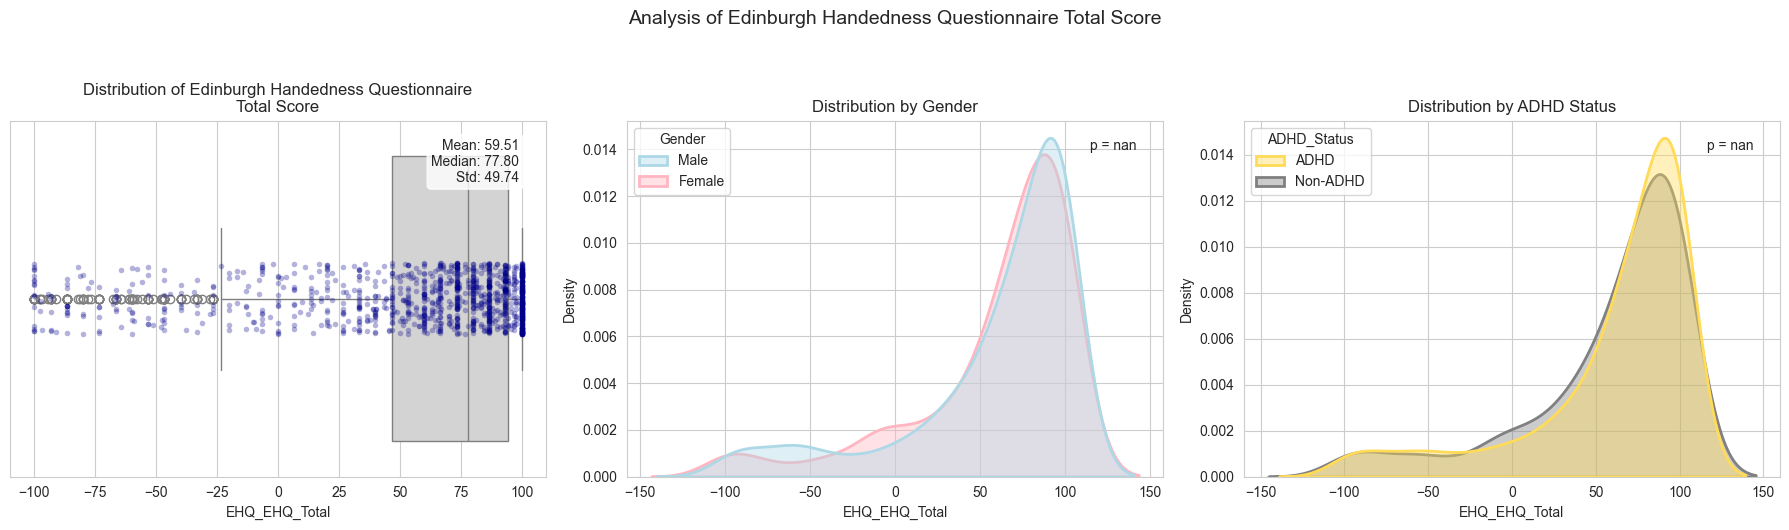


Statistical Analysis for Edinburgh Handedness Questionnaire Total Score:

By Gender:
Female (n=416): Mean = 59.56, SD = 47.93
Male (n=797): Mean = 59.49, SD = 50.69
T-test: t = nan, p = nan

By ADHD Status:
ADHD (n=831): Mean = 60.18, SD = 49.84
Non-ADHD (n=382): Mean = 58.07, SD = 49.57
T-test: t = nan, p = nan
--------------------------------------------------


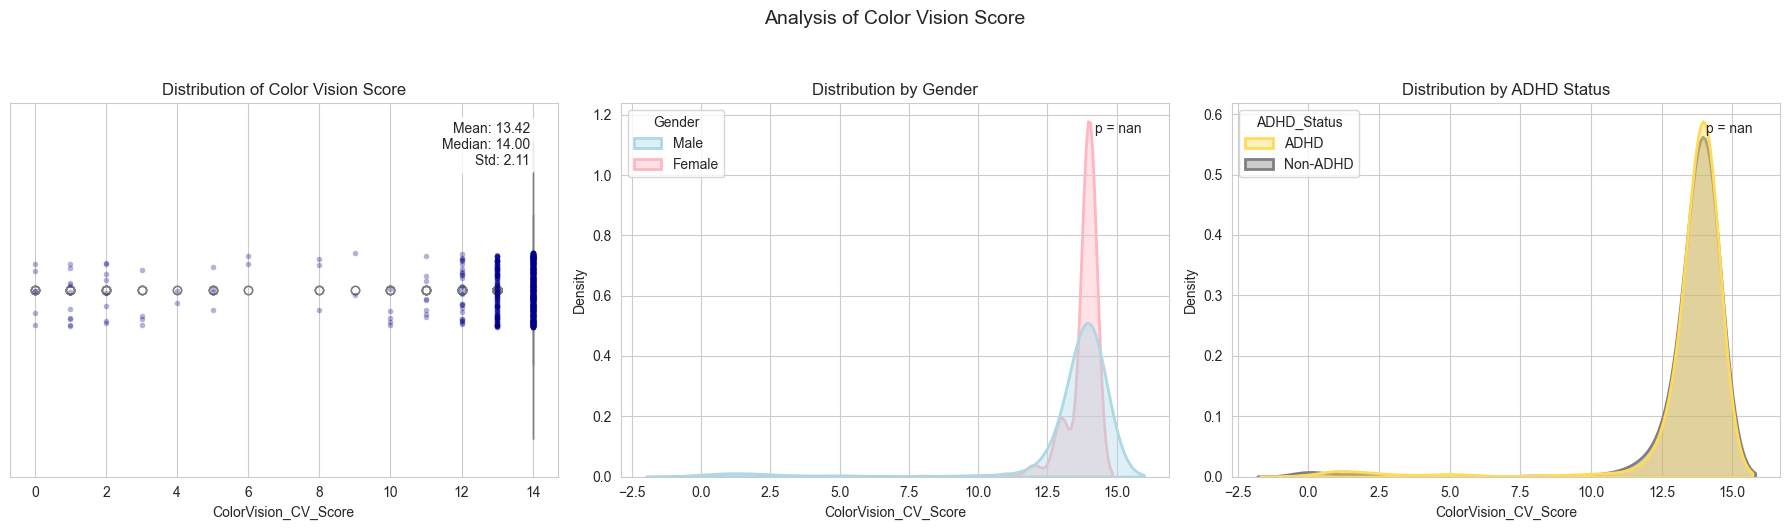


Statistical Analysis for Color Vision Score:

By Gender:
Female (n=416): Mean = 13.73, SD = 0.92
Male (n=797): Mean = 13.26, SD = 2.51
T-test: t = nan, p = nan

By ADHD Status:
ADHD (n=831): Mean = 13.39, SD = 2.18
Non-ADHD (n=382): Mean = 13.49, SD = 1.97
T-test: t = nan, p = nan
--------------------------------------------------


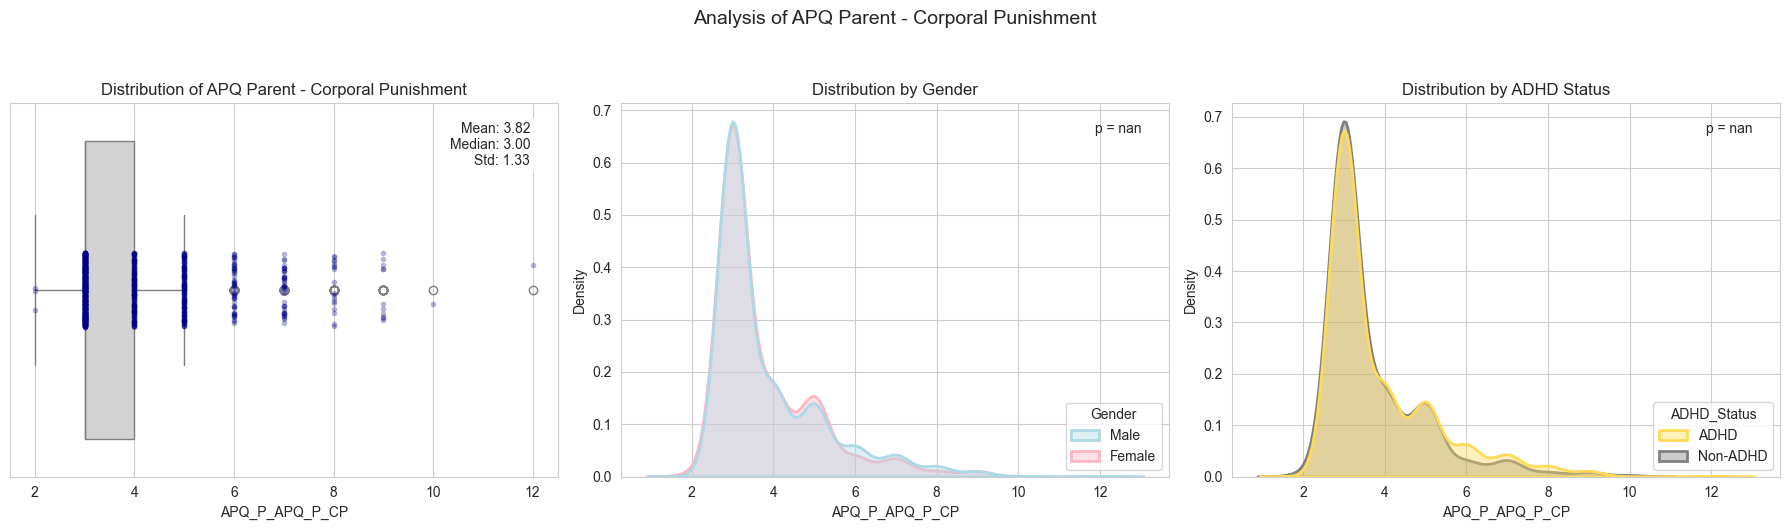


Statistical Analysis for APQ Parent - Corporal Punishment:

By Gender:
Female (n=416): Mean = 3.76, SD = 1.24
Male (n=797): Mean = 3.85, SD = 1.37
T-test: t = nan, p = nan

By ADHD Status:
ADHD (n=831): Mean = 3.87, SD = 1.37
Non-ADHD (n=382): Mean = 3.70, SD = 1.23
T-test: t = nan, p = nan
--------------------------------------------------


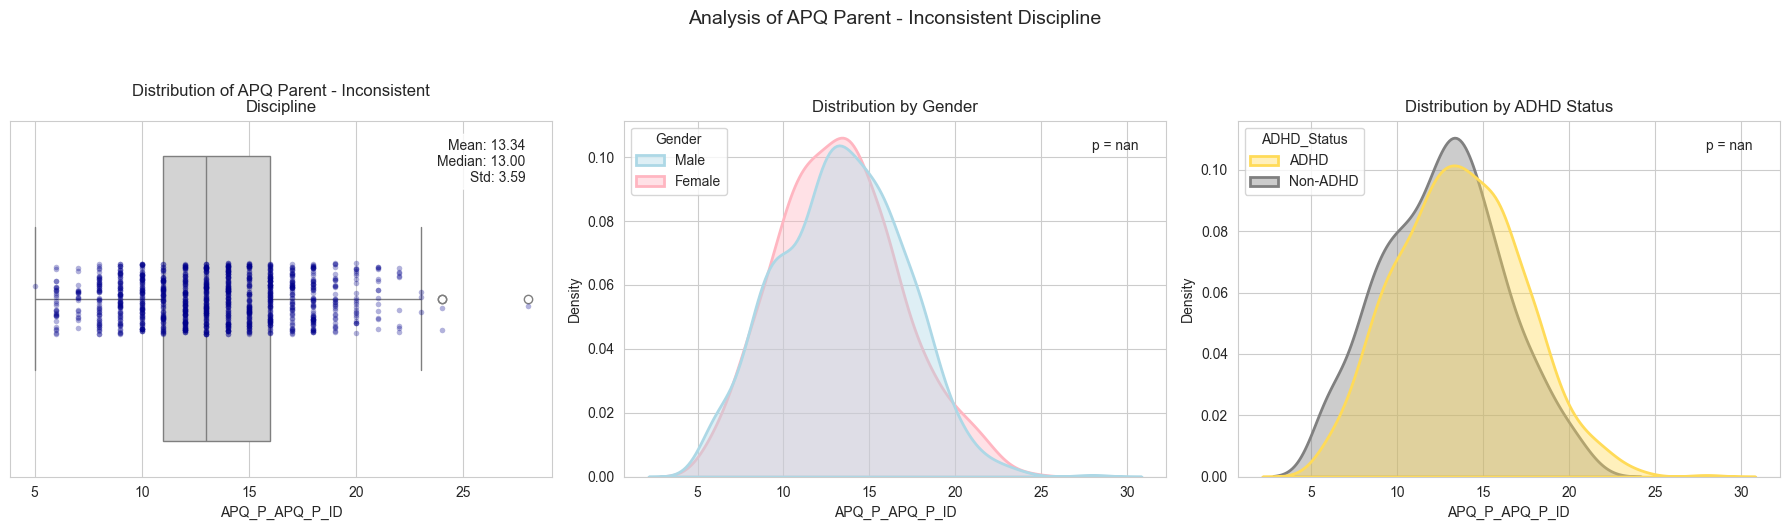


Statistical Analysis for APQ Parent - Inconsistent Discipline:

By Gender:
Female (n=416): Mean = 13.24, SD = 3.54
Male (n=797): Mean = 13.39, SD = 3.62
T-test: t = nan, p = nan

By ADHD Status:
ADHD (n=831): Mean = 13.64, SD = 3.61
Non-ADHD (n=382): Mean = 12.68, SD = 3.47
T-test: t = nan, p = nan
--------------------------------------------------


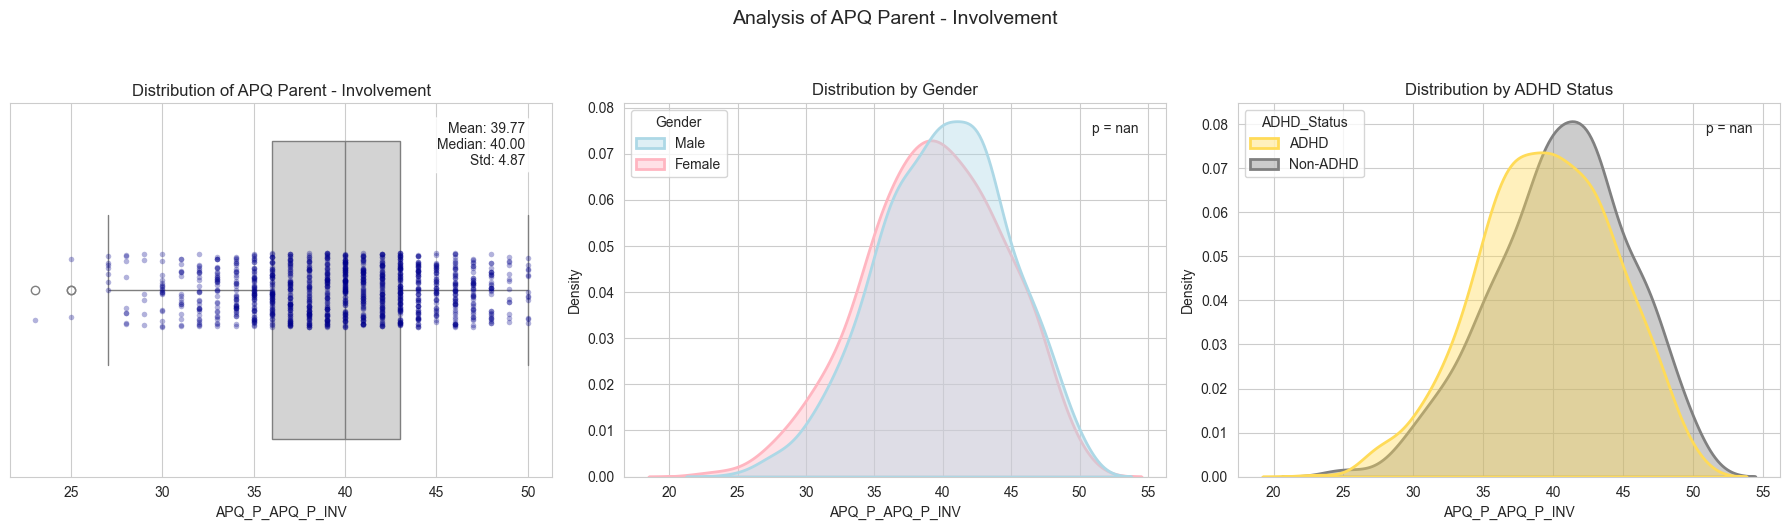


Statistical Analysis for APQ Parent - Involvement:

By Gender:
Female (n=416): Mean = 39.33, SD = 5.03
Male (n=797): Mean = 39.99, SD = 4.78
T-test: t = nan, p = nan

By ADHD Status:
ADHD (n=831): Mean = 39.44, SD = 4.86
Non-ADHD (n=382): Mean = 40.48, SD = 4.83
T-test: t = nan, p = nan
--------------------------------------------------


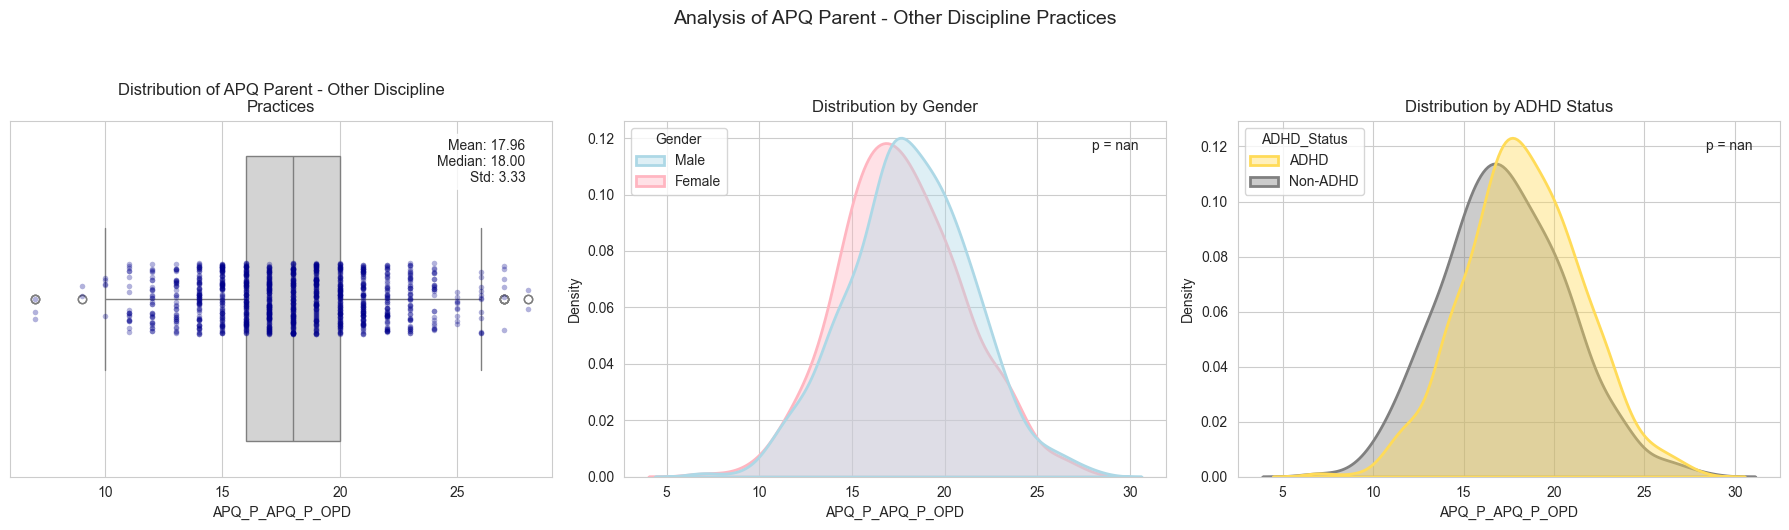


Statistical Analysis for APQ Parent - Other Discipline Practices:

By Gender:
Female (n=416): Mean = 17.68, SD = 3.31
Male (n=797): Mean = 18.11, SD = 3.34
T-test: t = nan, p = nan

By ADHD Status:
ADHD (n=831): Mean = 18.28, SD = 3.25
Non-ADHD (n=382): Mean = 17.26, SD = 3.41
T-test: t = nan, p = nan
--------------------------------------------------


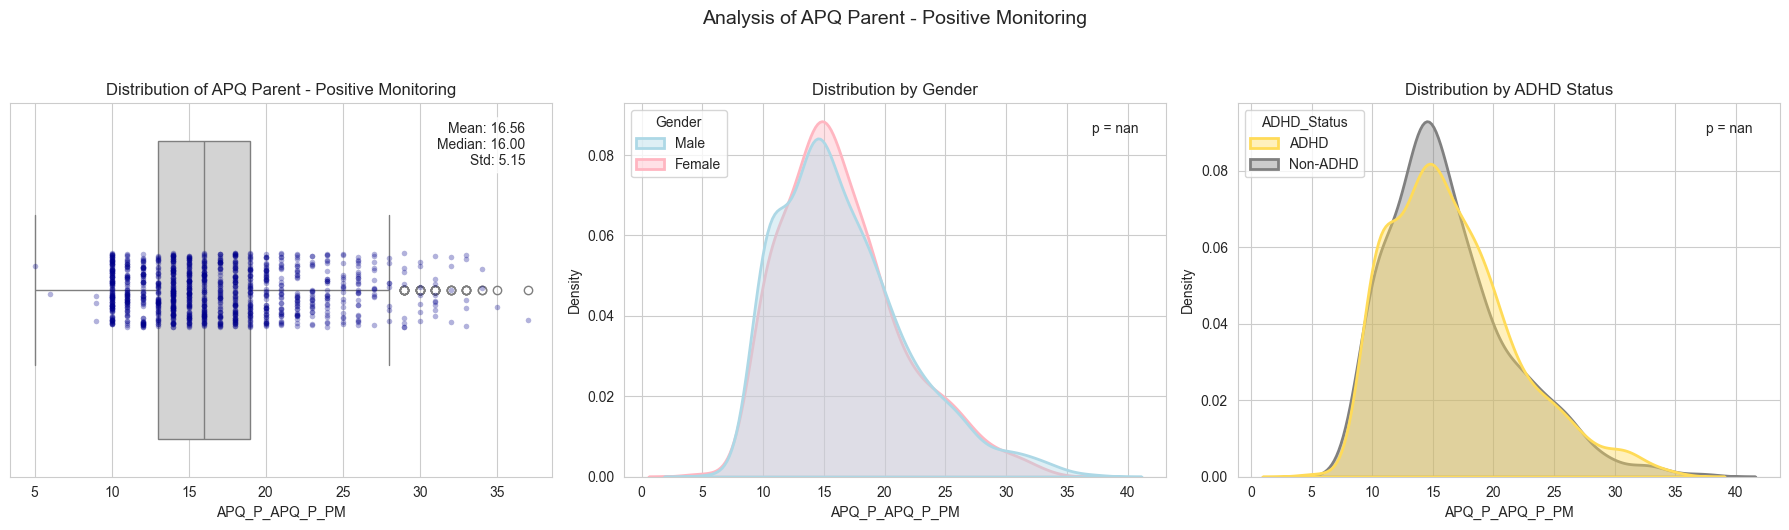


Statistical Analysis for APQ Parent - Positive Monitoring:

By Gender:
Female (n=416): Mean = 16.51, SD = 4.93
Male (n=797): Mean = 16.58, SD = 5.26
T-test: t = nan, p = nan

By ADHD Status:
ADHD (n=831): Mean = 16.65, SD = 5.20
Non-ADHD (n=382): Mean = 16.36, SD = 5.03
T-test: t = nan, p = nan
--------------------------------------------------


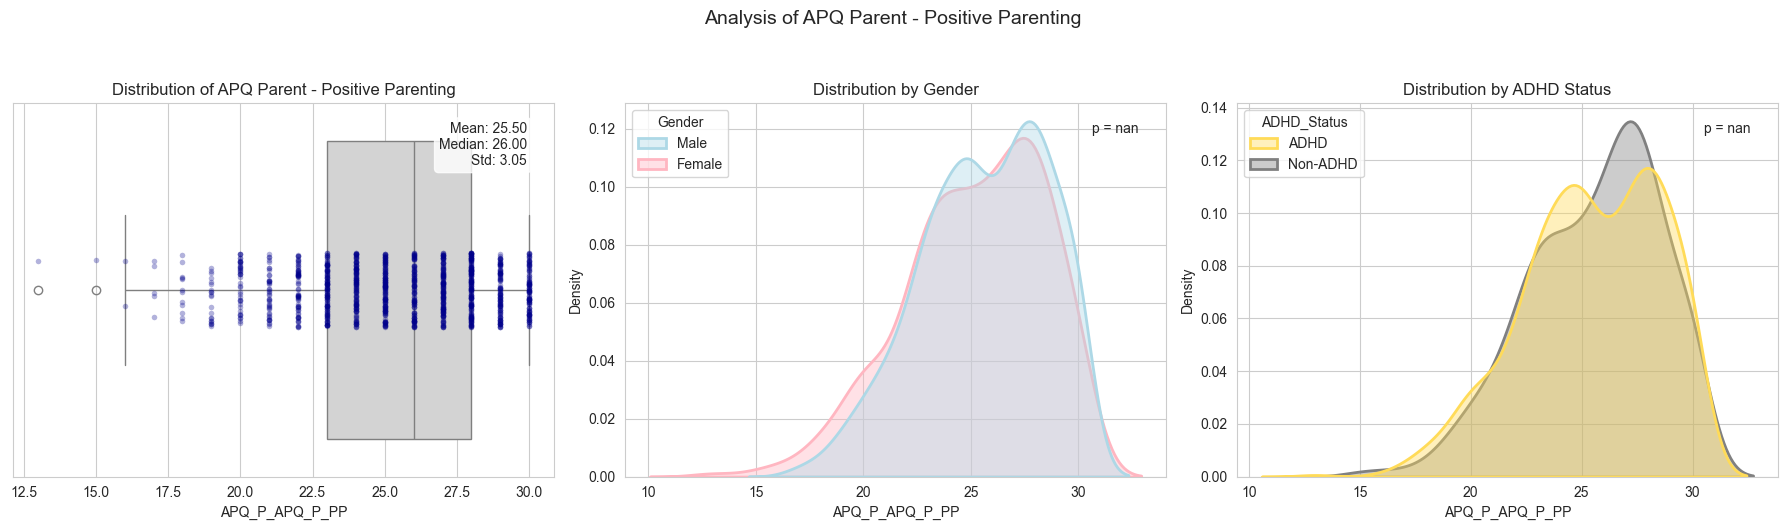


Statistical Analysis for APQ Parent - Positive Parenting:

By Gender:
Female (n=416): Mean = 25.20, SD = 3.24
Male (n=797): Mean = 25.65, SD = 2.94
T-test: t = nan, p = nan

By ADHD Status:
ADHD (n=831): Mean = 25.47, SD = 3.09
Non-ADHD (n=382): Mean = 25.57, SD = 2.97
T-test: t = nan, p = nan
--------------------------------------------------


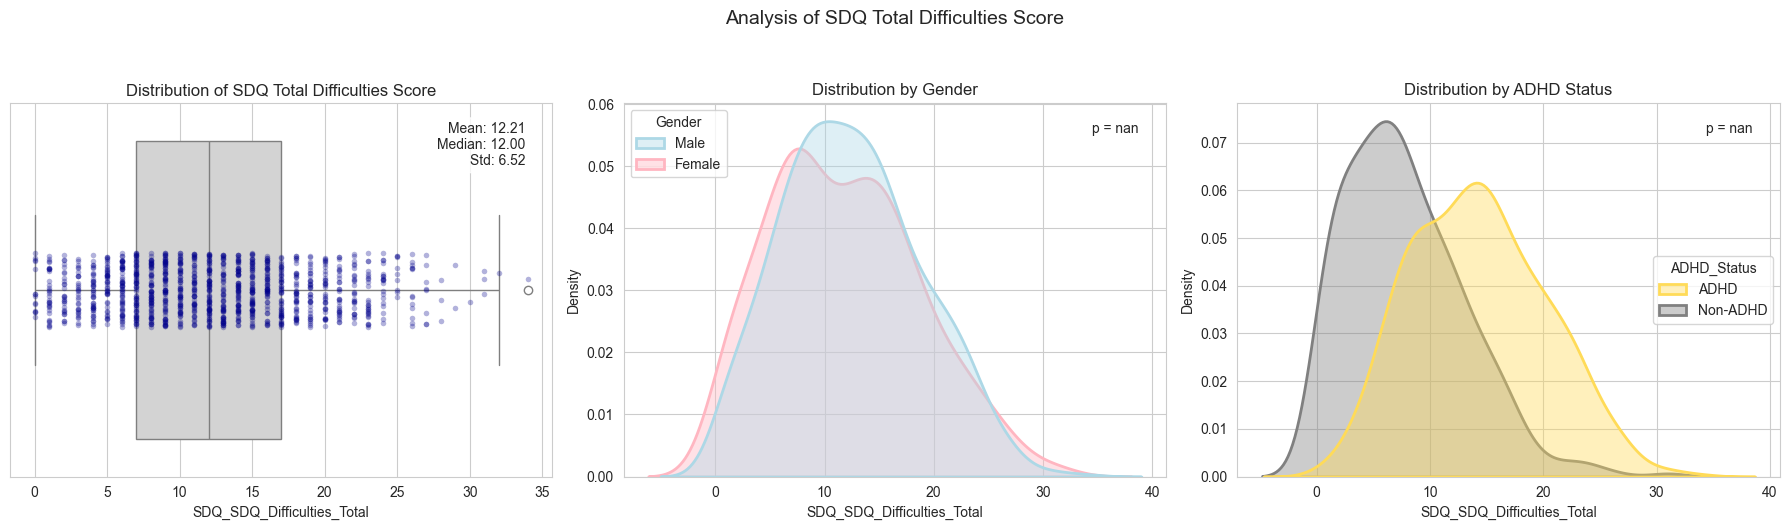


Statistical Analysis for SDQ Total Difficulties Score:

By Gender:
Female (n=416): Mean = 11.80, SD = 6.82
Male (n=797): Mean = 12.43, SD = 6.35
T-test: t = nan, p = nan

By ADHD Status:
ADHD (n=831): Mean = 14.26, SD = 5.99
Non-ADHD (n=382): Mean = 7.73, SD = 5.26
T-test: t = nan, p = nan
--------------------------------------------------


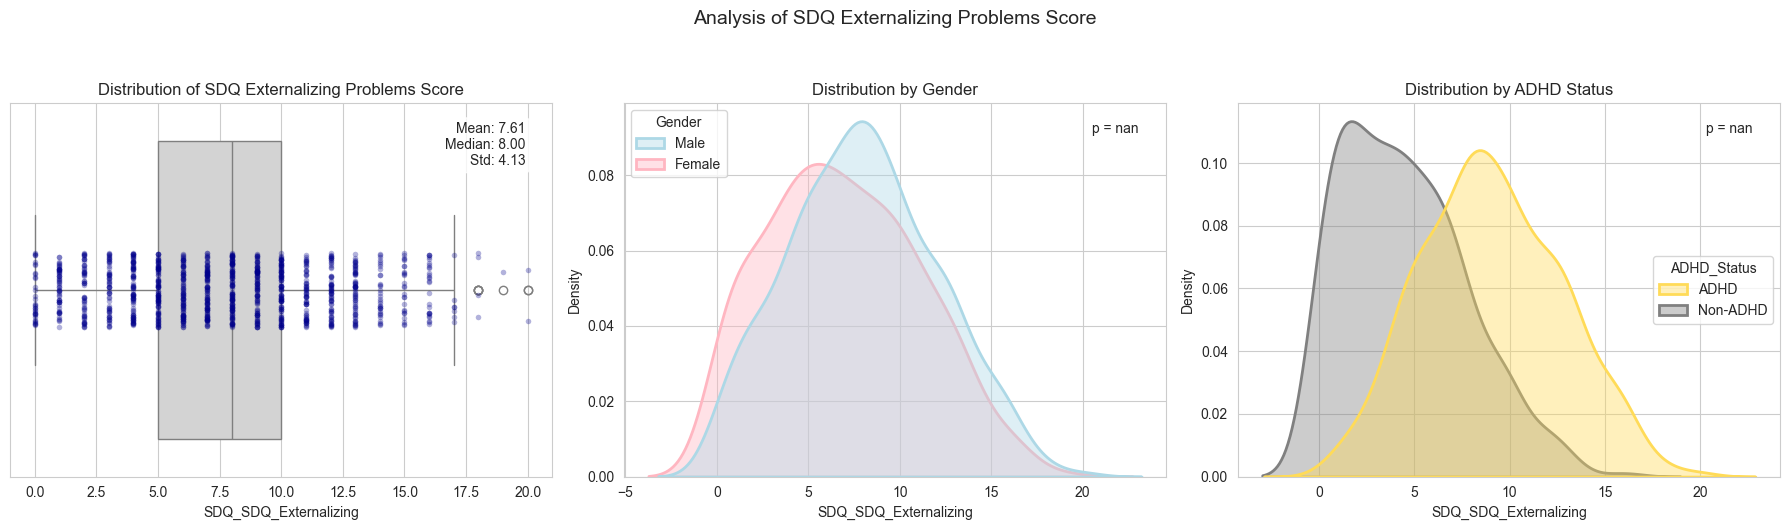


Statistical Analysis for SDQ Externalizing Problems Score:

By Gender:
Female (n=416): Mean = 6.92, SD = 4.16
Male (n=797): Mean = 7.97, SD = 4.07
T-test: t = nan, p = nan

By ADHD Status:
ADHD (n=831): Mean = 9.05, SD = 3.67
Non-ADHD (n=382): Mean = 4.47, SD = 3.24
T-test: t = nan, p = nan
--------------------------------------------------


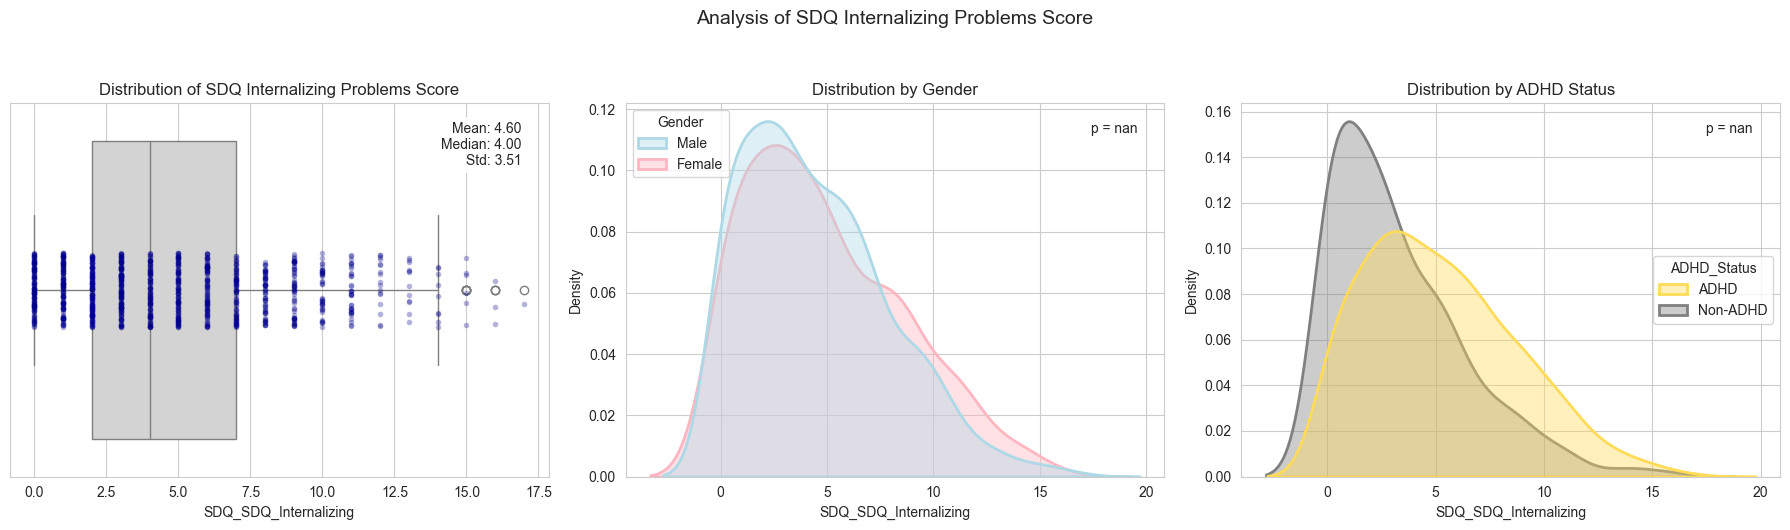


Statistical Analysis for SDQ Internalizing Problems Score:

By Gender:
Female (n=416): Mean = 4.88, SD = 3.68
Male (n=797): Mean = 4.45, SD = 3.41
T-test: t = nan, p = nan

By ADHD Status:
ADHD (n=831): Mean = 5.21, SD = 3.52
Non-ADHD (n=382): Mean = 3.26, SD = 3.09
T-test: t = nan, p = nan
--------------------------------------------------


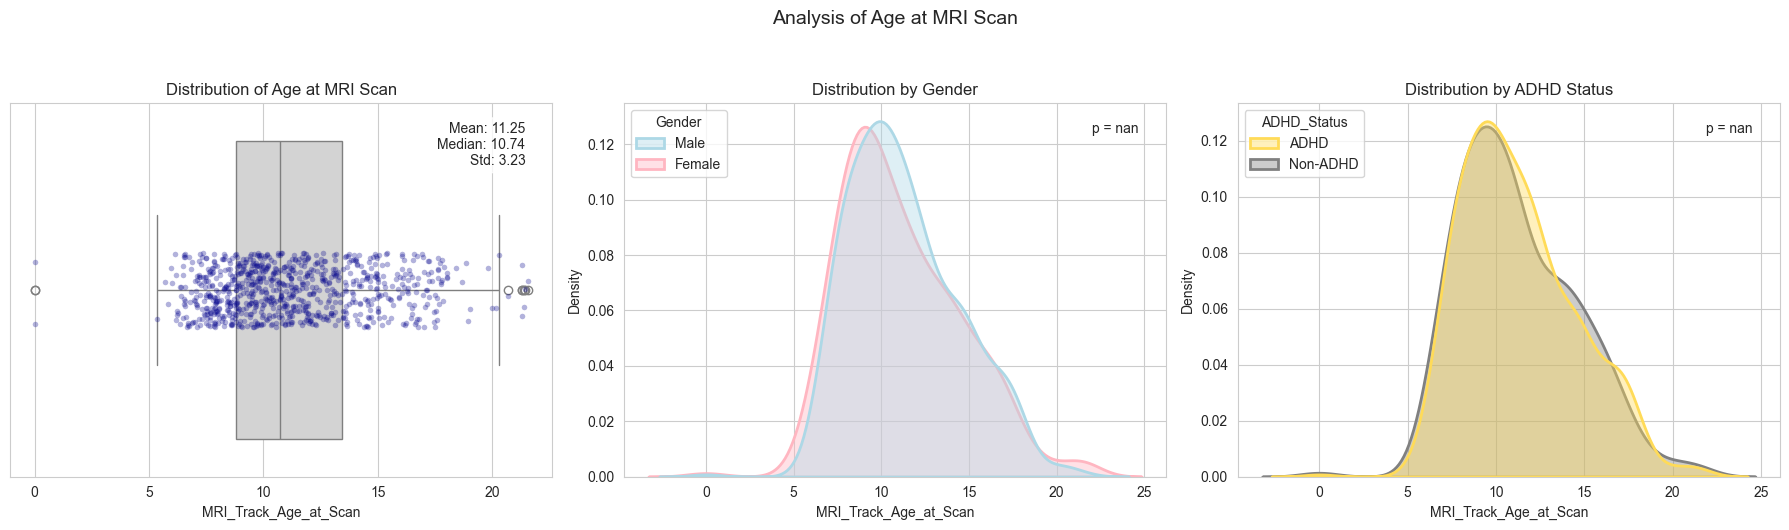


Statistical Analysis for Age at MRI Scan:

By Gender:
Female (n=416): Mean = 11.12, SD = 3.40
Male (n=797): Mean = 11.31, SD = 3.15
T-test: t = nan, p = nan

By ADHD Status:
ADHD (n=831): Mean = 11.27, SD = 3.21
Non-ADHD (n=382): Mean = 11.19, SD = 3.30
T-test: t = nan, p = nan
--------------------------------------------------


In [100]:
# mapping dictionary
variable_descriptions = {
    'EHQ_EHQ_Total': 'Edinburgh Handedness Questionnaire Total Score',
    'ColorVision_CV_Score': 'Color Vision Score',
    'APQ_P_APQ_P_CP': 'APQ Parent - Corporal Punishment',
    'APQ_P_APQ_P_ID': 'APQ Parent - Inconsistent Discipline',
    'APQ_P_APQ_P_INV': 'APQ Parent - Involvement',
    'APQ_P_APQ_P_OPD': 'APQ Parent - Other Discipline Practices',
    'APQ_P_APQ_P_PM': 'APQ Parent - Positive Monitoring',
    'APQ_P_APQ_P_PP': 'APQ Parent - Positive Parenting',
    'SDQ_SDQ_Difficulties_Total': 'SDQ Total Difficulties Score',
    'SDQ_SDQ_Externalizing': 'SDQ Externalizing Problems Score',
    'SDQ_SDQ_Internalizing': 'SDQ Internalizing Problems Score',
    'MRI_Track_Age_at_Scan': 'Age at MRI Scan'
}

# Define custom color palettes for gender and ADHD status
gender_palette = {"Male": "lightblue", "Female": "lightpink"}
adhd_palette = {"Non-ADHD": "grey", "ADHD": "#FFDB58"}

# Ensure we only analyze the numerical variables
variables = [col for col in overall_df.columns if col in numerical_variables]

# Create new columns for gender and ADHD status if not already present
if 'Gender' not in overall_df.columns:
    overall_df['Gender'] = overall_df['Sex_F'].apply(lambda x: "Female" if x == 1 else "Male")

if 'ADHD_Status' not in overall_df.columns:
    overall_df['ADHD_Status'] = overall_df['ADHD_Outcome'].apply(lambda x: "ADHD" if x == 1 else "Non-ADHD")

def create_numerical_plots(variable):
    sns.set_style('whitegrid')

    # Create a 1x3 subplot: box plot, gender KDE, ADHD KDE
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Get variable description
    var_description = variable_descriptions.get(variable, variable)

    # ---------------------
    # 1. Box plot with individual points
    # ---------------------
    sns.boxplot(ax=axes[0], data=overall_df, x=variable, color='lightgrey')
    sns.stripplot(ax=axes[0], data=overall_df, x=variable, color='darkblue', alpha=0.3, size=4)
    axes[0].set_xlabel(variable)
    title_box = f"Distribution of {var_description}"
    axes[0].set_title("\n".join(textwrap.wrap(title_box, width=50)))

    # ---------------------
    # 2. KDE Plot by Gender (Male vs Female)
    # ---------------------
    sns.kdeplot(ax=axes[1], data=overall_df, x=variable, hue="Gender", fill=True, 
                common_norm=False, palette=gender_palette, alpha=0.4, linewidth=2)
    axes[1].set_xlabel(variable)
    axes[1].set_title(f"Distribution by Gender")

    # ---------------------
    # 3. KDE Plot by ADHD Status
    # ---------------------
    sns.kdeplot(ax=axes[2], data=overall_df, x=variable, hue="ADHD_Status", fill=True, 
                common_norm=False, palette=adhd_palette, alpha=0.4, linewidth=2)
    axes[2].set_xlabel(variable)
    axes[2].set_title(f"Distribution by ADHD Status")

    # Add descriptive statistics as text
    stats_text = f"Mean: {overall_df[variable].mean():.2f}\n"
    stats_text += f"Median: {overall_df[variable].median():.2f}\n"
    stats_text += f"Std: {overall_df[variable].std():.2f}"
    axes[0].text(0.95, 0.95, stats_text,
                 transform=axes[0].transAxes,
                 verticalalignment='top',
                 horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Add statistical tests
    # T-test for gender differences
    female_data = overall_df[overall_df['Gender'] == 'Female'][variable]
    male_data = overall_df[overall_df['Gender'] == 'Male'][variable]
    t_stat_gender, p_val_gender = stats.ttest_ind(female_data, male_data)
    
    # T-test for ADHD differences
    adhd_data = overall_df[overall_df['ADHD_Status'] == 'ADHD'][variable]
    non_adhd_data = overall_df[overall_df['ADHD_Status'] == 'Non-ADHD'][variable]
    t_stat_adhd, p_val_adhd = stats.ttest_ind(adhd_data, non_adhd_data)
    
    # Add p-values to the plots
    axes[1].text(0.95, 0.95, f'p = {p_val_gender:.3f}',
                 transform=axes[1].transAxes,
                 verticalalignment='top',
                 horizontalalignment='right')
    
    axes[2].text(0.95, 0.95, f'p = {p_val_adhd:.3f}',
                 transform=axes[2].transAxes,
                 verticalalignment='top',
                 horizontalalignment='right')

    # Adjust spacing and show the plots
    plt.suptitle(f"Analysis of {var_description}", y=1.05, fontsize=14)
    plt.tight_layout()
    plt.show()

    # Print additional statistical information
    print(f"\nStatistical Analysis for {var_description}:")
    print("\nBy Gender:")
    print(f"Female (n={len(female_data)}): Mean = {female_data.mean():.2f}, SD = {female_data.std():.2f}")
    print(f"Male (n={len(male_data)}): Mean = {male_data.mean():.2f}, SD = {male_data.std():.2f}")
    print(f"T-test: t = {t_stat_gender:.2f}, p = {p_val_gender:.3f}")
    
    print("\nBy ADHD Status:")
    print(f"ADHD (n={len(adhd_data)}): Mean = {adhd_data.mean():.2f}, SD = {adhd_data.std():.2f}")
    print(f"Non-ADHD (n={len(non_adhd_data)}): Mean = {non_adhd_data.mean():.2f}, SD = {non_adhd_data.std():.2f}")
    print(f"T-test: t = {t_stat_adhd:.2f}, p = {p_val_adhd:.3f}")
    print("-" * 50)

# Perform univariate analysis for each variable in the list
for variable in variables:
    create_numerical_plots(variable)

# Clean up: Drop the temporary columns after analysis
overall_df.drop(['Gender', 'ADHD_Status'], axis=1, inplace=True)

### Categorical Feature Analysis

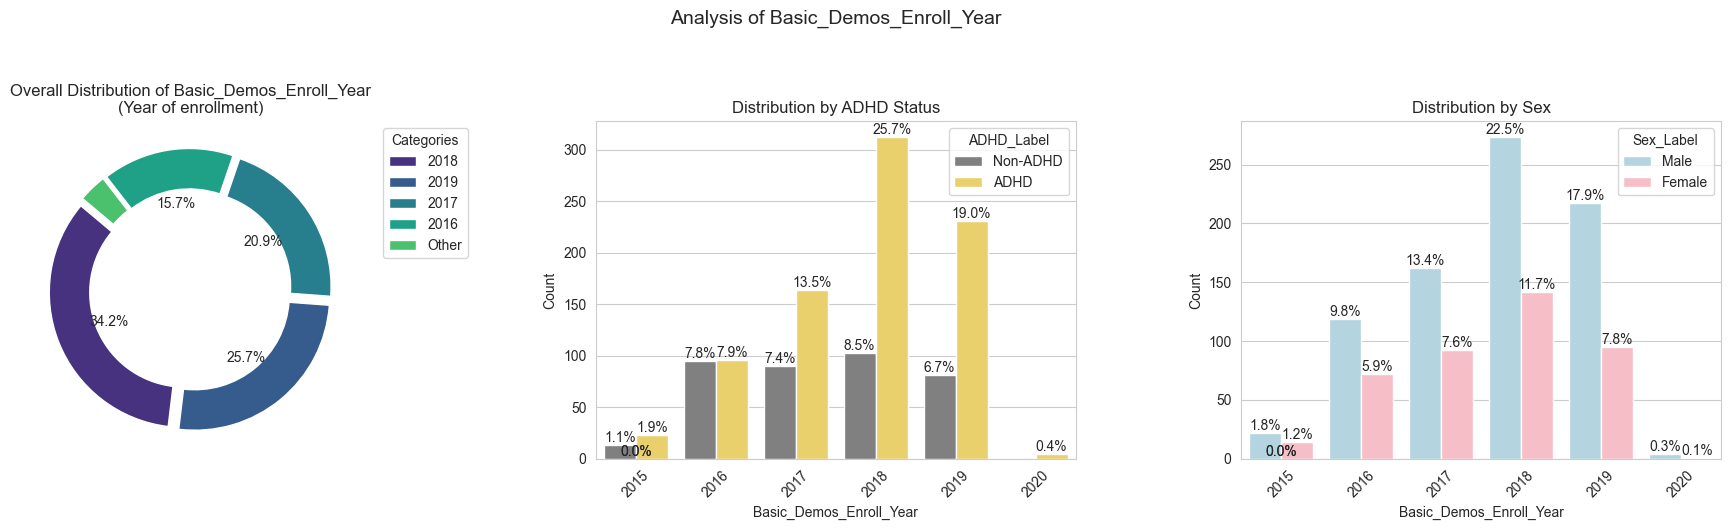


Chi-square Test Results for Basic_Demos_Enroll_Year:
- Association with ADHD: chi2 = 46.94, p = 0.0000
- Association with Sex: chi2 = 4.24, p = 0.5156
--------------------------------------------------


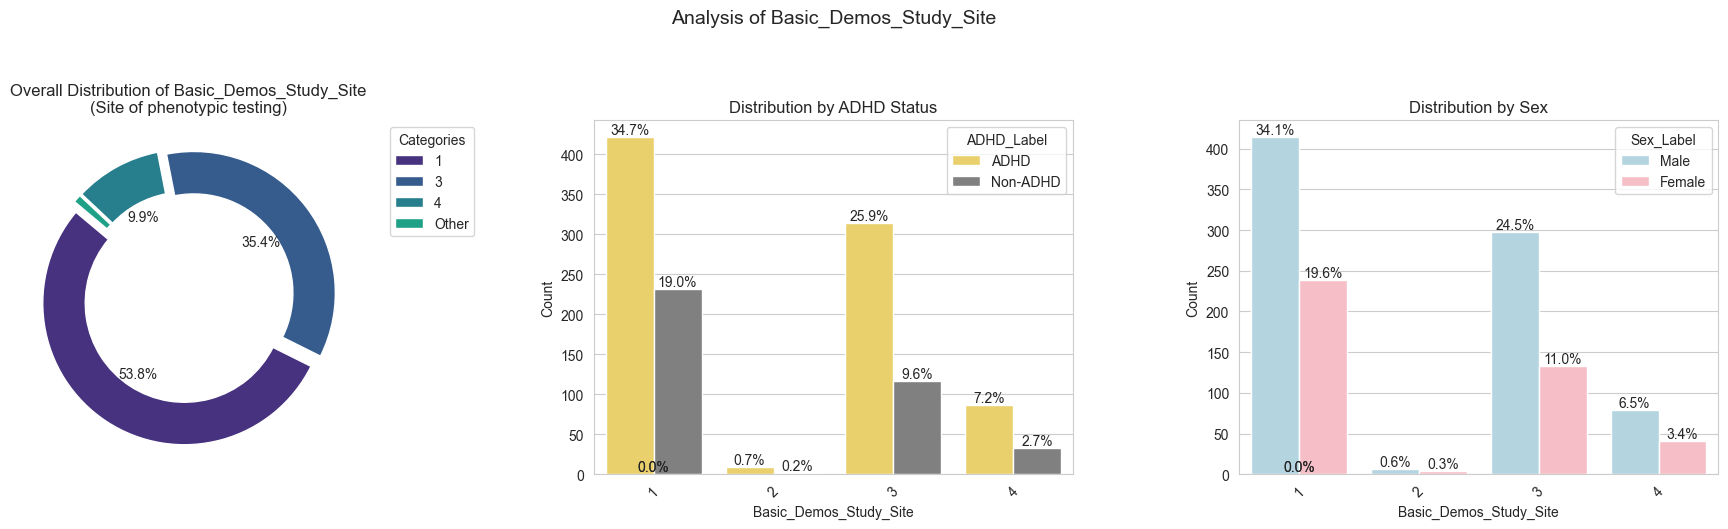


Chi-square Test Results for Basic_Demos_Study_Site:
- Association with ADHD: chi2 = 10.54, p = 0.0145
- Association with Sex: chi2 = 3.59, p = 0.3089
--------------------------------------------------


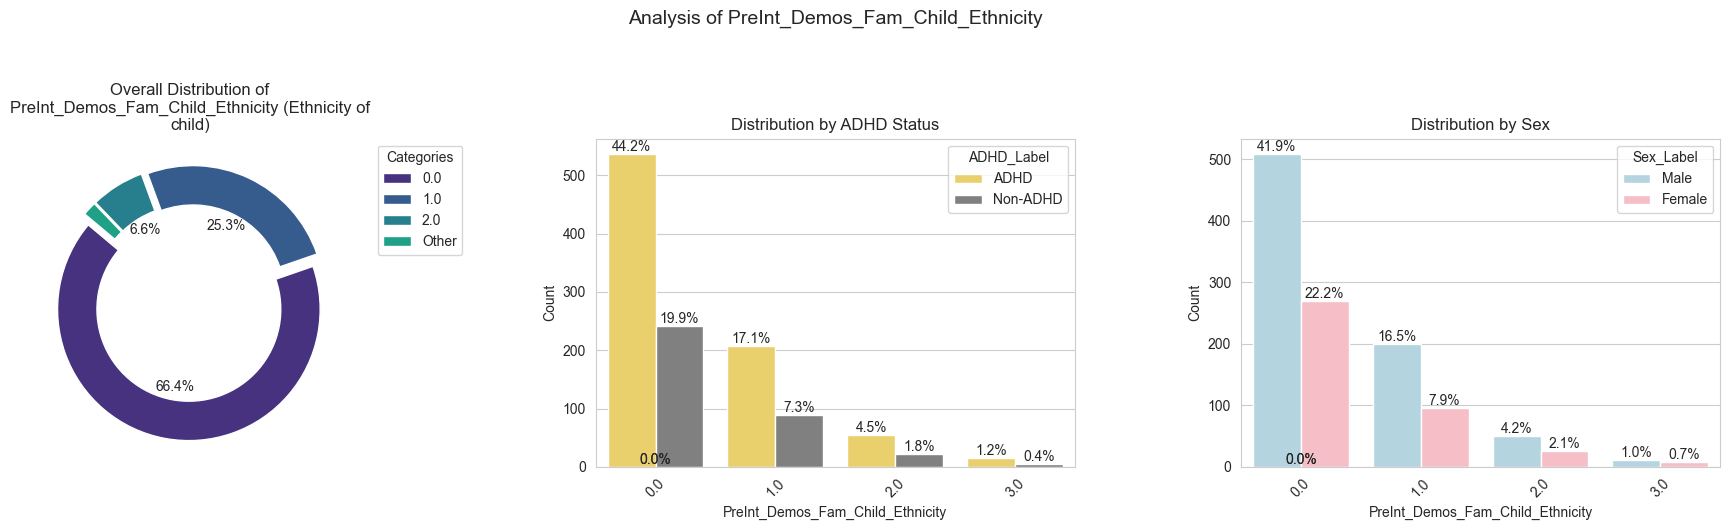


Chi-square Test Results for PreInt_Demos_Fam_Child_Ethnicity:
- Association with ADHD: chi2 = 0.54, p = 0.9091
- Association with Sex: chi2 = 0.77, p = 0.8558
--------------------------------------------------


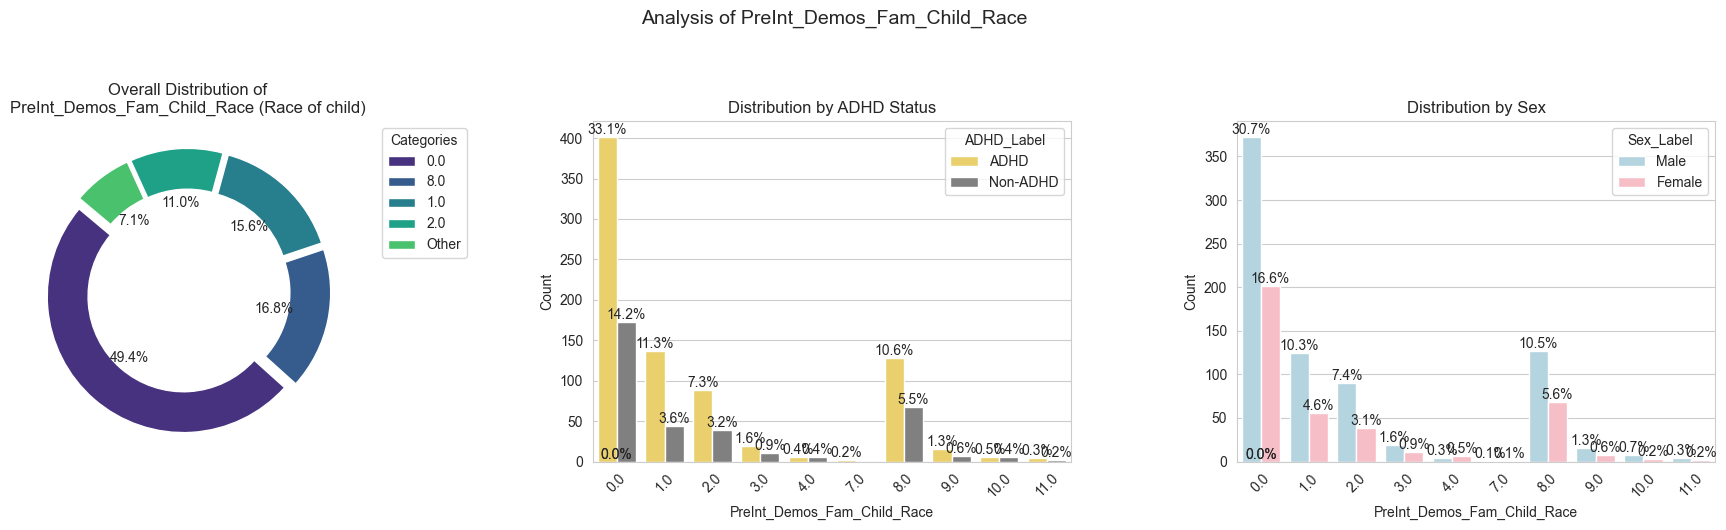


Chi-square Test Results for PreInt_Demos_Fam_Child_Race:
- Association with ADHD: chi2 = 9.11, p = 0.4271
- Association with Sex: chi2 = 5.87, p = 0.7527
--------------------------------------------------


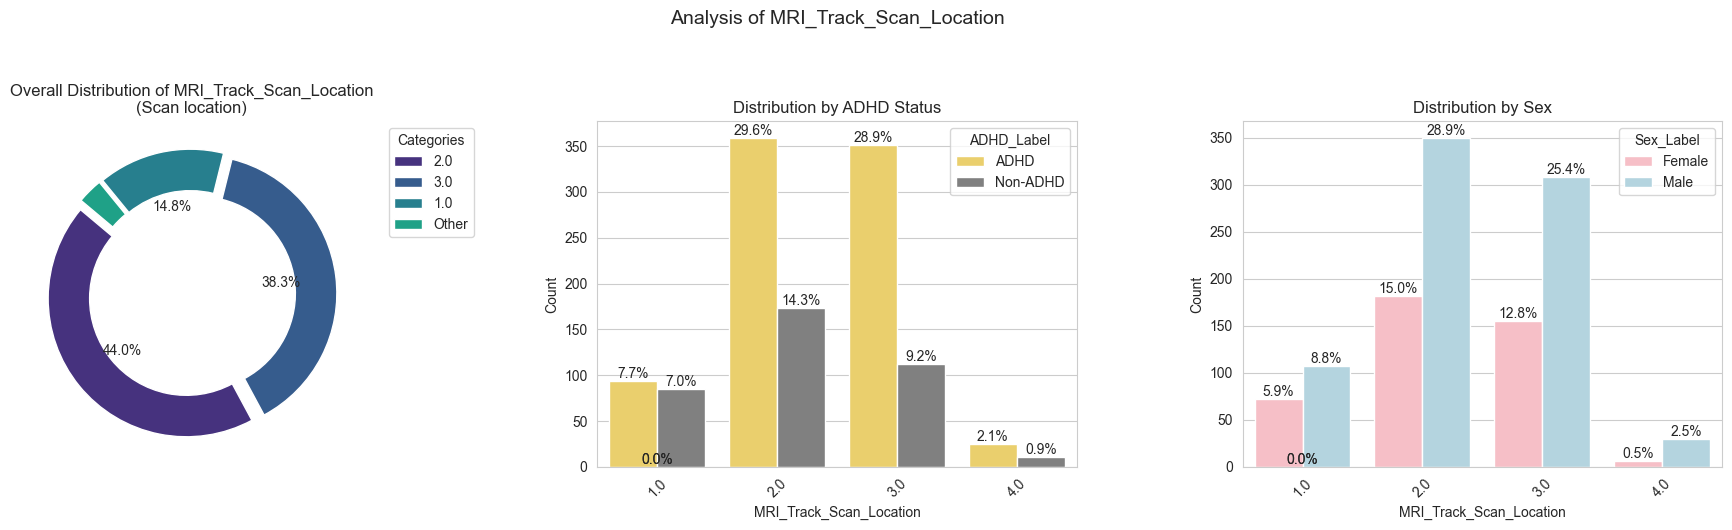


Chi-square Test Results for MRI_Track_Scan_Location:
- Association with ADHD: chi2 = 32.94, p = 0.0000
- Association with Sex: chi2 = 7.90, p = 0.0482
--------------------------------------------------


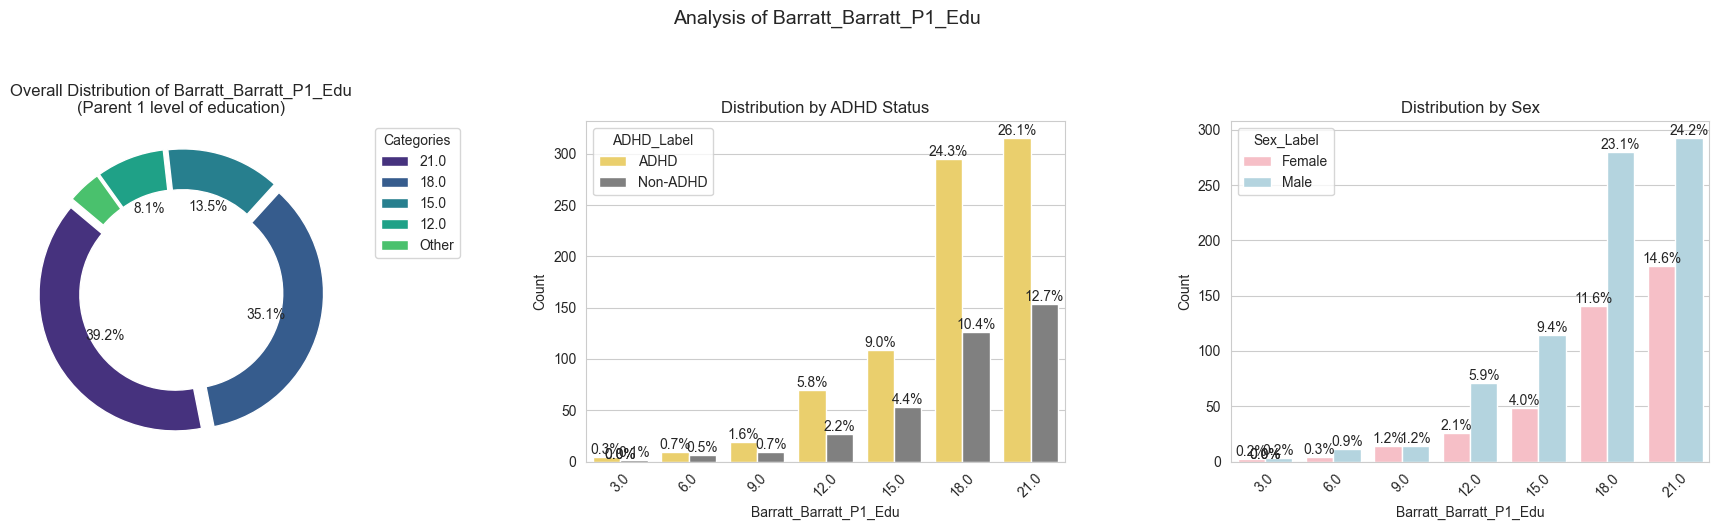


Chi-square Test Results for Barratt_Barratt_P1_Edu:
- Association with ADHD: chi2 = 2.36, p = 0.8841
- Association with Sex: chi2 = 9.97, p = 0.1260
--------------------------------------------------


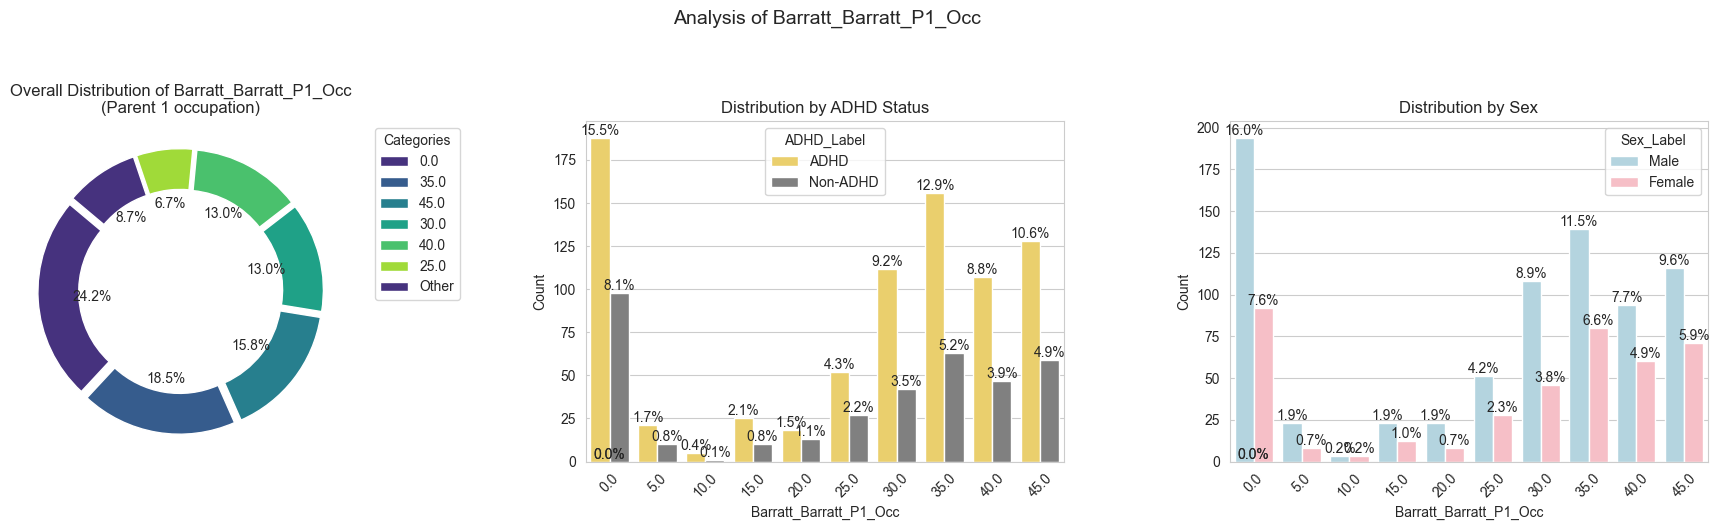


Chi-square Test Results for Barratt_Barratt_P1_Occ:
- Association with ADHD: chi2 = 5.70, p = 0.7695
- Association with Sex: chi2 = 7.64, p = 0.5707
--------------------------------------------------


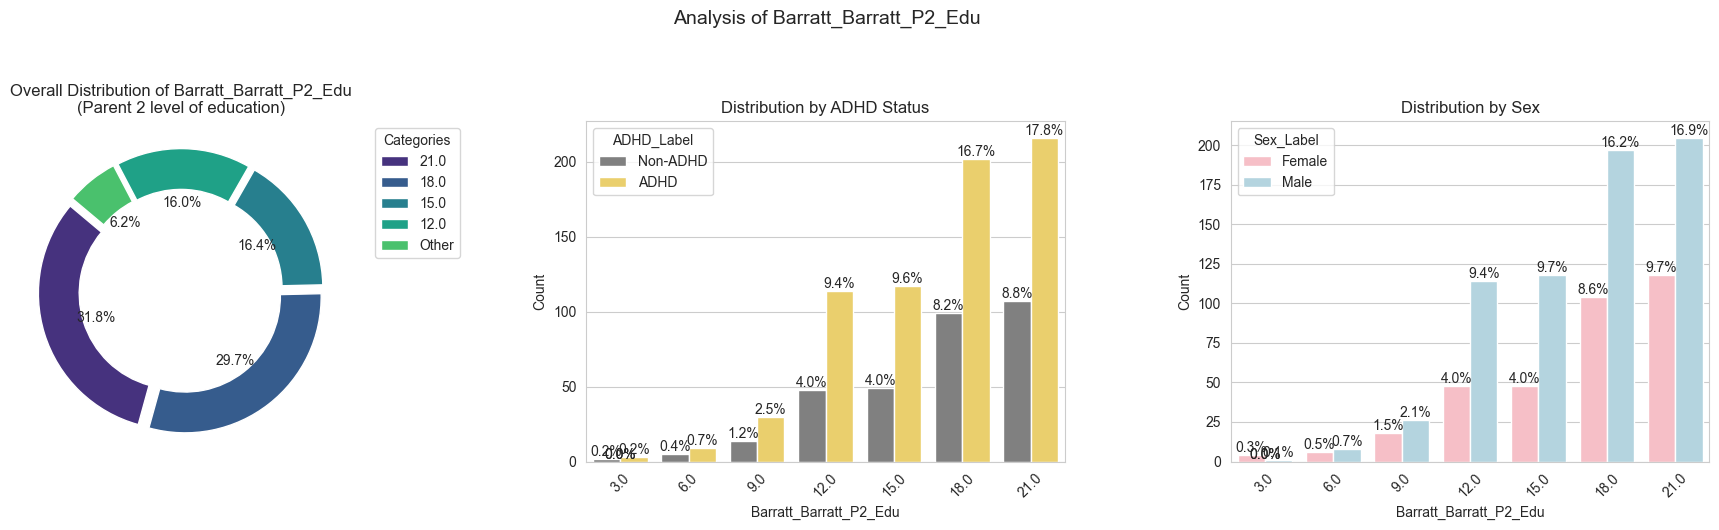


Chi-square Test Results for Barratt_Barratt_P2_Edu:
- Association with ADHD: chi2 = 1.42, p = 0.9645
- Association with Sex: chi2 = 10.38, p = 0.1096
--------------------------------------------------


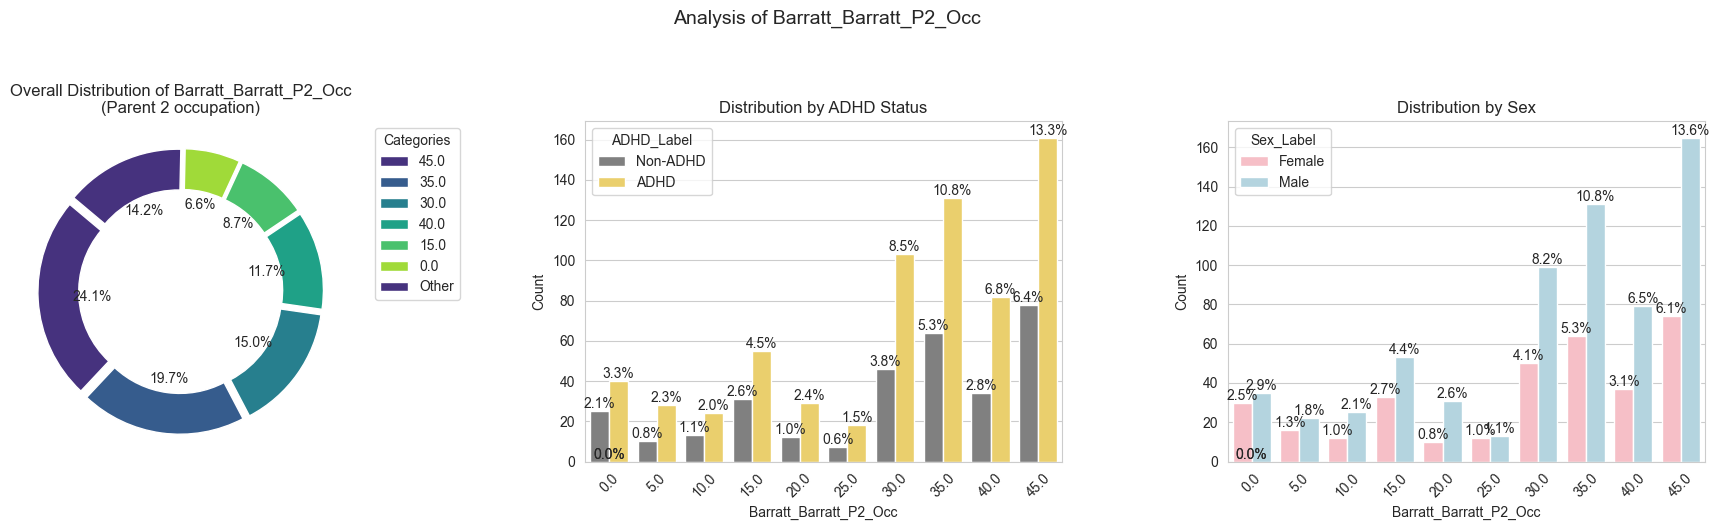


Chi-square Test Results for Barratt_Barratt_P2_Occ:
- Association with ADHD: chi2 = 3.47, p = 0.9426
- Association with Sex: chi2 = 11.36, p = 0.2519
--------------------------------------------------


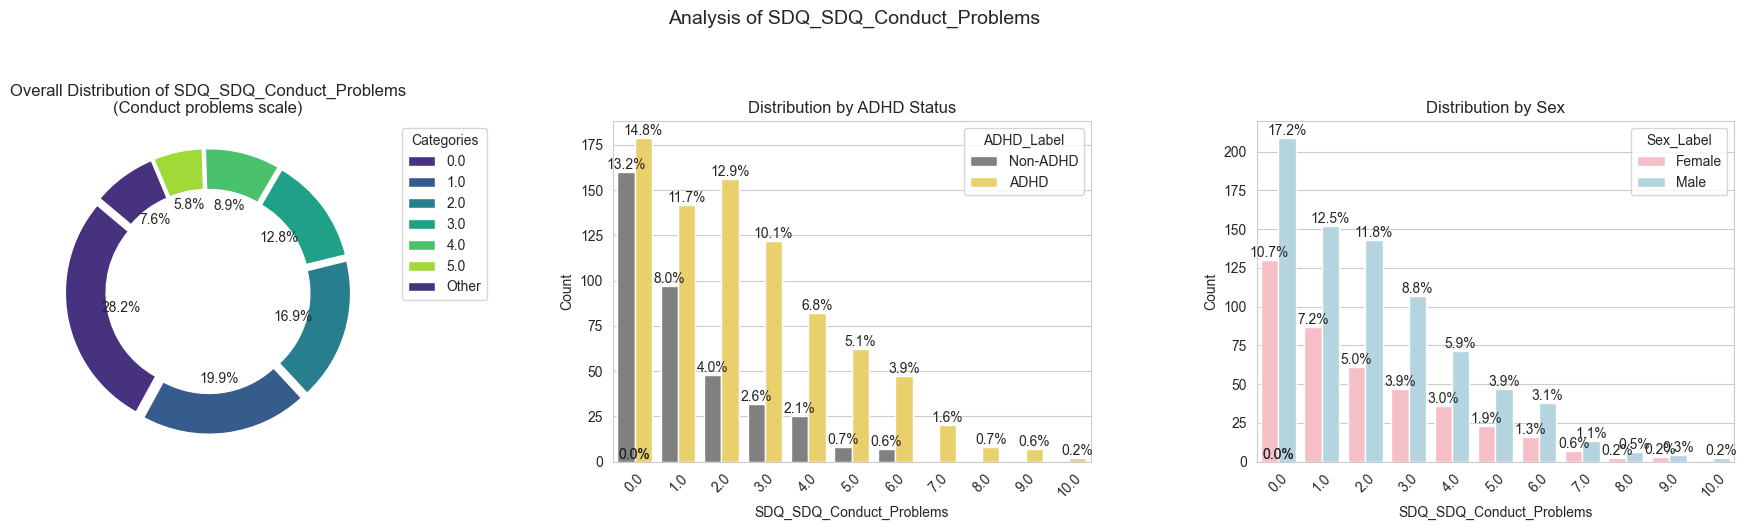


Chi-square Test Results for SDQ_SDQ_Conduct_Problems:
- Association with ADHD: chi2 = 104.35, p = 0.0000
- Association with Sex: chi2 = 7.86, p = 0.6428
--------------------------------------------------


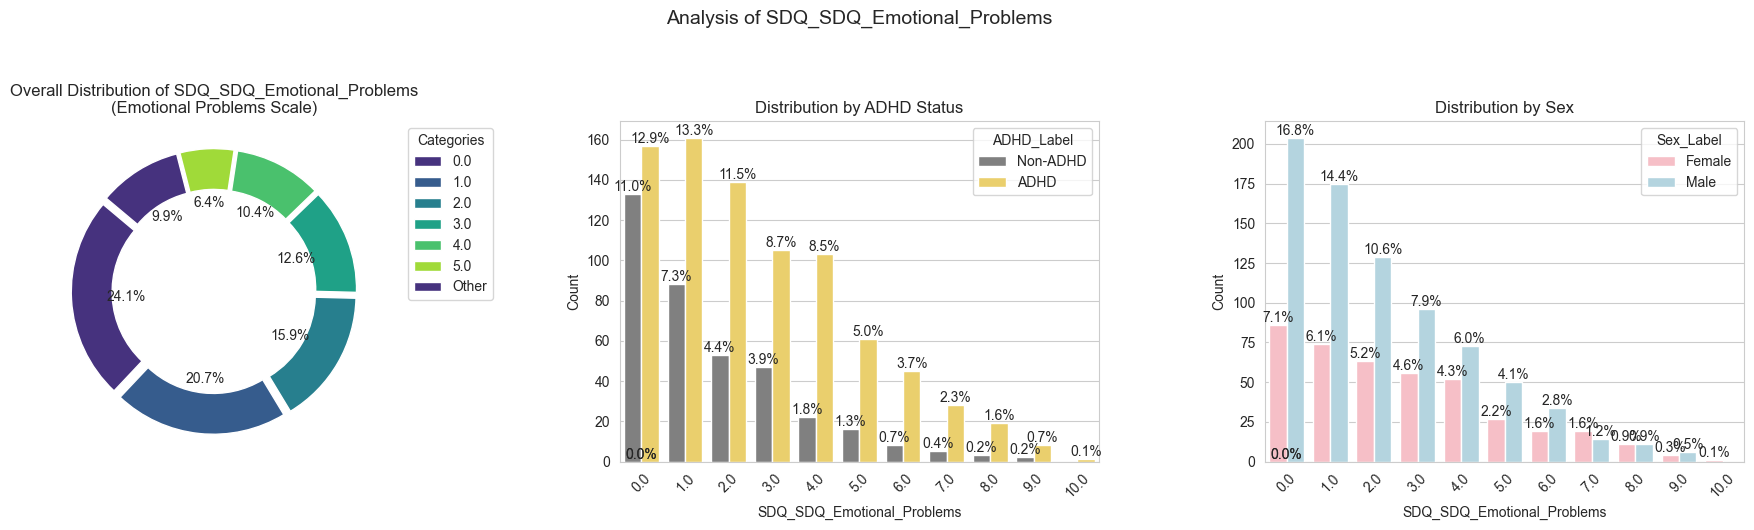


Chi-square Test Results for SDQ_SDQ_Emotional_Problems:
- Association with ADHD: chi2 = 61.30, p = 0.0000
- Association with Sex: chi2 = 21.17, p = 0.0199
--------------------------------------------------


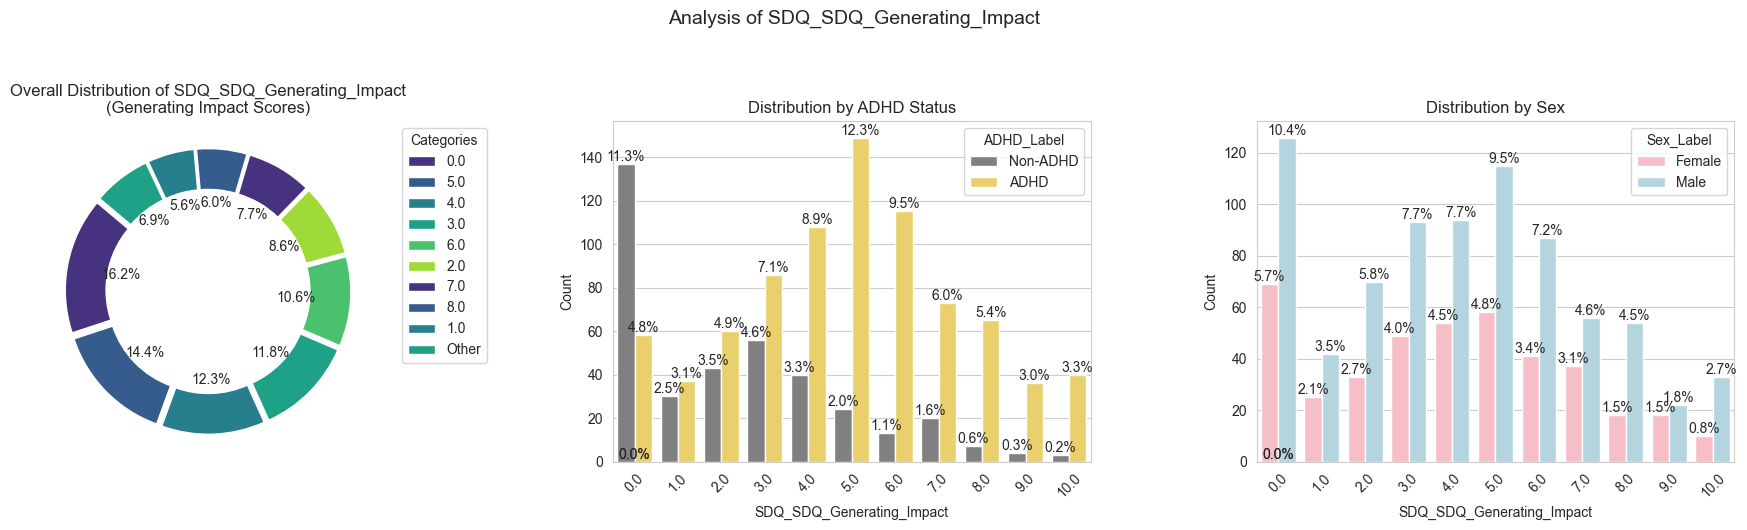


Chi-square Test Results for SDQ_SDQ_Generating_Impact:
- Association with ADHD: chi2 = 245.14, p = 0.0000
- Association with Sex: chi2 = 9.63, p = 0.4733
--------------------------------------------------


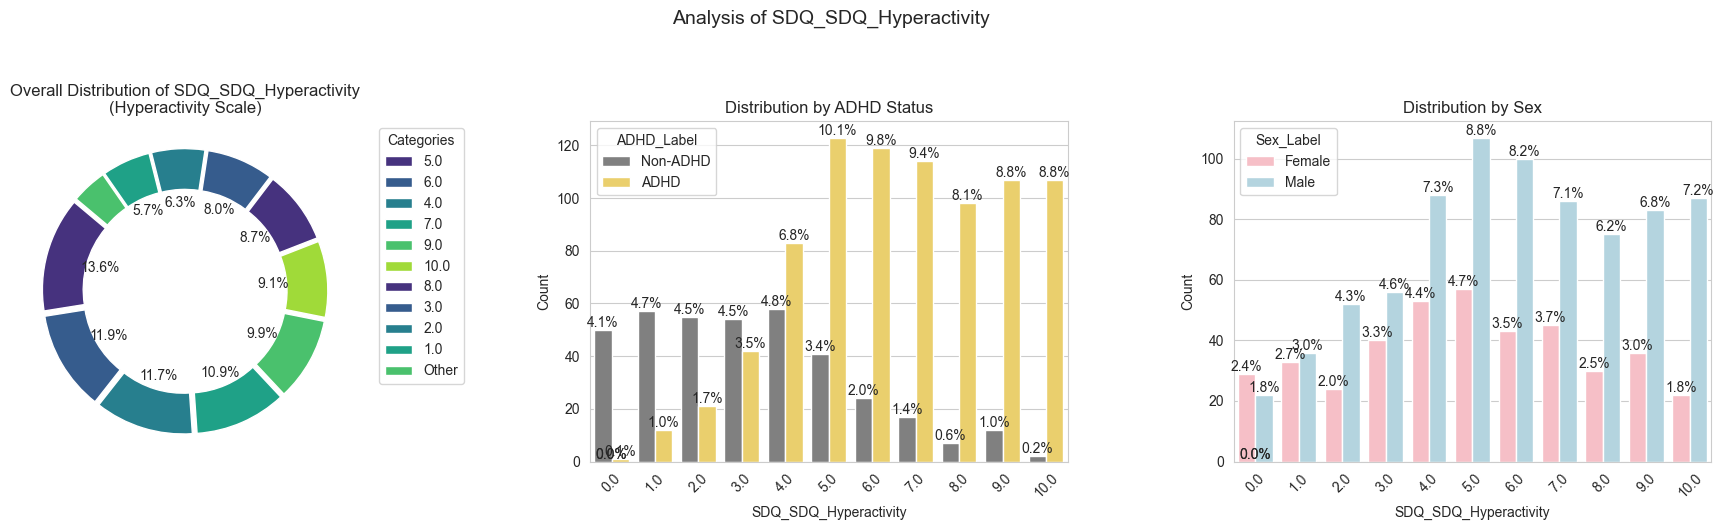


Chi-square Test Results for SDQ_SDQ_Hyperactivity:
- Association with ADHD: chi2 = 419.82, p = 0.0000
- Association with Sex: chi2 = 33.58, p = 0.0002
--------------------------------------------------


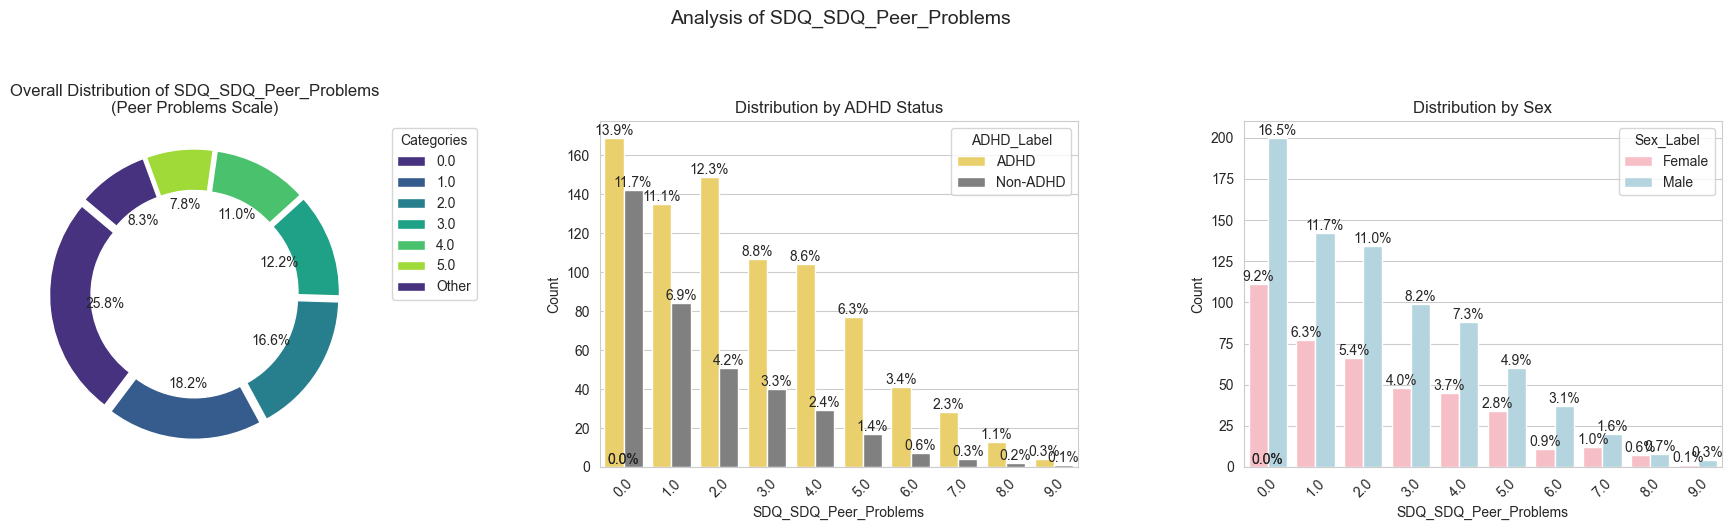


Chi-square Test Results for SDQ_SDQ_Peer_Problems:
- Association with ADHD: chi2 = 66.41, p = 0.0000
- Association with Sex: chi2 = 5.20, p = 0.8162
--------------------------------------------------


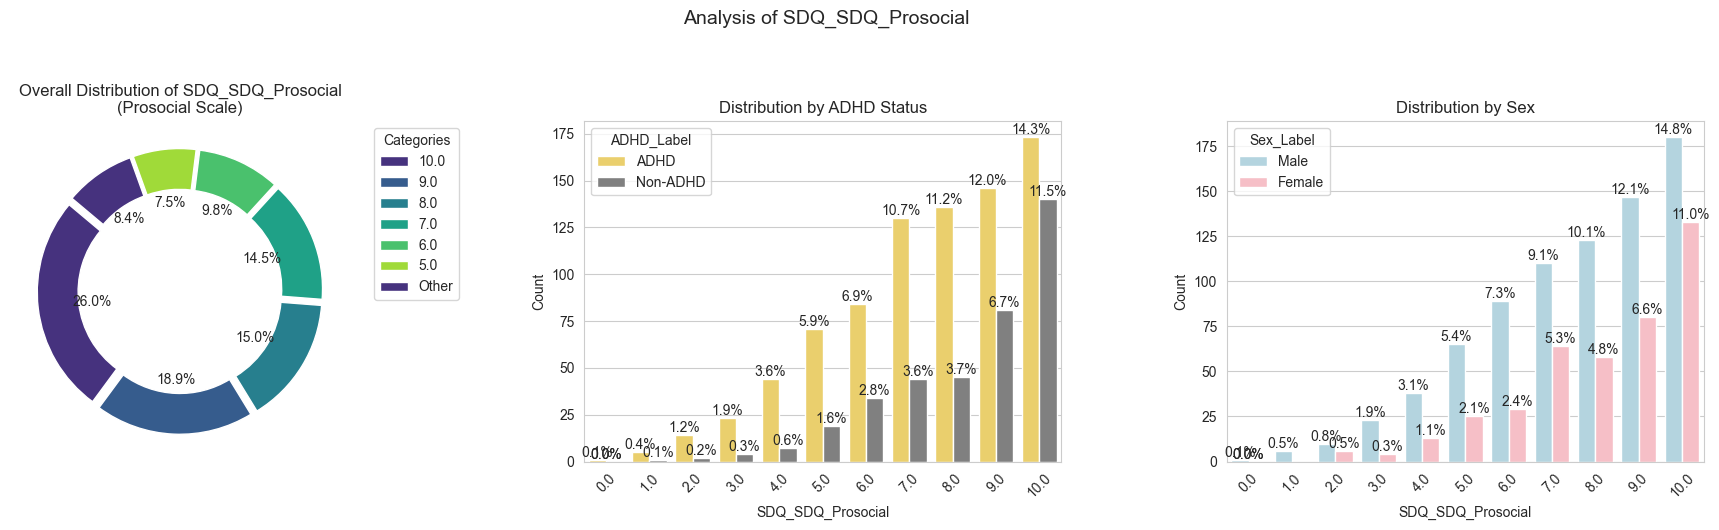


Chi-square Test Results for SDQ_SDQ_Prosocial:
- Association with ADHD: chi2 = 53.78, p = 0.0000
- Association with Sex: chi2 = 27.00, p = 0.0026
--------------------------------------------------


In [111]:
# Define color palettes
adhd_palette = {"Non-ADHD": "grey", "ADHD": "#FFDB58"}
gender_palette = {"Male": "lightblue", "Female": "lightpink"}
pie_palette = sns.color_palette("viridis")  # For pie chart segments

def create_categorical_plots(feature):
    sns.set_style('whitegrid')

    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # ---------------------
    # Plot 1: Overall Pie Chart
    # ---------------------
    value_counts = overall_df[feature].value_counts()
    threshold = 0.05 * value_counts.sum()  # 5% threshold
    filtered_values = value_counts[value_counts >= threshold]
    if value_counts[value_counts < threshold].sum() > 0:
        filtered_values['Other'] = value_counts[value_counts < threshold].sum()

    wedges, texts, autotexts = axes[0].pie(
        filtered_values,
        autopct=lambda p: f'{p:.1f}%' if p > 5 else '',
        colors=pie_palette[:len(filtered_values)],
        startangle=140,
        wedgeprops=dict(width=0.3),
        explode=[0.05] * len(filtered_values),
        textprops={'fontsize': 10}
    )
    
    # Add feature description from data dictionary
    title = f"Overall Distribution of {feature}"
    if feature in dict_df['Field'].values:
        description = dict_df.loc[dict_df['Field'] == feature, 'Description'].values[0]
        title += f"\n({description})"
    axes[0].set_title("\n".join(textwrap.wrap(title, width=50)))
    
    # Add legend
    axes[0].legend(filtered_values.index, 
                  title="Categories",
                  bbox_to_anchor=(1.05, 1),
                  loc='upper left')

    # ---------------------
    # Plot 2: Distribution by ADHD Status
    # ---------------------
    # Create ADHD labels
    overall_df['ADHD_Label'] = overall_df['ADHD_Outcome'].map({0: "Non-ADHD", 1: "ADHD"})
    
    sns.countplot(
        data=overall_df,
        x=feature,
        hue='ADHD_Label',
        palette=adhd_palette,
        ax=axes[1]
    )
    axes[1].set_xlabel(feature)
    axes[1].set_ylabel("Count")
    axes[1].set_title("Distribution by ADHD Status")
    axes[1].tick_params(axis='x', rotation=45)

    # Add percentage annotations
    total = len(overall_df)
    for p in axes[1].patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        axes[1].annotate(percentage,
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom')

    # ---------------------
    # Plot 3: Distribution by Sex
    # ---------------------
    # Create sex labels
    overall_df['Sex_Label'] = overall_df['Sex_F'].map({0: "Male", 1: "Female"})
    
    sns.countplot(
        data=overall_df,
        x=feature,
        hue='Sex_Label',
        palette=gender_palette,
        ax=axes[2]
    )
    axes[2].set_xlabel(feature)
    axes[2].set_ylabel("Count")
    axes[2].set_title("Distribution by Sex")
    axes[2].tick_params(axis='x', rotation=45)

    # Add percentage annotations
    for p in axes[2].patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        axes[2].annotate(percentage,
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom')

    # Adjust layout and display
    plt.suptitle(f"Analysis of {feature}", y=1.05, fontsize=14)
    plt.tight_layout()
    plt.show()

    # Print chi-square test results
    print(f"\nChi-square Test Results for {feature}:")
    # Test association with ADHD
    adhd_ct = pd.crosstab(overall_df[feature], overall_df['ADHD_Label'])
    chi2_adhd, p_adhd = stats.chi2_contingency(adhd_ct)[:2]
    print(f"- Association with ADHD: chi2 = {chi2_adhd:.2f}, p = {p_adhd:.4f}")
    
    # Test association with Sex
    sex_ct = pd.crosstab(overall_df[feature], overall_df['Sex_Label'])
    chi2_sex, p_sex = stats.chi2_contingency(sex_ct)[:2]
    print(f"- Association with Sex: chi2 = {chi2_sex:.2f}, p = {p_sex:.4f}")
    print("-" * 50)

# Perform univariate analysis for each categorical variable
for feature in categorical_variables:
    create_categorical_plots(feature)

# Cleanup: Drop temporary columns
overall_df.drop(['ADHD_Label', 'Sex_Label'], axis=1, inplace=True)

### Target Feature Analysis

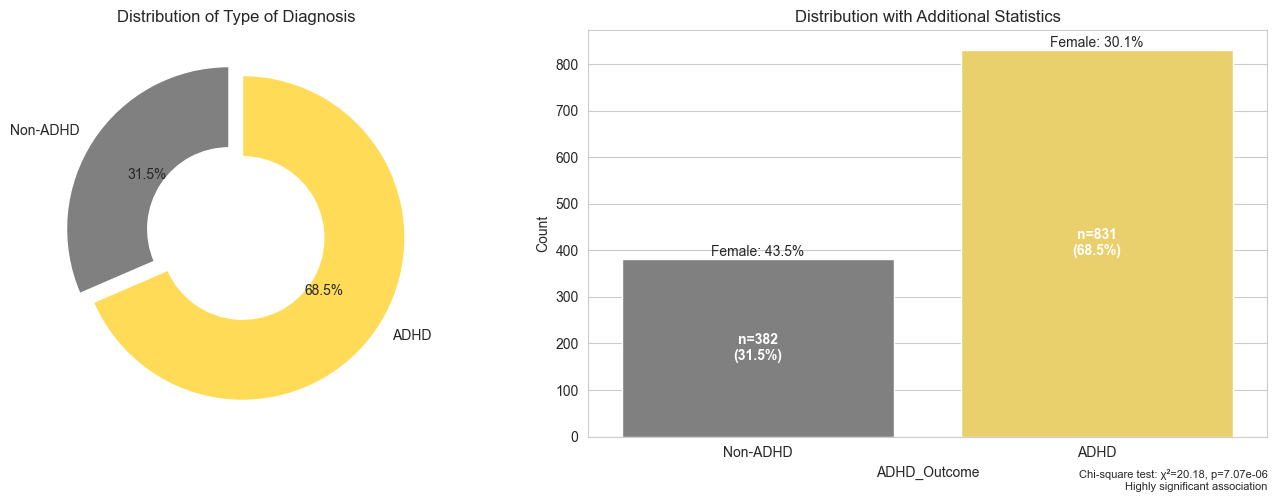


Summary Statistics for ADHD_Outcome:
Total samples: 1213
Non-ADHD: n=382 (31.5%) - Female rate: 43.5%
ADHD: n=831 (68.5%) - Female rate: 30.1%
--------------------------------------------------


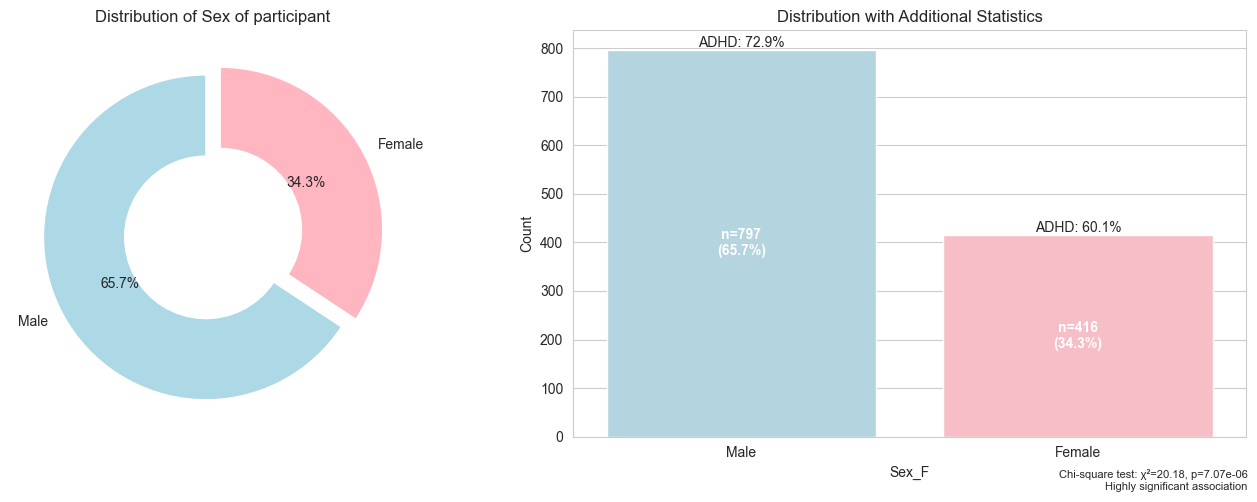


Summary Statistics for Sex_F:
Total samples: 1213
Male: n=797 (65.7%) - ADHD rate: 72.9%
Female: n=416 (34.3%) - ADHD rate: 60.1%
--------------------------------------------------


In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import textwrap
from scipy import stats

# Define color palettes for target variables
sex_color_map = {0: 'lightblue', 1: 'lightpink'}
adhd_color_map = {0: 'grey', 1: '#FFDB58'}

# Labels for better visualization
sex_labels = {0: "Male", 1: "Female"}
adhd_labels = {0: "Non-ADHD", 1: "ADHD"}

def create_categorical_plots(variable):
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Get value counts from overall_df
    value_counts = overall_df[variable].value_counts().sort_index()
    total = len(overall_df)

    # ---------------------
    # Plot 1: Pie Chart
    # ---------------------
    # Set appropriate color map and labels
    if variable == 'Sex_F':
        order = [0, 1]  # Male then Female
        value_counts = value_counts.reindex(order).dropna()
        colors = [sex_color_map[val] for val in order]
        labels = [sex_labels[val] for val in order]
        color_map = sex_color_map
    else:  # ADHD_Outcome
        order = [0, 1]  # Non-ADHD then ADHD
        value_counts = value_counts.reindex(order).dropna()
        colors = [adhd_color_map[val] for val in order]
        labels = [adhd_labels[val] for val in order]
        color_map = adhd_color_map

    wedges, texts, autotexts = axes[0].pie(
        value_counts,
        labels=labels,
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        wedgeprops=dict(width=0.5),
        explode=[0.05] * len(value_counts)
    )

    title_text = dict_df.loc[dict_df['Field'] == variable, 'Description'].values[0] \
                    if variable in dict_df['Field'].values else variable
    axes[0].set_title(f"Distribution of {title_text}")

    # ---------------------
    # Plot 2: Bar Plot with Additional Statistics
    # ---------------------
    # Convert data for plotting
    plot_data = overall_df.copy()
    
    # Create the countplot with integer values
    if variable == 'Sex_F':
        sns.countplot(
            data=plot_data,
            x=variable,
            ax=axes[1],
            order=order,
            palette=[sex_color_map[i] for i in order]  # color for corresponding sex
        )
        axes[1].set_xticklabels(['Male', 'Female'])
    else:  # ADHD_Outcome
        sns.countplot(
            data=plot_data,
            x=variable,
            ax=axes[1],
            order=order,
            palette=[adhd_color_map[i] for i in order]  # color for corresponding adhd outcome
        )
        axes[1].set_xticklabels(['Non-ADHD', 'ADHD'])

        
    # Add specific statistics based on variable type
    if variable == 'Sex_F':
        for i, gender in enumerate(order):
            gender_subset = plot_data[plot_data['Sex_F'] == gender]
            adhd_cases = len(gender_subset[gender_subset['ADHD_Outcome'] == 1])
            adhd_pct = (adhd_cases / len(gender_subset)) * 100
            
            axes[1].text(i, value_counts[gender],
                        f'ADHD: {adhd_pct:.1f}%',
                        ha='center', va='bottom')
        axes[1].set_xticklabels(['Male', 'Female'])
    else:  # ADHD_Outcome
        for i, status in enumerate(order):
            status_subset = plot_data[plot_data['ADHD_Outcome'] == status]
            female_cases = len(status_subset[status_subset['Sex_F'] == 1])
            female_pct = (female_cases / len(status_subset)) * 100
            
            axes[1].text(i, value_counts[status],
                        f'Female: {female_pct:.1f}%',
                        ha='center', va='bottom')
        axes[1].set_xticklabels(['Non-ADHD', 'ADHD'])

    # Add count and percentage labels on bars
    for i, v in enumerate(value_counts):
        axes[1].text(i, v/2, 
                    f'n={v}\n({v/total*100:.1f}%)',
                    ha='center', va='center',
                    color='white',
                    fontweight='bold')

    axes[1].set_ylabel("Count")
    axes[1].set_title("Distribution with Additional Statistics")

    # Add chi-square test result
    contingency_table = pd.crosstab(plot_data['Sex_F'], plot_data['ADHD_Outcome'])
    chi2, p_value = stats.chi2_contingency(contingency_table)[0:2]

    test_result = f'Chi-square test: χ²={chi2:.2f}, p={p_value:.2e}'  # p-value in scientific notation
    if p_value < 0.001:
        test_result += '\nHighly significant association'
    elif p_value < 0.05:
        test_result += '\nSignificant association'
    else:
        test_result += '\nNo significant association'
    
    plt.figtext(0.99, 0.01, 
            test_result,
            ha='right', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\nSummary Statistics for {variable}:")
    print(f"Total samples: {total}")
    for val in order:
        count = value_counts[val]
        pct = count/total*100
        if variable == 'Sex_F':
            label = sex_labels[val]
            subset = plot_data[plot_data['Sex_F'] == val]
            adhd_count = len(subset[subset['ADHD_Outcome'] == 1])
            adhd_pct = (adhd_count / len(subset)) * 100
            print(f"{label}: n={count} ({pct:.1f}%) - ADHD rate: {adhd_pct:.1f}%")
        else:
            label = adhd_labels[val]
            subset = plot_data[plot_data['ADHD_Outcome'] == val]
            female_count = len(subset[subset['Sex_F'] == 1])
            female_pct = (female_count / len(subset)) * 100
            print(f"{label}: n={count} ({pct:.1f}%) - Female rate: {female_pct:.1f}%")
    print("-" * 50)

# Analyze each target variable
for variable in target_variables:
    create_categorical_plots(variable)

### Bivariate Analysis

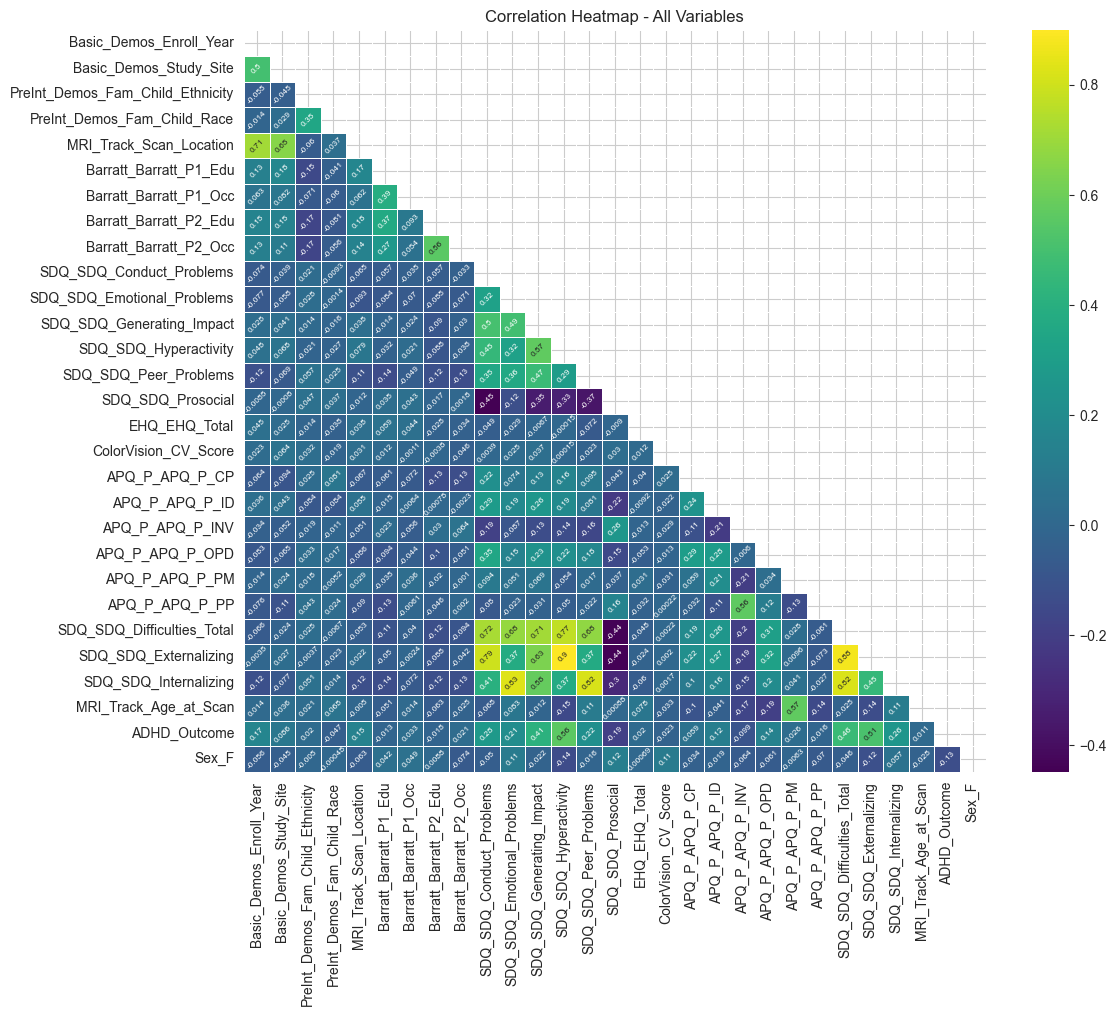


Correlations with target variables:

Correlations with ADHD_Outcome:
ADHD_Outcome                        1.000000
SDQ_SDQ_Hyperactivity               0.558625
SDQ_SDQ_Externalizing               0.514630
SDQ_SDQ_Difficulties_Total          0.464724
SDQ_SDQ_Generating_Impact           0.410349
SDQ_SDQ_Conduct_Problems            0.275598
SDQ_SDQ_Internalizing               0.257269
SDQ_SDQ_Peer_Problems               0.219253
SDQ_SDQ_Emotional_Problems          0.205459
Basic_Demos_Enroll_Year             0.166252
MRI_Track_Scan_Location             0.149623
APQ_P_APQ_P_OPD                     0.141816
APQ_P_APQ_P_ID                      0.124358
Basic_Demos_Study_Site              0.085513
APQ_P_APQ_P_CP                      0.059494
Barratt_Barratt_P1_Occ              0.033428
APQ_P_APQ_P_PM                      0.025983
Barratt_Barratt_P2_Occ              0.020555
PreInt_Demos_Fam_Child_Ethnicity    0.020401
EHQ_EHQ_Total                       0.019770
MRI_Track_Age_at_Scan         

In [113]:
# merge all variable
all_variables = categorical_variables + numerical_variables + target_variables

# calculate correlation matrices
corr_matrix = overall_df[all_variables].corr()

# create masks for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# set the text size and rotation
annot_kws = {"size": 6, "rotation": 45}

# generate heatmaps
plt.figure(figsize=(12, 10))
ax = sns.heatmap(corr_matrix, 
                 mask=mask,
                 cmap='viridis',
                 annot=True,
                 square=True,
                 linewidths=.5,
                 xticklabels=1,
                 yticklabels=1,
                 annot_kws=annot_kws)

plt.title('Correlation Heatmap - All Variables')

plt.tight_layout()
plt.show()

# print the correlations with two outcome variables
print("\nCorrelations with target variables:")
print("\nCorrelations with ADHD_Outcome:")
adhd_corr = corr_matrix['ADHD_Outcome'].sort_values(ascending=False)
print(adhd_corr)

print("\nCorrelations with Sex_F:")
sex_corr = corr_matrix['Sex_F'].sort_values(ascending=False)
print(sex_corr)

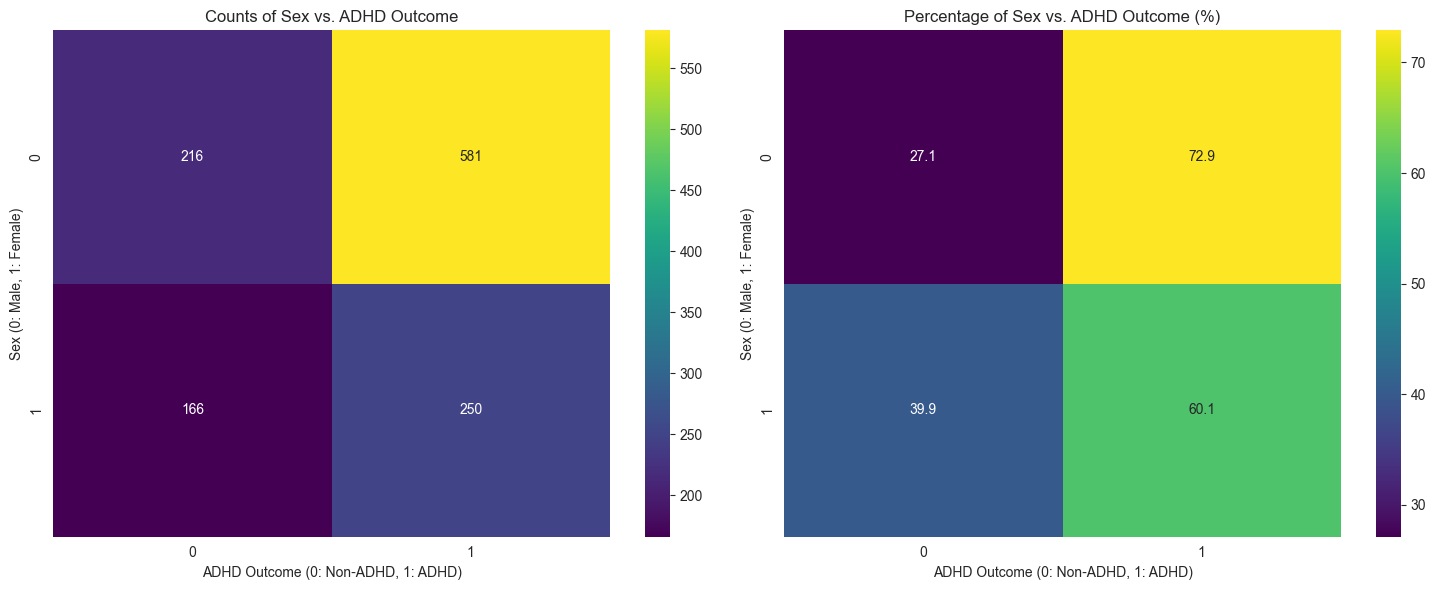


Crosstab Counts:
ADHD_Outcome    0    1
Sex_F                 
0             216  581
1             166  250

Crosstab Percentages (row-wise):
ADHD_Outcome          0          1
Sex_F                             
0             27.101631  72.898369
1             39.903846  60.096154

ADHD Rates by Gender:
Male: 72.9% (581/797)
Female: 60.1% (250/416)


In [114]:
# create a contingency table (crosstab)
crosstab = pd.crosstab(overall_df['Sex_F'], overall_df['ADHD_Outcome'])

# calculate the percentage
crosstab_percent = crosstab.apply(lambda r: r / r.sum() * 100, axis=1)

# plot the heatmap by counts and percentage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(crosstab, 
            annot=True, 
            fmt="d",  
            cmap="viridis",
            ax=ax1)
ax1.set_xlabel("ADHD Outcome (0: Non-ADHD, 1: ADHD)")
ax1.set_ylabel("Sex (0: Male, 1: Female)")
ax1.set_title("Counts of Sex vs. ADHD Outcome")


sns.heatmap(crosstab_percent, 
            annot=True, 
            fmt=".1f",  
            cmap="viridis",
            ax=ax2)
ax2.set_xlabel("ADHD Outcome (0: Non-ADHD, 1: ADHD)")
ax2.set_ylabel("Sex (0: Male, 1: Female)")
ax2.set_title("Percentage of Sex vs. ADHD Outcome (%)")


plt.tight_layout()
plt.show()

# print detailed statiscal number
print("\nCrosstab Counts:")
print(crosstab)
print("\nCrosstab Percentages (row-wise):")
print(crosstab_percent)

print("\nADHD Rates by Gender:")
for sex in [0, 1]:
    gender = "Male" if sex == 0 else "Female"
    total = len(overall_df[overall_df['Sex_F'] == sex])
    adhd_count = len(overall_df[(overall_df['Sex_F'] == sex) & (overall_df['ADHD_Outcome'] == 1)])
    adhd_rate = adhd_count / total * 100
    print(f"{gender}: {adhd_rate:.1f}% ({adhd_count}/{total})")

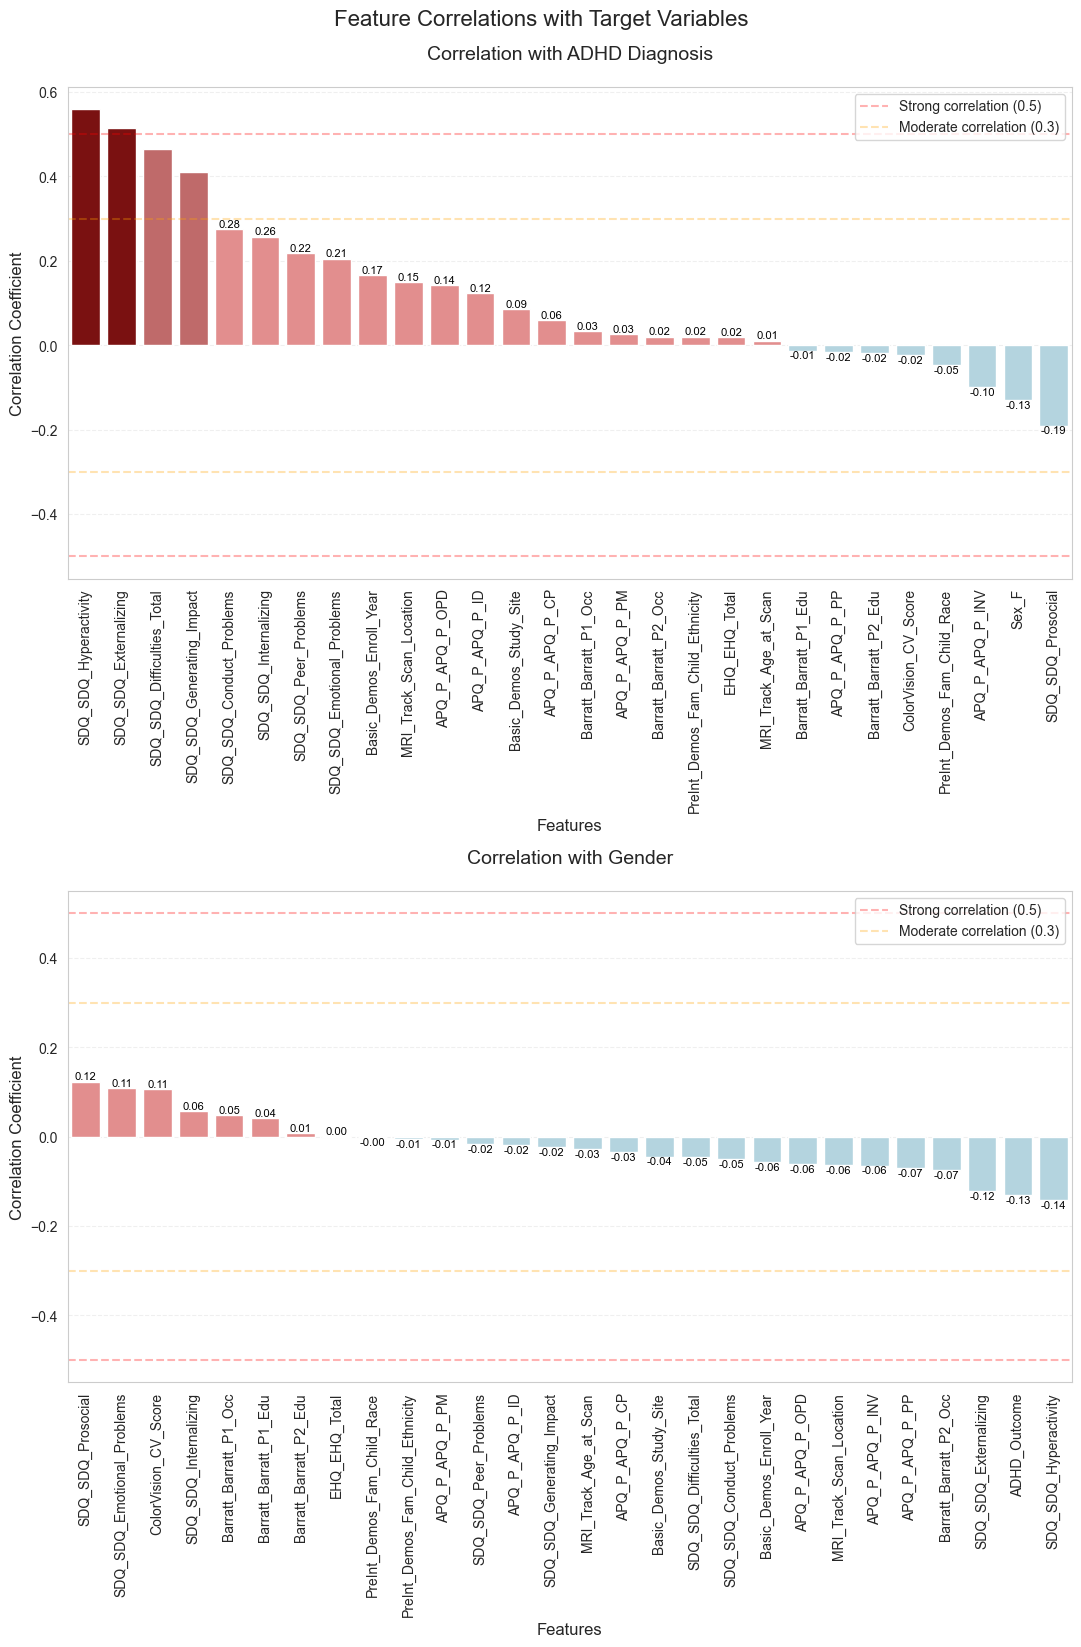

In [115]:
# merge all variables
all_variables = categorical_variables + numerical_variables + target_variables

# calculate correlation matirx
corr_matrix = overall_df[all_variables].corr()[target_variables]

# plot setting
num_targets = len(target_variables)
fig, axs = plt.subplots(num_targets, 1, 
                        figsize=(len(all_variables) * 0.3 + 2, 8 * num_targets), 
                        constrained_layout=True)

if num_targets == 1:
    axs = [axs]

# generate correlation barplot for two target variables
for i, target in enumerate(target_variables):
    # ranking correlation
    sorted_corr = corr_matrix[target].drop(target).sort_values(ascending=False)
    
    colors = []
    for corr in sorted_corr.values:
        if abs(corr) > 0.5:
            colors.append('darkred' if corr > 0 else 'darkblue')  # strong correlation
        elif abs(corr) > 0.3:
            colors.append('indianred' if corr > 0 else 'royalblue')  # medium correlation
        else:
            colors.append('lightcoral' if corr > 0 else 'lightblue')  # weak correlation

    bars = sns.barplot(y=sorted_corr.values, 
                      x=sorted_corr.index, 
                      palette=colors, 
                      ax=axs[i])
    
    # Add a horizontal line to indicate the correlation threshold
    axs[i].axhline(y=0.5, color='red', linestyle='--', alpha=0.3, label='Strong correlation (0.5)')
    axs[i].axhline(y=-0.5, color='red', linestyle='--', alpha=0.3)
    axs[i].axhline(y=0.3, color='orange', linestyle='--', alpha=0.3, label='Moderate correlation (0.3)')
    axs[i].axhline(y=-0.3, color='orange', linestyle='--', alpha=0.3)
    
    
    if target == 'ADHD_Outcome':
        title = "Correlation with ADHD Diagnosis"
    else:
        title = "Correlation with Gender"
    
    axs[i].set_title(title, fontsize=14, pad=20)
    axs[i].set_ylabel("Correlation Coefficient", fontsize=12)
    axs[i].set_xlabel("Features", fontsize=12)
    
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].tick_params(axis='y', labelsize=10)
    
    axs[i].grid(True, axis='y', linestyle='--', alpha=0.3)
    axs[i].legend()
    
    for j, bar in enumerate(bars.patches):
        value = sorted_corr.values[j]
        text_color = 'white' if abs(value) > 0.3 else 'black'
        bars.text(j, value, 
                 f'{value:.2f}', 
                 ha='center', 
                 va='bottom' if value >= 0 else 'top',
                 color=text_color,
                 fontsize=8)

plt.suptitle("Feature Correlations with Target Variables", fontsize=16, y=1.02)
plt.show()

# print features with strong correlation

# print("\nStrong correlations (|correlation| > 0.3):")
# for target in target_variables:
#     print(f"\nFor {target}:")
#     sorted_corr = corr_matrix[target].drop(target).sort_values(key=abs, ascending=False)
#     strong_corr = sorted_corr[abs(sorted_corr) > 0.3]
#     for feat, corr in strong_corr.items():
#         print(f"{feat}: {corr:.3f}")

# Descriptive Analysis

## Question 1

“What is the distribution of participants by key demographics (e.g., study site, ethnicity, race，sex)? Show counts and percentages in bar charts or tables.”

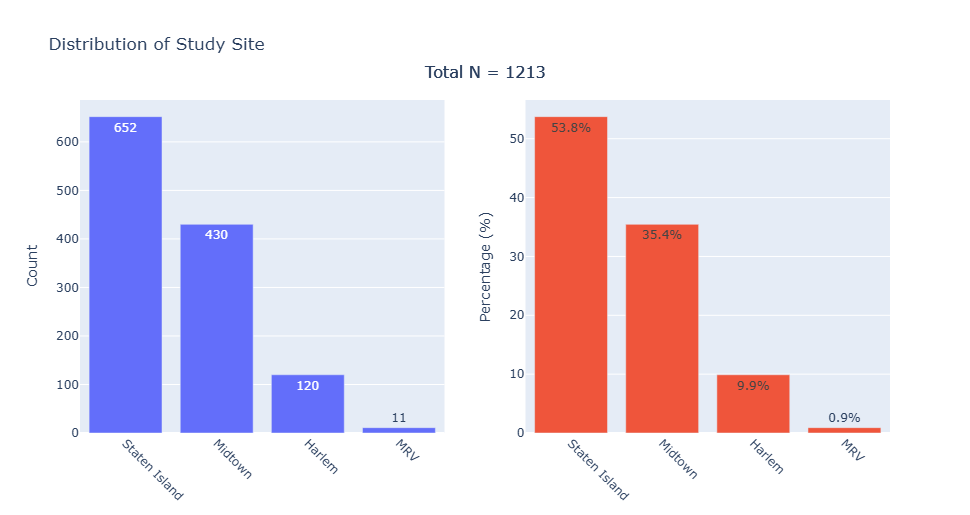


Detailed statistics for Study Site:
     Category  Count  Percentage
Staten Island    652        53.8
      Midtown    430        35.4
       Harlem    120         9.9
          MRV     11         0.9
--------------------------------------------------


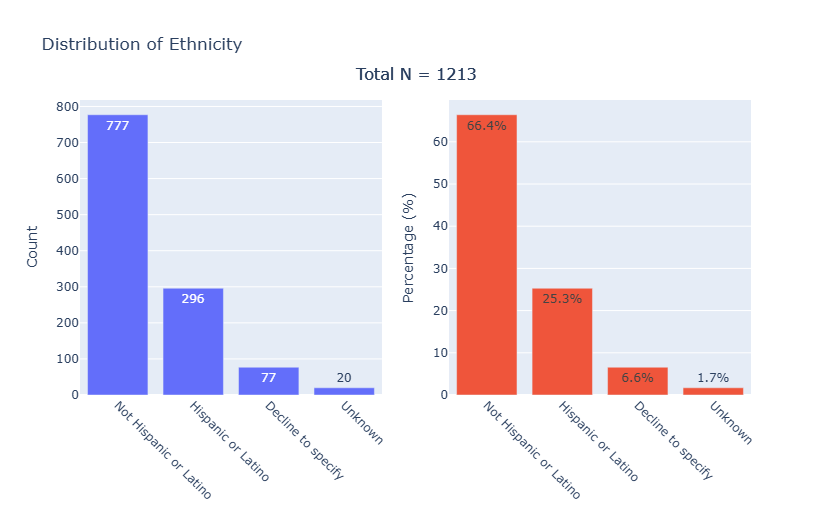


Detailed statistics for Ethnicity:
              Category  Count  Percentage
Not Hispanic or Latino    777        66.4
    Hispanic or Latino    296        25.3
    Decline to specify     77         6.6
               Unknown     20         1.7
--------------------------------------------------


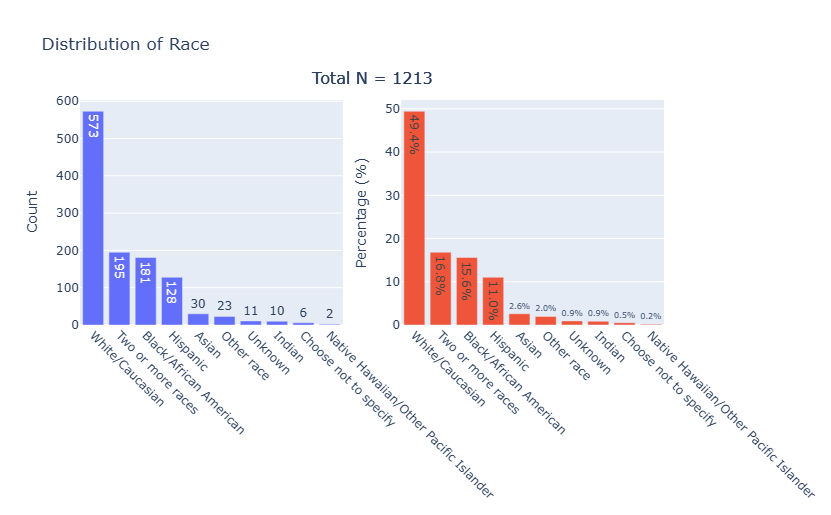


Detailed statistics for Race:
                              Category  Count  Percentage
                       White/Caucasian    573        49.4
                     Two or more races    195        16.8
                Black/African American    181        15.6
                              Hispanic    128        11.0
                                 Asian     30         2.6
                            Other race     23         2.0
                               Unknown     11         0.9
                                Indian     10         0.9
                 Choose not to specify      6         0.5
Native Hawaiian/Other Pacific Islander      2         0.2
--------------------------------------------------


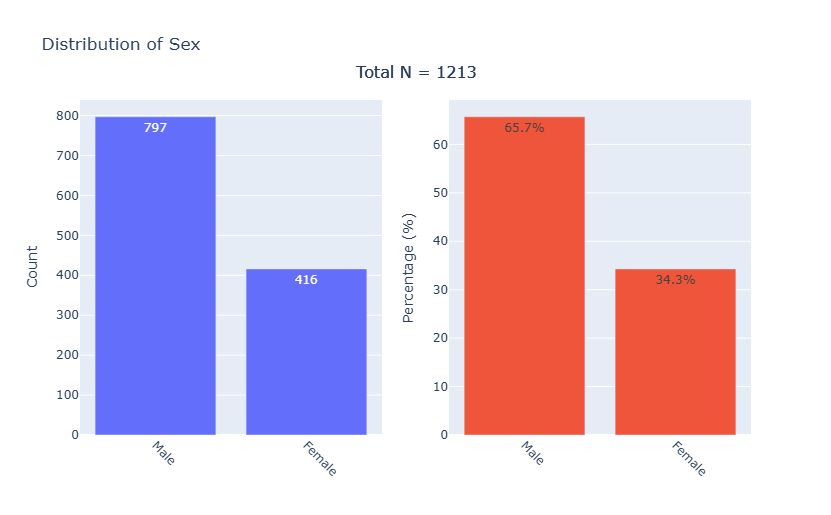


Detailed statistics for Sex:
Category  Count  Percentage
    Male    797        65.7
  Female    416        34.3
--------------------------------------------------

Summary of Demographic Distributions:
  Variable                               Category  Count  Percentage
Study Site                          Staten Island    652        53.8
Study Site                                Midtown    430        35.4
Study Site                                 Harlem    120         9.9
Study Site                                    MRV     11         0.9
 Ethnicity                 Not Hispanic or Latino    777        66.4
 Ethnicity                     Hispanic or Latino    296        25.3
 Ethnicity                     Decline to specify     77         6.6
 Ethnicity                                Unknown     20         1.7
      Race                        White/Caucasian    573        49.4
      Race                      Two or more races    195        16.8
      Race                 Black/Afri

In [92]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# mapping labels
site_labels = {
    1: 'Staten Island',
    2: 'MRV',
    3: 'Midtown',
    4: 'Harlem',
    5: 'SI RUMC'
}

ethnicity_labels = {
    0: 'Not Hispanic or Latino',
    1: 'Hispanic or Latino',
    2: 'Decline to specify',
    3: 'Unknown'
}

race_labels = {
    0: 'White/Caucasian',
    1: 'Black/African American',
    2: 'Hispanic',
    3: 'Asian',
    4: 'Indian',
    5: 'Native American Indian',
    6: 'American Indian/Alaskan Native',
    7: 'Native Hawaiian/Other Pacific Islander',
    8: 'Two or more races',
    9: 'Other race',
    10: 'Unknown',
    11: 'Choose not to specify'
}

sex_labels = {
    0: 'Male',
    1: 'Female'
}

def plot_demographic_distribution(data, column, labels, title):
    
    data_labeled = data[column].map(labels)

    value_counts = data_labeled.value_counts()
    percentages = data_labeled.value_counts(normalize=True) * 100
    
    
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=(f'Counts of {title}', f'Percentage of {title}'),
        specs=[[{"type": "bar"}, {"type": "bar"}]]
    )
    
    # count bar chart
    fig.add_trace(
        go.Bar(
            x=value_counts.index,
            y=value_counts.values,
            text=value_counts.values,
            textposition='auto',
            name='Count',
            hovertemplate="Category: %{x}<br>Count: %{y}<extra></extra>"
        ),
        row=1, col=1
    )
    
    # percentage bar chart
    fig.add_trace(
        go.Bar(
            x=percentages.index,
            y=percentages.values,
            text=[f'{val:.1f}%' for val in percentages.values],
            textposition='auto',
            name='Percentage',
            hovertemplate="Category: %{x}<br>Percentage: %{text}<extra></extra>"
        ),
        row=1, col=2
    )
    
    
    fig.update_layout(
        title_text=f"Distribution of {title}",
        showlegend=False,
        height=500,
        width=1200,
        # annotations for total sample size
        annotations=[
            dict(
                text=f"Total N = {len(data)}",
                xref="paper",
                yref="paper",
                x=0.5,
                y=1.05,
                showarrow=False
            )
        ]
    )
    
    fig.update_xaxes(tickangle=45)
    fig.update_yaxes(title_text="Count", row=1, col=1)
    fig.update_yaxes(title_text="Percentage (%)", row=1, col=2)
    
    fig.show()
    fig.write_html(f"demographic_{column}.html")
    
    # print detailed info
    print(f"\nDetailed statistics for {title}:")
    stats_df = pd.DataFrame({
        'Category': value_counts.index,
        'Count': value_counts.values,
        'Percentage': percentages.values.round(1)
    })
    print(stats_df.to_string(index=False))
    print("-" * 50)

# label for variables to be analyzed
demographics = {
    'Basic_Demos_Study_Site': ('Study Site', site_labels),
    'PreInt_Demos_Fam_Child_Ethnicity': ('Ethnicity', ethnicity_labels),
    'PreInt_Demos_Fam_Child_Race': ('Race', race_labels),
    'Sex_F': ('Sex', sex_labels)
}

# generate distribution chart for each demographic variables
for var, (title, labels) in demographics.items():
    plot_demographic_distribution(overall_df, var, labels, title)

print("\nSummary of Demographic Distributions:")
summary_table = pd.DataFrame()

for var, (title, labels) in demographics.items():
    labeled_data = overall_df[var].map(labels)
    counts = labeled_data.value_counts()
    percentages = labeled_data.value_counts(normalize=True) * 100
    
    var_summary = pd.DataFrame({
        'Variable': title,
        'Category': counts.index,
        'Count': counts.values,
        'Percentage': percentages.values.round(1)
    })
    summary_table = pd.concat([summary_table, var_summary])

print(summary_table.to_string(index=False))

# check missing value
print("\nMissing Values Analysis:")
missing_data = overall_df[list(demographics.keys())].isnull().sum()
if missing_data.any():
    missing_df = pd.DataFrame({
        'Variable': missing_data.index,
        'Missing Count': missing_data.values,
        'Missing Percentage': (missing_data.values / len(overall_df) * 100).round(1)
    })
    print(missing_df[missing_df['Missing Count'] > 0].to_string(index=False))
else:
    print("No missing values found in demographic variables.")

## Question 2

Are there significant differences in ADHD diagnosis outcomes between males and females?

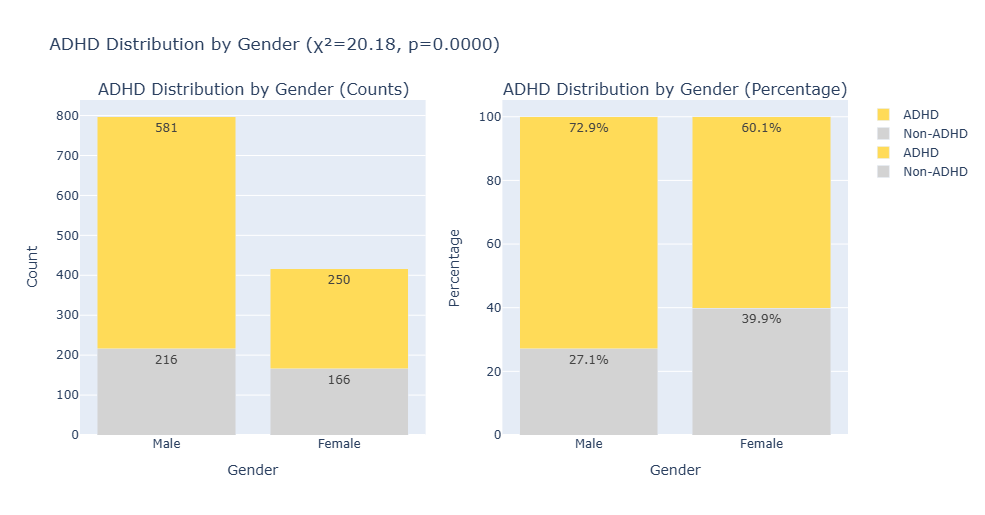


Detailed Statistics:

1. Contingency Table (Counts):
        Non-ADHD  ADHD
Male         NaN   NaN
Female       NaN   NaN

2. Distribution within Each Gender:

Male:
Non-ADHD: 216 (27.1%)
ADHD: 581 (72.9%)

Female:
Non-ADHD: 166 (39.9%)
ADHD: 250 (60.1%)

3. Statistical Test Results:
Chi-square statistic: 20.18
p-value: 0.0000
Conclusion: There is a significant association between gender and ADHD diagnosis
Effect size (Cramer's V): 0.129
The association has a small effect size


In [93]:
import pandas as pd
import numpy as np
from scipy import stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def analyze_adhd_gender_distribution():
    
    
    # gender-ADHD crosstab
    contingency_table = pd.crosstab(overall_df['Sex_F'], overall_df['ADHD_Outcome'])
    gender_percentages = pd.crosstab(overall_df['Sex_F'], 
                                   overall_df['ADHD_Outcome'], 
                                   normalize='index') * 100
    
    # chi-square test
    chi2, p_value = stats.chi2_contingency(contingency_table)[:2]
    
    fig = make_subplots(rows=1, cols=2,
                       subplot_titles=('ADHD Distribution by Gender (Counts)',
                                     'ADHD Distribution by Gender (Percentage)'))

    colors = ['lightgrey', '#FFDB58']
    gender_labels = ['Male', 'Female']
    
    # count stacked column chart
    fig.add_trace(
        go.Bar(name='Non-ADHD', x=gender_labels, 
               y=contingency_table[0], 
               marker_color=colors[0],
               text=contingency_table[0],
               textposition='inside'),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Bar(name='ADHD', x=gender_labels, 
               y=contingency_table[1], 
               marker_color=colors[1],
               text=contingency_table[1],
               textposition='inside'),
        row=1, col=1
    )
    
    # percentage stacked column chart
    fig.add_trace(
        go.Bar(name='Non-ADHD', x=gender_labels, 
               y=gender_percentages[0], 
               marker_color=colors[0],
               text=[f'{val:.1f}%' for val in gender_percentages[0]],
               textposition='inside'),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Bar(name='ADHD', x=gender_labels, 
               y=gender_percentages[1], 
               marker_color=colors[1],
               text=[f'{val:.1f}%' for val in gender_percentages[1]],
               textposition='inside'),
        row=1, col=2
    )
    

    fig.update_layout(
        barmode='stack',
        height=500,
        width=1000,
        showlegend=True,
        title_text=f"ADHD Distribution by Gender (χ²={chi2:.2f}, p={p_value:.4f})"
    )
    
    fig.update_xaxes(title_text="Gender", row=1, col=1)
    fig.update_xaxes(title_text="Gender", row=1, col=2)
    fig.update_yaxes(title_text="Count", row=1, col=1)
    fig.update_yaxes(title_text="Percentage", row=1, col=2)
    
    fig.show()
    fig.write_html("adhd_gender_distribution.html")
    
    print("\nDetailed Statistics:")
    print("\n1. Contingency Table (Counts):")
    print(pd.DataFrame(contingency_table, 
                      index=['Male', 'Female'],
                      columns=['Non-ADHD', 'ADHD']))
    
    print("\n2. Distribution within Each Gender:")
    print("\nMale:")
    male_total = contingency_table.loc[0].sum()
    for status in [0, 1]:
        count = contingency_table.loc[0, status]
        percentage = (count / male_total) * 100
        status_label = 'Non-ADHD' if status == 0 else 'ADHD'
        print(f"{status_label}: {count} ({percentage:.1f}%)")
    
    print("\nFemale:")
    female_total = contingency_table.loc[1].sum()
    for status in [0, 1]:
        count = contingency_table.loc[1, status]
        percentage = (count / female_total) * 100
        status_label = 'Non-ADHD' if status == 0 else 'ADHD'
        print(f"{status_label}: {count} ({percentage:.1f}%)")
    
    print("\n3. Statistical Test Results:")
    print(f"Chi-square statistic: {chi2:.2f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("Conclusion: There is a significant association between gender and ADHD diagnosis")
    
        # Cramer's V
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        cramer_v = np.sqrt(chi2 / (n * min_dim))
        print(f"Effect size (Cramer's V): {cramer_v:.3f}")
        
        if cramer_v < 0.1:
            effect = "negligible"
        elif cramer_v < 0.3:
            effect = "small"
        elif cramer_v < 0.5:
            effect = "moderate"
        else:
            effect = "large"
        print(f"The association has a {effect} effect size")
    else:
        print("Conclusion: There is no significant association between gender and ADHD diagnosis")

analyze_adhd_gender_distribution()

## Question 3

How are the scores on each dimension of the APQ questionnaire distributed across different genders and ADHD diagnostic groups?

1. Overall Distribution Pattern
Scores for all dimensions showed a relatively normal distribution.
While differences between groups existed, there was significant overall overlap.
The score ranges and variability for each dimension varied, reflecting the prevalence of different parenting behaviors.
2. Analysis by Dimension
Positive Dimension:
Parent Involvement (INV)
Overall scores were high, indicating that parents in the sample were generally involved.
Gender differences were not significant.
Small differences were observed between the ADHD and non-ADHD groups.
Positive Monitoring (PM)
Scores were relatively concentrated.
Slightly lower in the ADHD group than in the non-ADHD group.
Gender differences were not significant.
Positive Parenting (PP)
Overall scores were high.
Slightly higher in the non-ADHD group.
No significant differences were observed between girls and boys.
Negative Dimension:
Corporal Punishment (CP)
Overall scores were low, indicating that corporal punishment was not a common disciplinary practice.
Significantly higher scores were observed in the ADHD group than in the non-ADHD group.
Boys were more likely to experience corporal punishment than girls.
Inconsistent Discipline (ID) Inconsistent Discipline)
The ADHD group was significantly higher than the non-ADHD group.
Gender differences were relatively small.
The distribution was relatively dispersed, indicating a wide variation in discipline consistency.
Other Discipline Practices (OPD)
The score distribution was relatively even.
There were slight differences between the ADHD and non-ADHD groups.
Gender differences were not significant.
3. Key Findings
ADHD-Related Differences:
Negative parenting behaviors (e.g., corporal punishment, inconsistent discipline) were more common in families of individuals with ADHD.
Positive parenting behaviors were slightly higher in the non-ADHD group.
This pattern of differences was present in both genders.
Gender Differences:
Overall, gender differences were less pronounced than those based on ADHD status.
Boys may experience more negative parenting behaviors (e.g., corporal punishment).
Gender differences in positive parenting behaviors were smaller.
Interaction Effects:
Certain parenting behaviors (e.g., corporal punishment) were most prevalent in boys with ADHD.
Positive parenting behaviors were slightly higher in girls without ADHD.

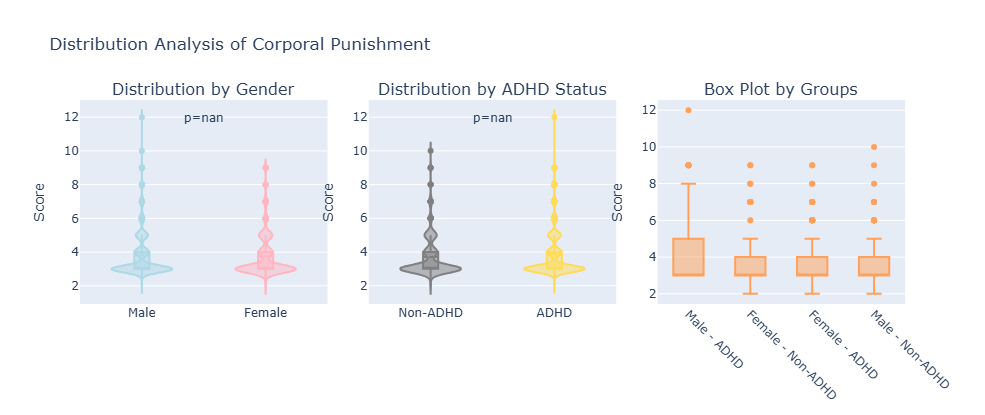


Statistical Analysis for Corporal Punishment:

Descriptive Statistics:
                    count  mean   std  min   max
Gender ADHD_Status                              
Female ADHD           247  3.75  1.22  2.0   9.0
       Non-ADHD       163  3.76  1.28  2.0   9.0
Male   ADHD           578  3.92  1.43  3.0  12.0
       Non-ADHD       213  3.66  1.19  2.0  10.0

Gender Difference (ANOVA):
F-statistic: nan, p-value: nan

ADHD Status Difference (ANOVA):
F-statistic: nan, p-value: nan
--------------------------------------------------


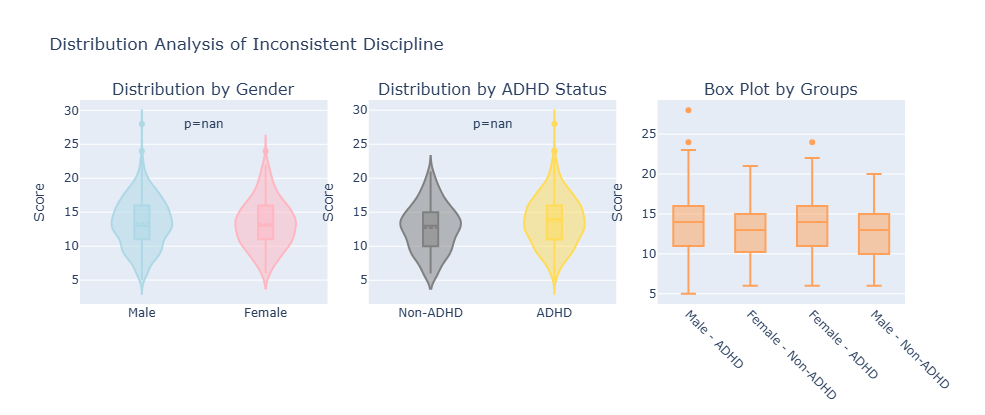


Statistical Analysis for Inconsistent Discipline:

Descriptive Statistics:
                    count   mean   std  min   max
Gender ADHD_Status                               
Female ADHD           247  13.49  3.64  6.0  24.0
       Non-ADHD       163  12.87  3.35  6.0  21.0
Male   ADHD           578  13.70  3.60  5.0  28.0
       Non-ADHD       213  12.53  3.57  6.0  20.0

Gender Difference (ANOVA):
F-statistic: nan, p-value: nan

ADHD Status Difference (ANOVA):
F-statistic: nan, p-value: nan
--------------------------------------------------


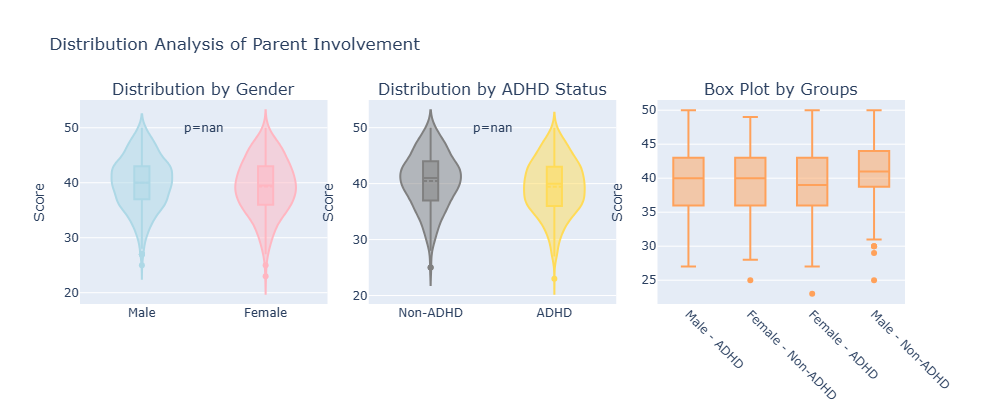


Statistical Analysis for Parent Involvement:

Descriptive Statistics:
                    count   mean   std   min   max
Gender ADHD_Status                                
Female ADHD           247  39.04  5.20  23.0  50.0
       Non-ADHD       163  39.78  4.75  25.0  49.0
Male   ADHD           578  39.61  4.70  27.0  50.0
       Non-ADHD       213  41.02  4.84  25.0  50.0

Gender Difference (ANOVA):
F-statistic: nan, p-value: nan

ADHD Status Difference (ANOVA):
F-statistic: nan, p-value: nan
--------------------------------------------------


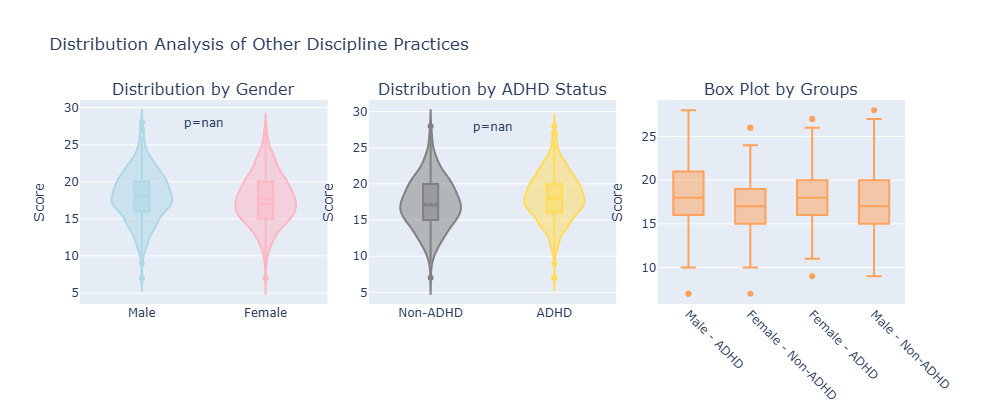


Statistical Analysis for Other Discipline Practices:

Descriptive Statistics:
                    count   mean   std  min   max
Gender ADHD_Status                               
Female ADHD           247  17.91  3.32  9.0  27.0
       Non-ADHD       163  17.33  3.28  7.0  26.0
Male   ADHD           578  18.44  3.21  7.0  28.0
       Non-ADHD       213  17.22  3.52  9.0  28.0

Gender Difference (ANOVA):
F-statistic: nan, p-value: nan

ADHD Status Difference (ANOVA):
F-statistic: nan, p-value: nan
--------------------------------------------------


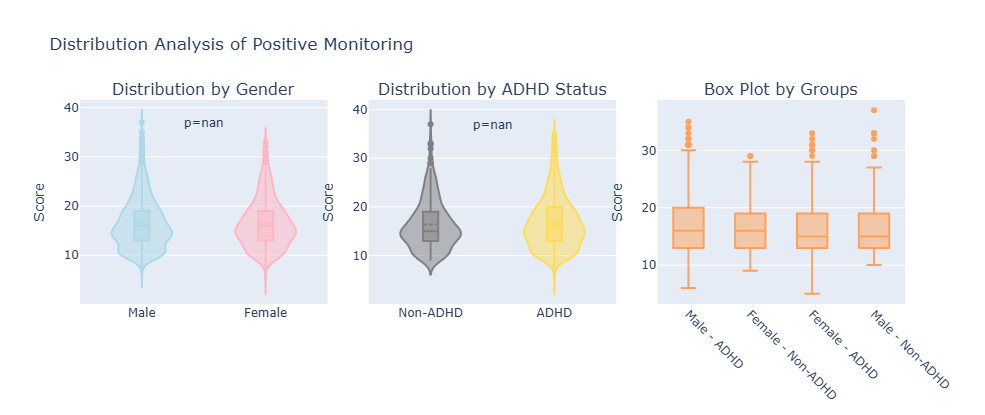


Statistical Analysis for Positive Monitoring:

Descriptive Statistics:
                    count   mean   std   min   max
Gender ADHD_Status                                
Female ADHD           247  16.58  5.14   5.0  33.0
       Non-ADHD       163  16.41  4.60   9.0  29.0
Male   ADHD           578  16.68  5.23   6.0  35.0
       Non-ADHD       213  16.32  5.34  10.0  37.0

Gender Difference (ANOVA):
F-statistic: nan, p-value: nan

ADHD Status Difference (ANOVA):
F-statistic: nan, p-value: nan
--------------------------------------------------


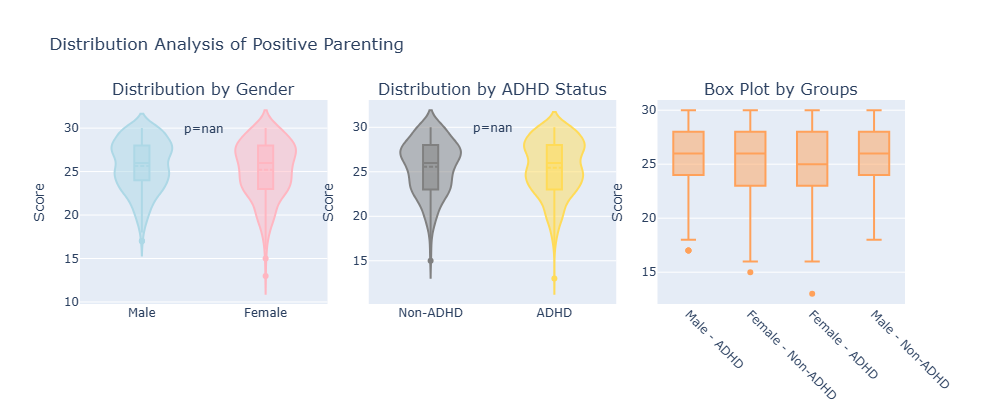


Statistical Analysis for Positive Parenting:

Descriptive Statistics:
                    count   mean   std   min   max
Gender ADHD_Status                                
Female ADHD           247  25.09  3.39  13.0  30.0
       Non-ADHD       163  25.36  3.00  15.0  30.0
Male   ADHD           578  25.63  2.95  17.0  30.0
       Non-ADHD       213  25.73  2.94  18.0  30.0

Gender Difference (ANOVA):
F-statistic: nan, p-value: nan

ADHD Status Difference (ANOVA):
F-statistic: nan, p-value: nan
--------------------------------------------------


In [122]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from scipy import stats

apq_dimensions = {
    'APQ_P_APQ_P_CP': 'Corporal Punishment',
    'APQ_P_APQ_P_ID': 'Inconsistent Discipline',
    'APQ_P_APQ_P_INV': 'Parent Involvement',
    'APQ_P_APQ_P_OPD': 'Other Discipline Practices',
    'APQ_P_APQ_P_PM': 'Positive Monitoring',
    'APQ_P_APQ_P_PP': 'Positive Parenting'
}

def analyze_apq_distributions():
    
    
    df = overall_df.copy()
    df['Gender'] = df['Sex_F'].map({0: 'Male', 1: 'Female'})
    df['ADHD_Status'] = df['ADHD_Outcome'].map({0: 'Non-ADHD', 1: 'ADHD'})
    df['Group'] = df['Gender'] + ' - ' + df['ADHD_Status']
    
    for var, description in apq_dimensions.items():
        fig = make_subplots(
            rows=1, cols=3,
            subplot_titles=(
                'Distribution by Gender',
                'Distribution by ADHD Status',
                'Box Plot by Groups'
            ),
            horizontal_spacing=0.05
        )
        
        # distribution by gender-left violin plot
        for gender in ['Male', 'Female']:
            fig.add_trace(
                go.Violin(
                    x=[gender] * len(df[df['Gender'] == gender]),
                    y=df[df['Gender'] == gender][var],
                    name=gender,
                    box_visible=True,
                    meanline_visible=True,
                    line_color='lightblue' if gender == 'Male' else 'lightpink'
                ),
                row=1, col=1
            )
            
        # distribution by ADHD outcome - middle violin plot
        for status in ['Non-ADHD', 'ADHD']:
            fig.add_trace(
                go.Violin(
                    x=[status] * len(df[df['ADHD_Status'] == status]),
                    y=df[df['ADHD_Status'] == status][var],
                    name=status,
                    box_visible=True,
                    meanline_visible=True,
                    line_color='grey' if status == 'Non-ADHD' else '#FFDB58'
                ),
                row=1, col=2
            )
            
        # distribution by group - right boxplot
        fig.add_trace(
            go.Box(
                x=df['Group'],
                y=df[var],
                name='Groups'
            ),
            row=1, col=3
        )
        
        # statistical test result
        f_stat_gender, p_val_gender = stats.f_oneway(
            df[df['Gender'] == 'Male'][var],
            df[df['Gender'] == 'Female'][var]
        )
        
        f_stat_adhd, p_val_adhd = stats.f_oneway(
            df[df['ADHD_Status'] == 'Non-ADHD'][var],
            df[df['ADHD_Status'] == 'ADHD'][var]
        )
        
        # p-value
        fig.add_annotation(
            text=f"p={p_val_gender:.3f}",
            xref="x1", yref="y1",
            x=0.5, y=df[var].max(),
            showarrow=False,
            row=1, col=1
        )
        
        fig.add_annotation(
            text=f"p={p_val_adhd:.3f}",
            xref="x2", yref="y2",
            x=0.5, y=df[var].max(),
            showarrow=False,
            row=1, col=2
        )
        
        fig.update_layout(
            height=400,  
            width=1500,  
            title_text=f"Distribution Analysis of {description}",
            showlegend=False
        )
        
        
        fig.update_yaxes(title_text="Score", row=1, col=1)
        fig.update_yaxes(title_text="Score", row=1, col=2)
        fig.update_yaxes(title_text="Score", row=1, col=3)
        fig.update_xaxes(tickangle=45, row=1, col=3)
        
        fig.show()
        fig.write_html(f"apq_{var}_distribution.html")
        
        print(f"\nStatistical Analysis for {description}:")
        
        print("\nDescriptive Statistics:")
        stats_df = df.groupby(['Gender', 'ADHD_Status'])[var].agg([
            'count', 'mean', 'std', 'min', 'max'
        ]).round(2)
        print(stats_df)
        print(f"\nGender Difference (ANOVA):")
        print(f"F-statistic: {f_stat_gender:.2f}, p-value: {p_val_gender:.4f}")
        print(f"\nADHD Status Difference (ANOVA):")
        print(f"F-statistic: {f_stat_adhd:.2f}, p-value: {p_val_adhd:.4f}")
        print("-" * 50)

analyze_apq_distributions()

## Question 4

What are the distribution characteristics of the Difficulties Total, Externalizing, and Internalizing scores in the SDQ questionnaire across different genders and ADHD diagnostic groups?

1. Total Difficulties Score
Overall Distribution Characteristics:
The score range was wide, indicating significant variability in the severity of children's behavioral problems within the sample.
The distribution was right-skewed, indicating that most children had milder problems.
ADHD Difference (p < 0.001, large effect size):
The total difficulties score was significantly higher in the ADHD group than in the non-ADHD group.
The score distribution in the ADHD group was more dispersed, indicating heterogeneity in symptom presentation.
This difference has strong practical significance and supports the value of the SDQ as an ADHD screening tool.
Gender Difference (small effect size):
Boys had slightly higher total difficulties scores than girls, but this difference was not as significant as the effect of ADHD status.
2. Externalizing Problems
ADHD Association (p < 0.001, (Maximum effect size):
The ADHD group showed significantly higher externalizing behavior scores.
The distributions were almost completely separated, indicating that externalizing behavior is a key feature of ADHD.
This strong association supports the importance of externalizing behavior as a diagnostic indicator for ADHD.
Gender pattern:
Boys generally scored higher on externalizing behavior than girls.
Gender differences were more pronounced in the ADHD group.
This may explain why boys are more likely to be diagnosed with ADHD.
3. Internalizing Problems
Overall characteristics:
The score distribution was relatively even.
Compared to externalizing behavior, group differences were smaller.
Gender difference (medium effect size):
Girls showed more internalizing behavior problems.
This difference was present in both the ADHD and non-ADHD groups.
ADHD effect (small to medium effect size):
Internalizing problems were slightly higher in the ADHD group than in the non-ADHD group.
However, the difference was less pronounced than for externalizing behavior.

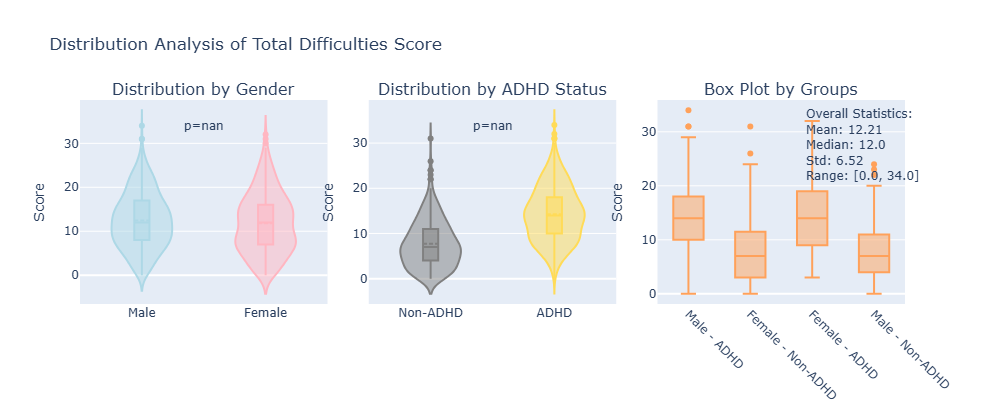


Detailed Statistical Analysis for Total Difficulties Score:

Overall Statistics:
mean      12.21
median    12.00
std        6.52
min        0.00
max       34.00
Name: SDQ_SDQ_Difficulties_Total, dtype: float64

Group Statistics:
                    count   mean   std
Gender ADHD_Status                    
Female ADHD           248  14.43  6.11
       Non-ADHD       164   7.83  5.85
Male   ADHD           579  14.18  5.94
       Non-ADHD       213   7.65  4.77

Statistical Tests:
Gender Difference (ANOVA):
F-statistic: nan, p-value: nan

ADHD Status Difference (ANOVA):
F-statistic: nan, p-value: nan

Effect Sizes (Cohen's d):
Gender effect: 0.10
ADHD effect: 1.13
--------------------------------------------------


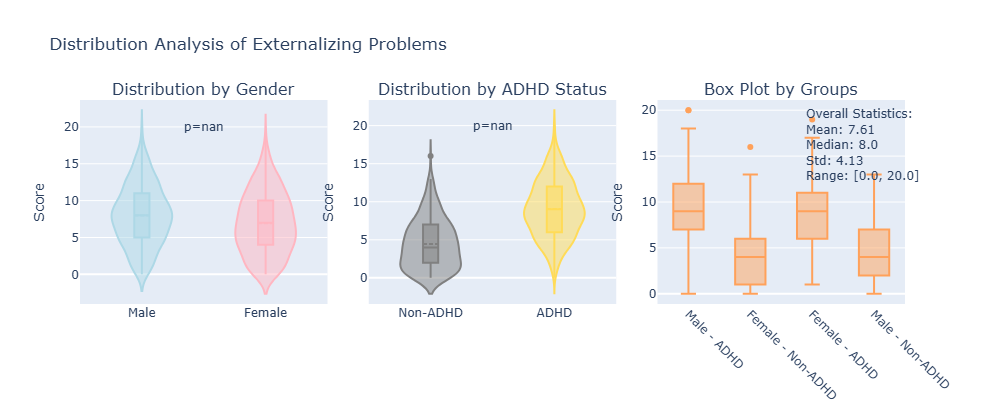


Detailed Statistical Analysis for Externalizing Problems:

Overall Statistics:
mean       7.61
median     8.00
std        4.13
min        0.00
max       20.00
Name: SDQ_SDQ_Externalizing, dtype: float64

Group Statistics:
                    count  mean   std
Gender ADHD_Status                   
Female ADHD           248  8.67  3.64
       Non-ADHD       164  4.29  3.45
Male   ADHD           579  9.21  3.68
       Non-ADHD       213  4.61  3.06

Statistical Tests:
Gender Difference (ANOVA):
F-statistic: nan, p-value: nan

ADHD Status Difference (ANOVA):
F-statistic: nan, p-value: nan

Effect Sizes (Cohen's d):
Gender effect: 0.26
ADHD effect: 1.29
--------------------------------------------------


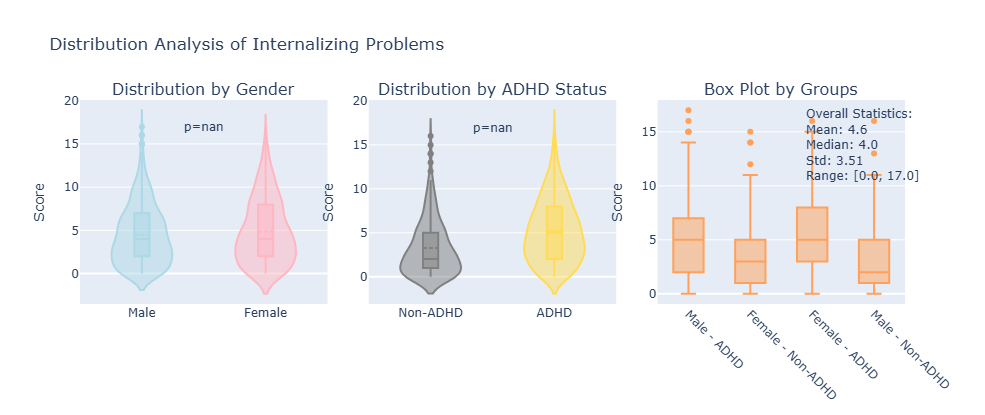


Detailed Statistical Analysis for Internalizing Problems:

Overall Statistics:
mean       4.60
median     4.00
std        3.51
min        0.00
max       17.00
Name: SDQ_SDQ_Internalizing, dtype: float64

Group Statistics:
                    count  mean   std
Gender ADHD_Status                   
Female ADHD           248  5.76  3.64
       Non-ADHD       164  3.54  3.34
Male   ADHD           579  4.97  3.45
       Non-ADHD       213  3.05  2.87

Statistical Tests:
Gender Difference (ANOVA):
F-statistic: nan, p-value: nan

ADHD Status Difference (ANOVA):
F-statistic: nan, p-value: nan

Effect Sizes (Cohen's d):
Gender effect: -0.12
ADHD effect: 0.57
--------------------------------------------------


In [124]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from scipy import stats

sdq_dimensions = {
    'SDQ_SDQ_Difficulties_Total': 'Total Difficulties Score',
    'SDQ_SDQ_Externalizing': 'Externalizing Problems',
    'SDQ_SDQ_Internalizing': 'Internalizing Problems'
}

def analyze_sdq_distributions():
    
    df = overall_df.copy()
    df['Gender'] = df['Sex_F'].map({0: 'Male', 1: 'Female'})
    df['ADHD_Status'] = df['ADHD_Outcome'].map({0: 'Non-ADHD', 1: 'ADHD'})
    df['Group'] = df['Gender'] + ' - ' + df['ADHD_Status']
    
    for var, description in sdq_dimensions.items():
        fig = make_subplots(
            rows=1, cols=3,
            subplot_titles=(
                'Distribution by Gender',
                'Distribution by ADHD Status',
                'Box Plot by Groups'
            ),
            horizontal_spacing=0.05
        )
        
        # distribution by gender - left violin plot
        for gender in ['Male', 'Female']:
            fig.add_trace(
                go.Violin(
                    x=[gender] * len(df[df['Gender'] == gender]),
                    y=df[df['Gender'] == gender][var],
                    name=gender,
                    box_visible=True,
                    meanline_visible=True,
                    line_color='lightblue' if gender == 'Male' else 'lightpink'
                ),
                row=1, col=1
            )
            
        # 2. distribution by ADHD outcome -meddle violin plot
        for status in ['Non-ADHD', 'ADHD']:
            fig.add_trace(
                go.Violin(
                    x=[status] * len(df[df['ADHD_Status'] == status]),
                    y=df[df['ADHD_Status'] == status][var],
                    name=status,
                    box_visible=True,
                    meanline_visible=True,
                    line_color='grey' if status == 'Non-ADHD' else '#FFDB58'
                ),
                row=1, col=2
            )
            
        # distribution by group - right boxplot
        fig.add_trace(
            go.Box(
                x=df['Group'],
                y=df[var],
                name='Groups'
            ),
            row=1, col=3
        )
        
        overall_stats = df[var].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
        stats_text = (f"Overall Statistics:<br>"
                     f"Mean: {overall_stats['mean']}<br>"
                     f"Median: {overall_stats['median']}<br>"
                     f"Std: {overall_stats['std']}<br>"
                     f"Range: [{overall_stats['min']}, {overall_stats['max']}]")
        
 
        f_stat_gender, p_val_gender = stats.f_oneway(
            df[df['Gender'] == 'Male'][var],
            df[df['Gender'] == 'Female'][var]
        )
        
        f_stat_adhd, p_val_adhd = stats.f_oneway(
            df[df['ADHD_Status'] == 'Non-ADHD'][var],
            df[df['ADHD_Status'] == 'ADHD'][var]
        )
        
        fig.add_annotation(
            text=f"p={p_val_gender:.3f}",
            xref="x1", yref="y1",
            x=0.5, y=df[var].max(),
            showarrow=False,
            row=1, col=1
        )
        
        fig.add_annotation(
            text=f"p={p_val_adhd:.3f}",
            xref="x2", yref="y2",
            x=0.5, y=df[var].max(),
            showarrow=False,
            row=1, col=2
        )
        
        fig.add_annotation(
            text=stats_text,
            xref="paper", yref="paper",
            x=1.02, y=0.98,
            showarrow=False,
            align="left"
        )
        
        fig.update_layout(
            height=400,
            width=1500,
            title_text=f"Distribution Analysis of {description}",
            showlegend=False
        )
        
        fig.update_yaxes(title_text="Score", row=1, col=1)
        fig.update_yaxes(title_text="Score", row=1, col=2)
        fig.update_yaxes(title_text="Score", row=1, col=3)
        fig.update_xaxes(tickangle=45, row=1, col=3)
        
        fig.show()
        fig.write_html(f"sdq_{var}_distribution.html")
        
        print(f"\nDetailed Statistical Analysis for {description}:")
        print("\nOverall Statistics:")
        print(overall_stats)
        print("\nGroup Statistics:")
        group_stats = df.groupby(['Gender', 'ADHD_Status'])[var].agg([
            'count', 'mean', 'std'
        ]).round(2)
        print(group_stats)
        
        print("\nStatistical Tests:")
        print(f"Gender Difference (ANOVA):")
        print(f"F-statistic: {f_stat_gender:.2f}, p-value: {p_val_gender:.4f}")
        print(f"\nADHD Status Difference (ANOVA):")
        print(f"F-statistic: {f_stat_adhd:.2f}, p-value: {p_val_adhd:.4f}")
        
        # 4. Cohen's d
        def cohen_d(group1, group2):
            n1, n2 = len(group1), len(group2)
            var1, var2 = group1.var(), group2.var()
            pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
            return (group1.mean() - group2.mean()) / pooled_se
        d_gender = cohen_d(df[df['Gender'] == 'Male'][var], 
                         df[df['Gender'] == 'Female'][var])
        d_adhd = cohen_d(df[df['ADHD_Status'] == 'ADHD'][var], 
                        df[df['ADHD_Status'] == 'Non-ADHD'][var])
        
        print("\nEffect Sizes (Cohen's d):")
        print(f"Gender effect: {d_gender:.2f}")
        print(f"ADHD effect: {d_adhd:.2f}")
        
        print("-" * 50)

analyze_sdq_distributions()

## Question 5

"How are parents' education level and occupational status distributed among children with ADHD and those without ADHD?"

In [131]:
def check_parent_differences():
    """check distribution difference level of parent1 and parent2"""
    
    # compare eduacation level
    edu_diff = pd.DataFrame({
        'Parent1_Edu': overall_df['Barratt_Barratt_P1_Edu'],
        'Parent2_Edu': overall_df['Barratt_Barratt_P2_Edu']
    })
    
    # compare occupation level
    occ_diff = pd.DataFrame({
        'Parent1_Occ': overall_df['Barratt_Barratt_P1_Occ'],
        'Parent2_Occ': overall_df['Barratt_Barratt_P2_Occ']
    })
    
    print("Education Level Comparison:")
    print(edu_diff.describe())
    print("\nOccupation Level Comparison:")
    print(occ_diff.describe())
    
    print("\nCorrelations:")
    print("Education correlation:", edu_diff.corr().iloc[0,1])
    print("Occupation correlation:", occ_diff.corr().iloc[0,1])

check_parent_differences()

Education Level Comparison:
       Parent1_Edu  Parent2_Edu
count  1198.000000  1015.000000
mean     17.862270    16.876847
std       3.505608     3.929558
min       3.000000     3.000000
25%      15.000000    15.000000
50%      18.000000    18.000000
75%      21.000000    21.000000
max      21.000000    21.000000

Occupation Level Comparison:
       Parent1_Occ  Parent2_Occ
count  1182.000000   991.000000
mean     25.545685    30.257316
std      16.757043    13.901144
min       0.000000     0.000000
25%       5.000000    20.000000
50%      30.000000    35.000000
75%      40.000000    40.000000
max      45.000000    45.000000

Correlations:
Education correlation: 0.36655622953784917
Occupation correlation: 0.05405899638996398


By analyzing the output of the check_parent_differences() function, we can argue from the following perspectives why the data for parent1 and parent2 should not be merged:
1. Differences in Basic Statistics
Education Level: While the median (18.0) and interquartile range (15.0-21.0) of the two data sets are similar, the mean values ​​differ (Parent1: 17.86 vs. Parent2: 16.88). This indicates that while the overall distribution patterns are similar, Parent2 has a slightly lower education level. Occupational Level: Shows More Significant Differences
The mean difference is significant (Parent 1: 25.55 vs. Parent 2: 30.26).
The median difference is large (Parent 1: 30 vs. Parent 2: 35).
The interquartile ranges also differ (Parent 1: 5-40 vs. Parent 2: 20-40).
Parent 2's occupational level is generally higher and more concentrated (standard deviation: 13.90 vs. 16.76).
2. Correlation Analysis
The correlation coefficient for education level is 0.37, indicating only a weak to moderate positive correlation between the two. This means that a high education level in one parent does not strongly predict the education level of the other.
The correlation coefficient for occupational level is only 0.054, close to 0, indicating a near-zero linear relationship between the two. This strongly suggests that Parent 1 and Parent 2 have a high degree of independence in their occupational choices. 3. Data Completeness
Parent 1's data are more complete (education: 1198 records; occupation: 1182 records).
Parent 2's data are more missing (education: 1015 records; occupation: 991 records).
Approximately 15-16% of the sample are missing information for Parent 2, which may indicate a diversity of family structures (e.g., single-parent families).
Conclusion
Based on the above analysis, merging the data for Parent 1 and Parent 2 is inappropriate because:
The two data sets exhibit substantial differences in distributional characteristics.
Correlation analysis shows strong independence between the two data sets.
The difference in sample size suggests potential family structure information.
Combining the data may obscure important family dynamics.
Therefore, maintaining separate analyses of the data for Parent 1 and Parent 2 is more helpful for understanding the relationship between family background and ADHD and better preserves the structural information in the data.

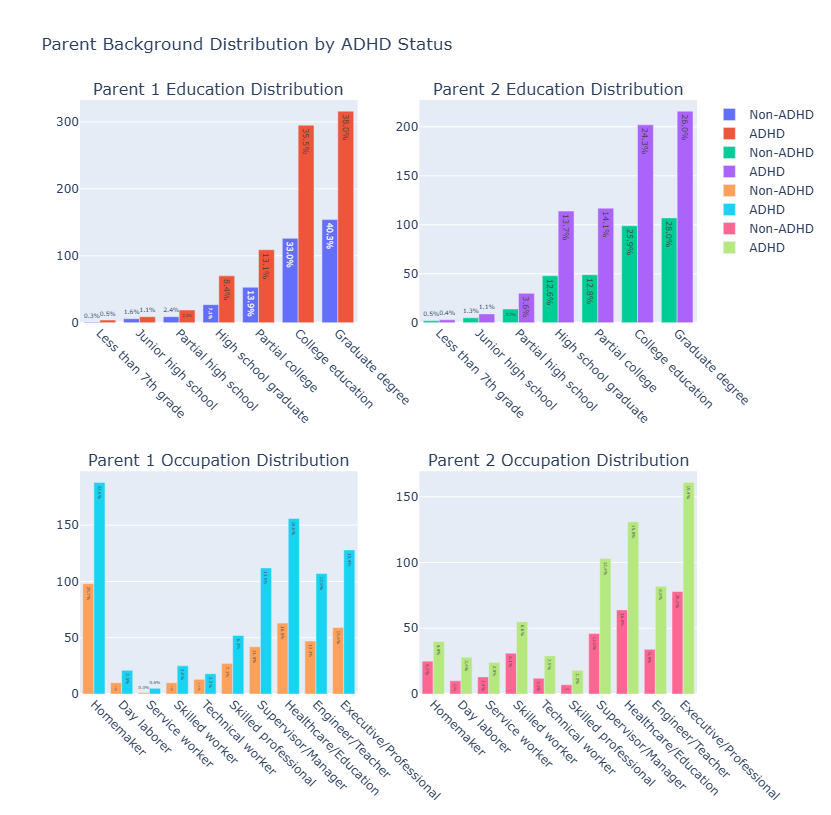


Distribution Summary:

Parent 1 Education:

Non-ADHD:
Most common level: Graduate degree (value: 21.0)
Median level: College education (value: 18.0)
Sample size: 382

ADHD:
Most common level: Graduate degree (value: 21.0)
Median level: College education (value: 18.0)
Sample size: 831

Parent 2 Education:

Non-ADHD:
Most common level: Graduate degree (value: 21.0)
Median level: College education (value: 18.0)
Sample size: 382

ADHD:
Most common level: Graduate degree (value: 21.0)
Median level: College education (value: 18.0)
Sample size: 831

Parent 1 Occupation:

Non-ADHD:
Most common level: Homemaker (value: 0.0)
Median level: Supervisor/Manager (value: 30.0)
Sample size: 382

ADHD:
Most common level: Homemaker (value: 0.0)
Median level: Supervisor/Manager (value: 30.0)
Sample size: 831

Parent 2 Occupation:

Non-ADHD:
Most common level: Executive/Professional (value: 45.0)
Median level: Healthcare/Education (value: 35.0)
Sample size: 382

ADHD:
Most common level: Executive/Professi

In [134]:
parent_vars = {
    'Barratt_Barratt_P1_Edu': 'Parent 1 Education',
    'Barratt_Barratt_P2_Edu': 'Parent 2 Education',
    'Barratt_Barratt_P1_Occ': 'Parent 1 Occupation',
    'Barratt_Barratt_P2_Occ': 'Parent 2 Occupation'
}

education_labels = {
    3.0: 'Less than 7th grade',
    6.0: 'Junior high school',
    9.0: 'Partial high school',
    12.0: 'High school graduate',
    15.0: 'Partial college',
    18.0: 'College education',
    21.0: 'Graduate degree'
}

occupation_labels = {
    0.0: 'Homemaker',
    5.0: 'Day laborer',
    10.0: 'Service worker',
    15.0: 'Skilled worker',
    20.0: 'Technical worker',
    25.0: 'Skilled professional',
    30.0: 'Supervisor/Manager',
    35.0: 'Healthcare/Education',
    40.0: 'Engineer/Teacher',
    45.0: 'Executive/Professional'
}

def analyze_parent_background():
   
    df = overall_df.copy()
    df['ADHD_Status'] = df['ADHD_Outcome'].map({0: 'Non-ADHD', 1: 'ADHD'})
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            "Parent 1 Education Distribution",
            "Parent 2 Education Distribution",
            "Parent 1 Occupation Distribution",
            "Parent 2 Occupation Distribution"
        ]
    )
    
    row = 1
    col = 1
    
    for var, title in parent_vars.items():
        
        labels = education_labels if 'Edu' in var else occupation_labels
        
        for status in ['Non-ADHD', 'ADHD']:
            values = df[df['ADHD_Status'] == status][var].astype(float).value_counts().sort_index()
            
            fig.add_trace(
                go.Bar(
                    name=status,
                    x=list(labels.values()),
                    y=[values.get(k, 0) for k in labels.keys()],
                    text=[f'{(v/len(df[df["ADHD_Status"] == status])*100):.1f}%' 
                          for v in [values.get(k, 0) for k in labels.keys()]],
                    textposition='auto',
                ),
                row=row, col=col
            )
        
        fig.update_xaxes(tickangle=45, row=row, col=col)
        
        col += 1
        if col > 2:
            col = 1
            row += 1
    
    fig.update_layout(
        height=800,
        width=1200,
        title_text="Parent Background Distribution by ADHD Status",
        barmode='group',
        showlegend=True
    )
    

    fig.show()
    fig.write_html("parent_background_distribution.html")
    
    print("\nDistribution Summary:")
    for var, title in parent_vars.items():
        print(f"\n{title}:")
        labels = education_labels if 'Edu' in var else occupation_labels
        
        for status in ['Non-ADHD', 'ADHD']:
            status_data = df[df['ADHD_Status'] == status][var].astype(float)
            print(f"\n{status}:")
            try:
                mode_value = status_data.mode().iloc[0]
                median_value = status_data.median()
                print(f"Most common level: {labels.get(mode_value, 'Unknown')} (value: {mode_value})")
                print(f"Median level: {labels.get(median_value, 'Unknown')} (value: {median_value})")
                print(f"Sample size: {len(status_data)}")
            except Exception as e:
                print(f"Error processing data: {e}")
                print(f"Unique values in data: {status_data.unique()}")

analyze_parent_background()

# Diagnostic Analysis

## Question 1

What are the key behavioral, parenting, and demographic factors associated with ADHD diagnosis, and how strong are these associations?

In [ ]:
Based on the correlation analysis between various factors and ADHD diagnosis, we can identify several significant patterns:
Behavioral Characteristics (SDQ Scores)
The strongest associations are found in behavioral measures:
Externalizing Problems show the strongest positive correlation (r = 0.515, p < 0.001)
Total Difficulties also show a strong positive correlation (r = 0.465, p < 0.001)
Internalizing Problems demonstrate a moderate positive correlation (r = 0.257, p < 0.001)
Parenting Practices (APQ Scores)
Several parenting practices show significant but weaker correlations:
Other Discipline Practices (r = 0.142, p < 0.001) and Inconsistent Discipline (r = 0.124, p < 0.001) are positively correlated
Parent Involvement shows a negative correlation (r = -0.099, p < 0.001)
Corporal Punishment shows a weak positive correlation (r = 0.059, p < 0.05)
Demographic Factors
Gender shows a significant association:
Being female is negatively correlated with ADHD diagnosis (r = -0.131, p < 0.001)
This suggests potential gender bias in ADHD diagnosis
Some racial/ethnic differences are observed:
Black/African American background shows a weak positive correlation (r = 0.065, p < 0.05)
Geographic variation:
Midtown location shows a weak positive correlation (r = 0.072, p < 0.05)
Clinical Implications:
The strong correlation with externalizing behaviors suggests these are key indicators in ADHD diagnosis
The negative correlation with female gender raises concerns about potential under-diagnosis in girls
Parenting practices show modest but significant associations, suggesting their role in ADHD manifestation or management
The presence of both externalizing and internalizing correlations supports the complex nature of ADHD symptoms
Limitations:
Correlations do not imply causation
Some demographic factors show weak or non-significant correlations
The strength of associations varies considerably across different domains
This analysis provides valuable insights for clinical practice, particularly in understanding the multi-faceted nature of ADHD diagnosis and the potential role of gender bias in diagnostic practices.

In [22]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats

# label mapping
variable_labels = {
    # Race
    'Race_0.0': 'White/Caucasian',
    'Race_1.0': 'Black/African American',
    'Race_2.0': 'Hispanic',
    'Race_3.0': 'Asian',
    'Race_4.0': 'Indian',
    'Race_5.0': 'Native American Indian',
    'Race_6.0': 'American Indian/Alaskan Native',
    'Race_7.0': 'Native Hawaiian/Other Pacific Islander',
    'Race_8.0': 'Two or more races',
    'Race_9.0': 'Other race',
    'Race_10.0': 'Unknown Race',
    'Race_11.0': 'Choose not to specify race',
    
    # Ethnicity
    'Ethnicity_0.0': 'Not Hispanic or Latino',
    'Ethnicity_1.0': 'Hispanic or Latino',
    'Ethnicity_2.0': 'Decline to specify',
    'Ethnicity_3.0': 'Unknown Ethnicity',
    
    # MRI Site
    'Site_2': 'MRV',
    'Site_3': 'Midtown',
    'Site_4': 'Harlem',
    'Site_5': 'SI RUMC',
    
    # Other variables' label for readibility
    'Sex_F': 'Female (vs Male)',
    'Barratt_Barratt_P1_Edu': 'Parent 1 Education Level',
    'Barratt_Barratt_P2_Edu': 'Parent 2 Education Level',
    'Barratt_Barratt_P1_Occ': 'Parent 1 Occupation',
    'Barratt_Barratt_P2_Occ': 'Parent 2 Occupation',
    'SDQ_SDQ_Difficulties_Total': 'SDQ Total Difficulties',
    'SDQ_SDQ_Externalizing': 'SDQ Externalizing Problems',
    'SDQ_SDQ_Internalizing': 'SDQ Internalizing Problems',
    'EHQ_EHQ_Total': 'Edinburgh Handedness Score',
    'ColorVision_CV_Score': 'Color Vision Score',
    'APQ_P_APQ_P_CP': 'APQ Corporal Punishment',
    'APQ_P_APQ_P_ID': 'APQ Inconsistent Discipline',
    'APQ_P_APQ_P_INV': 'APQ Parent Involvement',
    'APQ_P_APQ_P_OPD': 'APQ Other Discipline Practices',
    'APQ_P_APQ_P_PM': 'APQ Positive Monitoring',
    'APQ_P_APQ_P_PP': 'APQ Positive Parenting'
}

def prepare_variables_for_correlation():
    
    df = overall_df.copy()
    
    # 
    keep_original = [
        
        'Sex_F', 
        'Barratt_Barratt_P1_Edu', 
        'Barratt_Barratt_P2_Edu',
        'Barratt_Barratt_P1_Occ', 
        'Barratt_Barratt_P2_Occ',
        
        'SDQ_SDQ_Difficulties_Total',
        'SDQ_SDQ_Externalizing',
        'SDQ_SDQ_Internalizing',
        'EHQ_EHQ_Total',
        'ColorVision_CV_Score',
        'APQ_P_APQ_P_CP',
        'APQ_P_APQ_P_ID',
        'APQ_P_APQ_P_INV',
        'APQ_P_APQ_P_OPD',
        'APQ_P_APQ_P_PM',
        'APQ_P_APQ_P_PP'
    ]
    
    # One-hot encoding
    site_dummies = pd.get_dummies(df['Basic_Demos_Study_Site'], 
                                 prefix='Site', 
                                 drop_first=True)
    
    race_dummies = pd.get_dummies(df['PreInt_Demos_Fam_Child_Race'], 
                                 prefix='Race', 
                                 drop_first=True)
    
    ethnicity_dummies = pd.get_dummies(df['PreInt_Demos_Fam_Child_Ethnicity'], 
                                     prefix='Ethnicity', 
                                     drop_first=True)
    
    analysis_df = pd.concat([
        df[keep_original],  
        site_dummies,
        race_dummies,
        ethnicity_dummies,
        df['ADHD_Outcome']
    ], axis=1)
    
    return analysis_df

def calculate_correlations(df):
    
    correlations = []
    p_values = []
    
    for column in df.columns:
        if column != 'ADHD_Outcome':
            
            valid_mask = ~(df[column].isna() | df['ADHD_Outcome'].isna())
            if valid_mask.sum() > 0:  
                
                corr, p = stats.pointbiserialr(df.loc[valid_mask, 'ADHD_Outcome'], 
                                             df.loc[valid_mask, column])
                correlations.append({
                    'Variable': column,
                    'Correlation': corr if not np.isnan(corr) else 0,
                    'P_value': p if not np.isnan(p) else 1,
                    'Significant': p < 0.05 if not np.isnan(p) else False,
                    'N': valid_mask.sum()  
                })
    
    return pd.DataFrame(correlations)

def plot_correlation_heatmap(corr_df):
    
    
    corr_df['Variable_Label'] = corr_df['Variable'].map(
        lambda x: variable_labels.get(x, x)
    )
    
    
    corr_df = corr_df.sort_values('Correlation', key=abs, ascending=False)
    colors = ['blue' if x < 0 else 'red' for x in corr_df['Correlation']]
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
        y=corr_df['Variable_Label'],
        x=corr_df['Correlation'],
        orientation='h',
        marker_color=colors,
        text=[f"{c:.3f}<br>p={p:.3f}<br>n={n}" 
              for c, p, n in zip(corr_df['Correlation'], 
                               corr_df['P_value'], 
                               corr_df['N'])],
        textposition='auto',
    ))
    
    
    for i, row in enumerate(corr_df.itertuples()):
        if row.Significant:
            fig.add_annotation(
                x=row.Correlation,
                y=row.Variable_Label,
                text='*',
                showarrow=False,
                font=dict(size=20)
            )
    
    fig.update_layout(
        title='Correlations with ADHD Diagnosis',
        xaxis_title='Correlation Coefficient',
        yaxis_title='Variables',
        height=1200,
        width=1200,
        showlegend=False,
        annotations=[
            dict(
                x=1.1,
                y=1.05,
                xref='paper',
                yref='paper',
                text='* p < 0.05',
                showarrow=False
            )
        ],
        margin=dict(l=300)
    )
    
    fig.show()
    
    
    fig.write_html("adhd_correlations.html")

def print_correlation_summary(corr_df):
    corr_df['Variable_Label'] = corr_df['Variable'].map(
        lambda x: variable_labels.get(x, x)
    )
    
    print("\nCorrelation Analysis Summary:")
    
    print("\nStrongest Positive Correlations:")
    print(corr_df[corr_df['Correlation'] > 0].sort_values(
        'Correlation', ascending=False)[['Variable_Label', 'Correlation', 'P_value', 'N']].head().to_string(index=False))
    
    print("\nStrongest Negative Correlations:")
    print(corr_df[corr_df['Correlation'] < 0].sort_values(
        'Correlation', ascending=True)[['Variable_Label', 'Correlation', 'P_value', 'N']].head().to_string(index=False))
    
    print("\nSignificant Correlations (p < 0.05):")
    print(corr_df[corr_df['Significant']].sort_values(
        'Correlation', key=abs, ascending=False)[['Variable_Label', 'Correlation', 'P_value', 'N']].to_string(index=False))

print("Preparing data...")
analysis_df = prepare_variables_for_correlation()

print("Calculating correlations...")
correlation_results = calculate_correlations(analysis_df)

print("Creating visualization...")
plot_correlation_heatmap(correlation_results)

print("Generating summary...")
print_correlation_summary(correlation_results)

Preparing data...
Calculating correlations...
Creating visualization...


Generating summary...

Correlation Analysis Summary:

Strongest Positive Correlations:
                Variable_Label  Correlation      P_value    N
    SDQ Externalizing Problems     0.514630 2.204710e-82 1204
        SDQ Total Difficulties     0.464724 1.540923e-65 1204
    SDQ Internalizing Problems     0.257269 1.182310e-19 1204
APQ Other Discipline Practices     0.141816 8.033795e-07 1201
   APQ Inconsistent Discipline     0.124358 1.546231e-05 1201

Strongest Negative Correlations:
        Variable_Label  Correlation  P_value    N
      Female (vs Male)    -0.130836 0.000005 1213
APQ Parent Involvement    -0.099289 0.000569 1201
                Indian    -0.036329 0.206094 1213
          Unknown Race    -0.028756 0.316971 1213
     Two or more races    -0.027013 0.347213 1213

Significant Correlations (p < 0.05):
                Variable_Label  Correlation      P_value    N
    SDQ Externalizing Problems     0.514630 2.204710e-82 1204
        SDQ Total Difficulties     0.464724 1

## Question 2

How do different parenting practices (measured by APQ) correlate with each other, and do these correlations differ between ADHD and non-ADHD groups

In [ ]:
Based on the correlation analysis of APQ dimensions, several important patterns emerge:
Overall Parenting Practice Patterns
The strongest positive correlation exists between Parent Involvement and Positive Parenting (r = 0.563, p < 0.001), suggesting these positive parenting practices tend to co-occur
Negative disciplinary practices also cluster together:
Corporal Punishment correlates with Other Discipline Practices (r = 0.295, p < 0.001)
Inconsistent Discipline correlates with both Corporal Punishment (r = 0.244, p < 0.001) and Other Discipline Practices (r = 0.284, p < 0.001)
Contrasting Parenting Styles
Parent Involvement shows negative correlations with negative disciplinary practices:
Negative correlation with Inconsistent Discipline (r = -0.213, p < 0.001)
This suggests parents who are more involved tend to use less inconsistent discipline
ADHD vs Non-ADHD Group Differences
Most correlations maintain similar patterns across groups, but with some notable differences:
The positive correlation between Parent Involvement and Positive Parenting is stronger in the ADHD group (r = 0.591) compared to the non-ADHD group (r = 0.504)
Inconsistent Discipline and Other Discipline Practices show a weaker correlation in the ADHD group (r = 0.242) compared to the non-ADHD group (r = 0.336)
Group-Specific Patterns
ADHD group shows more significant correlations (11) compared to the non-ADHD group (9)
Some correlations are significant only in the ADHD group:
Other Discipline Practices and Positive Parenting (r = 0.142, p < 0.001 in ADHD group)
Clinical Implications
The stronger association between positive parenting practices in ADHD families suggests potential compensatory strategies
The weaker correlation between negative disciplinary practices in ADHD families might indicate less consistent parenting patterns
Parent Involvement appears to be a key factor that could influence other parenting practices
Limitations
Sample size differences between groups (ADHD: 831, Non-ADHD: 382) may affect correlation strengths
Correlations are moderate to weak in magnitude, suggesting other factors influence parenting practices
The analysis doesn't account for potential confounding variables
These findings suggest that while parenting practices show similar general patterns across both groups, there are subtle but important differences in how these practices relate to each other in families with ADHD children. This understanding could inform targeted parenting interventions for ADHD families.

In [27]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy import stats

def analyze_apq_correlations():
    
    apq_dimensions = {
        'APQ_P_APQ_P_CP': 'Corporal Punishment',
        'APQ_P_APQ_P_ID': 'Inconsistent Discipline',
        'APQ_P_APQ_P_INV': 'Parent Involvement',
        'APQ_P_APQ_P_OPD': 'Other Discipline Practices',
        'APQ_P_APQ_P_PM': 'Positive Monitoring',
        'APQ_P_APQ_P_PP': 'Positive Parenting'
    }
    
    def calculate_correlation_matrix(data):
        vars_list = list(apq_dimensions.keys())
        n = len(vars_list)
        corr_matrix = np.zeros((n, n))
        p_matrix = np.zeros((n, n))
        
        for i, var1 in enumerate(vars_list):
            for j, var2 in enumerate(vars_list):
                if i != j:
                    # delete observation with missing value in any variables
                    mask = ~(data[var1].isna() | data[var2].isna())
                    if mask.sum() > 2:  # ensure sufficient data
                        corr, p = stats.pearsonr(data[var1][mask], data[var2][mask])
                        corr_matrix[i, j] = corr
                        p_matrix[i, j] = p
                else:
                    corr_matrix[i, j] = 1.0
                    p_matrix[i, j] = 0.0
                    
        return corr_matrix, p_matrix
    

    def create_correlation_heatmap(corr_matrix, p_matrix, title):

        labels = list(apq_dimensions.values())
        
        text_matrix = []
        for i in range(len(corr_matrix)):
            text_row = []
            for j in range(len(corr_matrix)):
                if i != j:
                    text = f"{corr_matrix[i,j]:.2f}<br>p={p_matrix[i,j]:.3f}"
                else:
                    text = "1.00"
                text_row.append(text)
            text_matrix.append(text_row)
        
        
        fig = go.Figure(data=go.Heatmap(
            z=corr_matrix,
            x=labels,
            y=labels,
            zmin=-1, zmax=1,
            colorscale='RdBu',
            text=text_matrix,
            texttemplate="%{text}",
            textfont={"size": 10},
            hoverongaps=False
        ))
        
        fig.update_layout(
            title=title,
            width=800,
            height=800,
            xaxis_tickangle=-45
        )
        
        return fig
    
    print("Calculating correlations for overall sample...")
    overall_corr, overall_p = calculate_correlation_matrix(overall_df)
    
    print("Calculating correlations for ADHD group...")
    adhd_data = overall_df[overall_df['ADHD_Outcome'] == 1]
    adhd_corr, adhd_p = calculate_correlation_matrix(adhd_data)
    
    print("Calculating correlations for non-ADHD group...")
    non_adhd_data = overall_df[overall_df['ADHD_Outcome'] == 0]
    non_adhd_corr, non_adhd_p = calculate_correlation_matrix(non_adhd_data)
    
    print("\nCreating visualizations...")

    fig_overall = create_correlation_heatmap(
        overall_corr, overall_p,
        "APQ Correlations - Overall Sample"
    )
    fig_overall.show()
    
    fig_adhd = create_correlation_heatmap(
        adhd_corr, adhd_p,
        "APQ Correlations - ADHD Group"
    )
    fig_adhd.show()
    
    fig_non_adhd = create_correlation_heatmap(
        non_adhd_corr, non_adhd_p,
        "APQ Correlations - Non-ADHD Group"
    )
    fig_non_adhd.show()
    
    print("\nKey Correlations in APQ Dimensions:")
    vars_list = list(apq_dimensions.values())
    vars_list = list(apq_dimensions.values())
    
    print("\nOverall Sample Correlations:")
    for i in range(len(vars_list)):
        for j in range(i+1, len(vars_list)):
            if abs(overall_corr[i,j]) > 0.2:  
                print(f"{vars_list[i]} vs {vars_list[j]}:")
                print(f"Correlation: r = {overall_corr[i,j]:.3f} (p = {overall_p[i,j]:.3f})")
    
    print("\nDifferences between ADHD and Non-ADHD groups:")
    found_differences = False
    for i in range(len(vars_list)):
        for j in range(i+1, len(vars_list)):
            diff = adhd_corr[i,j] - non_adhd_corr[i,j]
            if abs(diff) > 0.05:
                found_differences = True
                print(f"\n{vars_list[i]} vs {vars_list[j]}:")
                print(f"ADHD group: r = {adhd_corr[i,j]:.3f} (p = {adhd_p[i,j]:.3f})")
                print(f"Non-ADHD group: r = {non_adhd_corr[i,j]:.3f} (p = {non_adhd_p[i,j]:.3f})")
                print(f"Difference: {diff:.3f}")
    
    if not found_differences:
        print("No substantial differences found between ADHD and Non-ADHD groups (threshold: 0.05)")
    
    print("\nKey Associations for Each APQ Dimension:")
    for i, dim in enumerate(vars_list):
        print(f"\n{dim}:")
        correlations = [(j, overall_corr[i,j]) for j in range(len(vars_list)) if i != j]
        correlations.sort(key=lambda x: abs(x[1]), reverse=True)
        for j, corr in correlations[:2]:
            print(f"- {vars_list[j]}: r = {corr:.3f} (p = {overall_p[i,j]:.3f})")
    
    print("\nSummary Statistics:")
    print("Sample Sizes:")
    print(f"Total sample: {len(overall_df)}")
    print(f"ADHD group: {len(adhd_data)}")
    print(f"Non-ADHD group: {len(non_adhd_data)}")
    
    sig_overall = np.sum((overall_p < 0.05) & (np.triu(np.ones_like(overall_p), 1) > 0))
    sig_adhd = np.sum((adhd_p < 0.05) & (np.triu(np.ones_like(adhd_p), 1) > 0))
    sig_non_adhd = np.sum((non_adhd_p < 0.05) & (np.triu(np.ones_like(non_adhd_p), 1) > 0))
    
    print("\nSignificant Correlations (p < 0.05):")
    print(f"Overall sample: {sig_overall}")
    print(f"ADHD group: {sig_adhd}")
    print(f"Non-ADHD group: {sig_non_adhd}")
    
    fig_overall.write_html("apq_correlations_overall.html")
    fig_adhd.write_html("apq_correlations_adhd.html")
    fig_non_adhd.write_html("apq_correlations_non_adhd.html")
    
    return {
        'overall': (overall_corr, overall_p),
        'adhd': (adhd_corr, adhd_p),
        'non_adhd': (non_adhd_corr, non_adhd_p)
    }

correlation_results = analyze_apq_correlations()

Calculating correlations for overall sample...
Calculating correlations for ADHD group...
Calculating correlations for non-ADHD group...

Creating visualizations...



Key Correlations in APQ Dimensions:

Overall Sample Correlations:
Corporal Punishment vs Inconsistent Discipline:
Correlation: r = 0.244 (p = 0.000)
Corporal Punishment vs Other Discipline Practices:
Correlation: r = 0.295 (p = 0.000)
Inconsistent Discipline vs Parent Involvement:
Correlation: r = -0.213 (p = 0.000)
Inconsistent Discipline vs Other Discipline Practices:
Correlation: r = 0.284 (p = 0.000)
Inconsistent Discipline vs Positive Monitoring:
Correlation: r = 0.206 (p = 0.000)
Parent Involvement vs Positive Monitoring:
Correlation: r = -0.211 (p = 0.000)
Parent Involvement vs Positive Parenting:
Correlation: r = 0.563 (p = 0.000)

Differences between ADHD and Non-ADHD groups:

Corporal Punishment vs Inconsistent Discipline:
ADHD group: r = 0.257 (p = 0.000)
Non-ADHD group: r = 0.192 (p = 0.000)
Difference: 0.065

Corporal Punishment vs Parent Involvement:
ADHD group: r = -0.088 (p = 0.011)
Non-ADHD group: r = -0.155 (p = 0.003)
Difference: 0.066

Inconsistent Discipline vs Pa

## Question 3

In [ ]:
What is the relationship between SDQ subscales (Externalizing, Internalizing, Total Difficulties) and parenting practices (APQ dimensions), and does this relationship vary by gender?

In [ ]:
Based on the correlation analysis between SDQ subscales and parenting practices, several important patterns emerge:
Overall Relationships
Negative Parenting Practices show consistent positive correlations with behavioral difficulties:
Other Discipline Practices shows the strongest correlations with both Externalizing Problems (r = 0.320) and Total Difficulties (r = 0.308)
Inconsistent Discipline correlates moderately with Externalizing Problems (r = 0.271) and Total Difficulties (r = 0.259)
Corporal Punishment shows moderate correlations with Externalizing Problems (r = 0.216)
Positive Parenting Practices show protective effects:
Parent Involvement negatively correlates with all SDQ subscales:
Total Difficulties (r = -0.199)
Externalizing Problems (r = -0.185)
Internalizing Problems (r = -0.151)
Strength of Associations
Externalizing Problems show stronger correlations with parenting practices compared to Internalizing Problems
The strongest associations are found with negative disciplinary practices
Positive Parenting shows relatively weak correlations with behavioral difficulties
Gender-Specific Patterns
Notable Gender Differences in the relationship between Corporal Punishment and behavioral problems:
For males: strong correlations with Total Difficulties (r = 0.247) and Externalizing Problems (r = 0.274)
For females: non-significant correlations (r = 0.079 and r = 0.088 respectively)
The difference is substantial (Δr ≈ 0.17-0.19)
Pattern of Significant Correlations:
Male group shows more significant correlations (13) compared to female group (9)
This suggests parenting practices might have stronger associations with behavioral problems in boys
Clinical Implications
The findings suggest that:
Negative disciplinary practices are more strongly associated with behavioral problems in boys
Parent Involvement might be a protective factor across genders
Different intervention strategies might be needed for boys and girls
Limitations
Sample size differences between genders (Males: 797, Females: 416)
Correlations are generally moderate to weak in magnitude
Cannot establish causality from correlational analysis
Recommendations for Practice
Focus on reducing negative disciplinary practices, particularly for boys
Promote parent involvement as a protective factor
Consider gender-specific approaches in parenting interventions
Pay special attention to the use of corporal punishment with male children
These findings provide valuable insights for developing gender-sensitive parenting interventions and understanding how different parenting practices might affect behavioral problems differently in boys and girls.

In [28]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy import stats

def analyze_sdq_apq_correlations():
    
    sdq_dimensions = {
        'SDQ_SDQ_Difficulties_Total': 'Total Difficulties',
        'SDQ_SDQ_Externalizing': 'Externalizing Problems',
        'SDQ_SDQ_Internalizing': 'Internalizing Problems'
    }
    
    apq_dimensions = {
        'APQ_P_APQ_P_CP': 'Corporal Punishment',
        'APQ_P_APQ_P_ID': 'Inconsistent Discipline',
        'APQ_P_APQ_P_INV': 'Parent Involvement',
        'APQ_P_APQ_P_OPD': 'Other Discipline Practices',
        'APQ_P_APQ_P_PM': 'Positive Monitoring',
        'APQ_P_APQ_P_PP': 'Positive Parenting'
    }
    
    def calculate_correlations(data):
        sdq_vars = list(sdq_dimensions.keys())
        apq_vars = list(apq_dimensions.keys())
        
        corr_matrix = np.zeros((len(sdq_vars), len(apq_vars)))
        p_matrix = np.zeros((len(sdq_vars), len(apq_vars)))
        n_matrix = np.zeros((len(sdq_vars), len(apq_vars)))
        
        for i, sdq_var in enumerate(sdq_vars):
            for j, apq_var in enumerate(apq_vars):
                mask = ~(data[sdq_var].isna() | data[apq_var].isna())
                if mask.sum() > 2:
                    corr, p = stats.pearsonr(data[sdq_var][mask], data[apq_var][mask])
                    corr_matrix[i, j] = corr
                    p_matrix[i, j] = p
                    n_matrix[i, j] = mask.sum()
                    
        return corr_matrix, p_matrix, n_matrix
    
    def create_correlation_heatmap(corr_matrix, p_matrix, n_matrix, title):
        
        x_labels = list(apq_dimensions.values())
        y_labels = list(sdq_dimensions.values())
        
        text_matrix = []
        for i in range(len(corr_matrix)):
            text_row = []
            for j in range(len(corr_matrix[0])):
                text = f"r={corr_matrix[i,j]:.2f}<br>p={p_matrix[i,j]:.3f}<br>n={int(n_matrix[i,j])}"
                text_row.append(text)
            text_matrix.append(text_row)
        
        fig = go.Figure(data=go.Heatmap(
            z=corr_matrix,
            x=x_labels,
            y=y_labels,
            zmin=-1, zmax=1,
            colorscale='RdBu',
            text=text_matrix,
            texttemplate="%{text}",
            textfont={"size": 10}
        ))
        
        fig.update_layout(
            title=title,
            width=1000,
            height=400,
            xaxis_tickangle=-45
        )
        
        return fig
    
    print("Analyzing overall correlations...")
    overall_corr, overall_p, overall_n = calculate_correlations(overall_df)
    
    print("Analyzing correlations by gender...")
    male_data = overall_df[overall_df['Sex_F'] == 0]
    female_data = overall_df[overall_df['Sex_F'] == 1]
    
    male_corr, male_p, male_n = calculate_correlations(male_data)
    female_corr, female_p, female_n = calculate_correlations(female_data)
    
    print("\nCreating visualizations...")

    # overall correlation
    fig_overall = create_correlation_heatmap(
        overall_corr, overall_p, overall_n,
        "SDQ-APQ Correlations - Overall Sample"
    )
    fig_overall.show()
    
    # male group correlation
    fig_male = create_correlation_heatmap(
        male_corr, male_p, male_n,
        "SDQ-APQ Correlations - Male Group"
    )
    fig_male.show()
    
    # female group correlation
    fig_female = create_correlation_heatmap(
        female_corr, female_p, female_n,
        "SDQ-APQ Correlations - Female Group"
    )
    fig_female.show()
    
    print("\nDetailed Analysis of SDQ-APQ Relationships:")
    print("\nOverall Significant Correlations (p < 0.05):")
    for i, sdq_var in enumerate(sdq_dimensions.values()):
        for j, apq_var in enumerate(apq_dimensions.values()):
            if overall_p[i,j] < 0.05:
                print(f"{sdq_var} - {apq_var}:")
                print(f"r = {overall_corr[i,j]:.3f} (p = {overall_p[i,j]:.3f}, n = {int(overall_n[i,j])})")
    
    print("\nGender Differences in Correlations:")
    for i, sdq_var in enumerate(sdq_dimensions.values()):
        for j, apq_var in enumerate(apq_dimensions.values()):
            diff = male_corr[i,j] - female_corr[i,j]
            if abs(diff) > 0.1:  
                print(f"\n{sdq_var} - {apq_var}:")
                print(f"Male: r = {male_corr[i,j]:.3f} (p = {male_p[i,j]:.3f}, n = {int(male_n[i,j])})")
                print(f"Female: r = {female_corr[i,j]:.3f} (p = {female_p[i,j]:.3f}, n = {int(female_n[i,j])})")
                print(f"Difference: {diff:.3f}")
    
    print("\nSummary Statistics:")
    print(f"Total sample size: {len(overall_df)}")
    print(f"Male sample size: {len(male_data)}")
    print(f"Female sample size: {len(female_data)}")
    
    sig_overall = np.sum(overall_p < 0.05)
    sig_male = np.sum(male_p < 0.05)
    sig_female = np.sum(female_p < 0.05)
    
    print("\nNumber of significant correlations (p < 0.05):")
    print(f"Overall: {sig_overall}")
    print(f"Male group: {sig_male}")
    print(f"Female group: {sig_female}")
    
    fig_overall.write_html("sdq_apq_correlations_overall.html")
    fig_male.write_html("sdq_apq_correlations_male.html")
    fig_female.write_html("sdq_apq_correlations_female.html")
    
    return {
        'overall': (overall_corr, overall_p, overall_n),
        'male': (male_corr, male_p, male_n),
        'female': (female_corr, female_p, female_n)
    }

correlation_results = analyze_sdq_apq_correlations()

Analyzing overall correlations...
Analyzing correlations by gender...

Creating visualizations...



Detailed Analysis of SDQ-APQ Relationships:

Overall Significant Correlations (p < 0.05):
Total Difficulties - Corporal Punishment:
r = 0.192 (p = 0.000, n = 1192)
Total Difficulties - Inconsistent Discipline:
r = 0.259 (p = 0.000, n = 1192)
Total Difficulties - Parent Involvement:
r = -0.199 (p = 0.000, n = 1192)
Total Difficulties - Other Discipline Practices:
r = 0.308 (p = 0.000, n = 1192)
Total Difficulties - Positive Parenting:
r = -0.061 (p = 0.036, n = 1192)
Externalizing Problems - Corporal Punishment:
r = 0.216 (p = 0.000, n = 1192)
Externalizing Problems - Inconsistent Discipline:
r = 0.271 (p = 0.000, n = 1192)
Externalizing Problems - Parent Involvement:
r = -0.185 (p = 0.000, n = 1192)
Externalizing Problems - Other Discipline Practices:
r = 0.320 (p = 0.000, n = 1192)
Externalizing Problems - Positive Parenting:
r = -0.073 (p = 0.012, n = 1192)
Internalizing Problems - Corporal Punishment:
r = 0.102 (p = 0.000, n = 1192)
Internalizing Problems - Inconsistent Discipline:

# Predictive Analysis

## Pre-processing

### Feature Engineering

The feature engineering process aims to enhance the predictive power of our ADHD diagnostic model while maintaining gender fairness. Our approach focuses on creating comprehensive features that capture the multifaceted nature of ADHD manifestation across different genders.
Key Components:
Socioeconomic Status (SES) Features
Combined parental education and occupation indicators
Created stability metrics to reflect family background consistency
Captured missing information patterns in family data
Behavioral Assessment Features
Aggregated SDQ subscales into meaningful composites:
External behaviors (conduct problems + hyperactivity)
Internal behaviors (emotional + peer problems)
Developed gender-specific standardized scores to account for gender differences in symptom presentation
Parenting Style Features
Created composite scores for positive and negative parenting practices
Generated parenting style classifications based on the balance of practices
Incorporated parent involvement metrics
Interaction Features
Developed gender-specific behavioral indicators
Created interaction terms between gender and parenting styles
Captured the differential impact of parenting practices across genders
This engineering approach specifically addresses our research goal of understanding gender differences in ADHD diagnosis by creating features that can capture gender-specific patterns while maintaining clinical relevance. All numerical features are standardized, and categorical features are appropriately encoded to ensure optimal model performance.

In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore') 

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
 feature engineering, create new features
    
    Args:
        df: orginal dataframe
        
    Returns:
        data frame with new features
    """

    # validation for data input
    required_columns = [
        # parent background feature
        "Barratt_Barratt_P1_Edu", "Barratt_Barratt_P2_Edu",
        "Barratt_Barratt_P1_Occ", "Barratt_Barratt_P2_Occ",
        # SDQ feature
        "SDQ_SDQ_Conduct_Problems", "SDQ_SDQ_Hyperactivity",
        "SDQ_SDQ_Emotional_Problems", "SDQ_SDQ_Peer_Problems",
        "SDQ_SDQ_Difficulties_Total",
        # APQ feature
        "APQ_P_APQ_P_PP", "APQ_P_APQ_P_INV", "APQ_P_APQ_P_PM",
        "APQ_P_APQ_P_CP", "APQ_P_APQ_P_ID", "APQ_P_APQ_P_OPD",
        # Sex feature
        "Sex_F"
    ]
    
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    data = df.copy()
    
    #=====================================================
    # 1. Socioeconomic status
    #=====================================================
    # define parent education level, occupation level
    parent_edu = ["Barratt_Barratt_P1_Edu", "Barratt_Barratt_P2_Edu"]
    parent_occ = ["Barratt_Barratt_P1_Occ", "Barratt_Barratt_P2_Occ"]
    
    data['Parent_Edu_Mean'] = data[parent_edu].mean(axis=1)
    data['Parent_Edu_Gap'] = (data[parent_edu[0]] - data[parent_edu[1]]).abs()
    data['Parent_Edu_Missing'] = data[parent_edu].isna().sum(axis=1)

    data['Parent_Occ_Mean'] = data[parent_occ].mean(axis=1)
    data['Parent_Occ_Gap'] = (data[parent_occ[0]] - data[parent_occ[1]]).abs()
    data['Parent_Occ_Missing'] = data[parent_occ].isna().sum(axis=1)
    
    # Comprehensive indicator of socioeconomic status
    ses_vars = ['Parent_Edu_Mean', 'Parent_Occ_Mean']
    scaler = StandardScaler()
    data['SES_Score'] = scaler.fit_transform(data[ses_vars].fillna(data[ses_vars].mean())).mean(axis=1)
    data['SES_Stability'] = -(data['Parent_Edu_Gap'] + data['Parent_Occ_Gap'])/2  # negative values indicate large difference
    
    #=====================================================
    # 2. Behavioral evaluation characteristics
    #=====================================================
    # 2.1 SDQ questionnaire combination characteristics
    # difine variables of externalizing, internalizing
    external_vars = ["SDQ_SDQ_Conduct_Problems", "SDQ_SDQ_Hyperactivity"]
    internal_vars = ["SDQ_SDQ_Emotional_Problems", "SDQ_SDQ_Peer_Problems"]
    
    # Calculating the combined score
    data['SDQ_External_Score'] = data[external_vars].sum(axis=1)
    data['SDQ_Internal_Score'] = data[internal_vars].sum(axis=1)
    data['SDQ_Ext_Int_Ratio'] = data['SDQ_External_Score'] / (data['SDQ_Internal_Score'] + 1)  # avoid deviding by zero
    
    # 2.2 Gender-specific behavioral scores
    # Calculating Z scores by gender
    for gender in [0, 1]:
        mask = data['Sex_F'] == gender
        for col in ['SDQ_External_Score', 'SDQ_Internal_Score']:
            col_name = f'{col}_Gender_Z'
            gender_mean = data.loc[mask, col].mean()
            gender_std = data.loc[mask, col].std()
            data.loc[mask, col_name] = (data.loc[mask, col] - gender_mean) / gender_std
    
    #=====================================================
    # 3. parenting style
    #=====================================================
    # 3.1 Parenting Style Indicator
    # define variables of postive, negative
    positive_vars = ['APQ_P_APQ_P_PP', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_PM']
    negative_vars = ['APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_OPD']
    
    # Calculating the combined score
    scaler = StandardScaler()
    data['Parenting_Positive'] = scaler.fit_transform(data[positive_vars].fillna(data[positive_vars].mean())).mean(axis=1)
    data['Parenting_Negative'] = scaler.fit_transform(data[negative_vars].fillna(data[negative_vars].mean())).mean(axis=1)
    
    # 3.2 Parenting style classification
    # 4 types
    data['Parenting_Style'] = pd.cut(
        data['Parenting_Positive'] - data['Parenting_Negative'],
        bins=4,
        labels=['Negative_Dominant', 'Mixed_Negative', 'Mixed_Positive', 'Positive_Dominant']
    )
    
    #=====================================================
    # 4. Interaction Features
    #=====================================================
    # 4.1 interaction of sex and SDQ behaviors
    data['Gender_X_External'] = data['Sex_F'] * data['SDQ_External_Score']
    data['Gender_X_Internal'] = data['Sex_F'] * data['SDQ_Internal_Score']
    
    # 4.2 interaction of sex and APQ pareting
    data['Gender_X_Positive_Parent'] = data['Sex_F'] * data['Parenting_Positive']
    data['Gender_X_Negative_Parent'] = data['Sex_F'] * data['Parenting_Negative']
    
    #=====================================================
    # 5. variables transformation
    #=====================================================
    # 5.1 log transformation
    log_vars = [
        'SDQ_SDQ_Difficulties_Total',
        'SDQ_External_Score',
        'SDQ_Internal_Score'
    ]
    
    for var in log_vars:
        data[f'{var}_Log'] = np.log1p(data[var].clip(lower=0))
    
    # 5.2 standardization transformation
    numeric_features = [
        'SDQ_External_Score', 'SDQ_Internal_Score',
        'Parent_Edu_Mean', 'Parent_Occ_Mean',
        'Parenting_Positive', 'Parenting_Negative'
    ]
    
    scaler = StandardScaler()
    data[numeric_features] = scaler.fit_transform(data[numeric_features])
    
    return data

engineered_data = engineer_features(overall_df)
engineered_data.head()

participant_id  Basic_Demos_Enroll_Year  Basic_Demos_Study_Site  \
0   00aIpNTbG5uh                     2019                       4   
1   00fV0OyyoLfw                     2017                       1   
2   04X1eiS79T4B                     2017                       1   
3   05ocQutkURd6                     2018                       1   
4   06YUNBA9ZRLq                     2018                       1   

   PreInt_Demos_Fam_Child_Ethnicity  PreInt_Demos_Fam_Child_Race  \
0                               1.0                          0.0   
1                               0.0                          9.0   
2                               1.0                          2.0   
3                               3.0                          8.0   
4                               0.0                          1.0   

   MRI_Track_Scan_Location  Barratt_Barratt_P1_Edu  Barratt_Barratt_P1_Occ  \
0                      3.0                    21.0                    45.0   
1                      2.0                    21.0                     0.0   
2                      2.0                     9.0                     0.0   
3                      2.0                    18.0                    10.0   
4                      2.0                    12.0                     0.0   

   Barratt_Barratt_P2_Edu  Barratt_Barratt_P2_Occ  ...  Parenting_Positive  \
0                     NaN                     NaN  ...            1.099997   
1                    21.0                    45.0  ...            1.473951   
2                     NaN                     NaN  ...            1.130752   
3                    18.0                     0.0  ...            1.055016   
4                     NaN                     NaN  ...           -1.276463   

   Parenting_Negative    Parenting_Style  Gender_X_External  \
0           -0.625987     Mixed_Positive                0.0   
1            0.523673     Mixed_Positive                0.0   
2            0.712540     Mixed_Positive               10.0   
3           -1.005308  Positive_Dominant                3.0   
4            1.857143     Mixed_Negative                0.0   

   Gender_X_Internal  Gender_X_Positive_Parent  Gender_X_Negative_Parent  \
0                0.0                  0.000000                 -0.000000   
1                0.0                  0.000000                  0.000000   
2               14.0                  0.699056                  0.511912   
3                2.0                  0.652235                 -0.722247   
4                0.0                 -0.000000                  0.000000   

   SDQ_SDQ_Difficulties_Total_Log  SDQ_External_Score_Log  \
0                        2.890372                2.484907   
1                        3.044522                2.639057   
2                        3.218876                2.397895   
3                        1.791759                1.386294   
4                        3.178054                2.772589   

   SDQ_Internal_Score_Log  
0                1.945910  
1                2.079442  
2                2.708050  
3                1.098612  
4                2.197225  

[5 rows x 53 columns]

### Missing value

In [45]:
def handle_missing_values(data: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Handle missing values in the dataset using appropriate strategies for different variable types
    """
    df = data.copy()
    existing_columns = set(df.columns)
    
    all_numerical_vars = [
        
        'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu',
        'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ',
        'Parent_Edu_Mean', 'Parent_Occ_Mean',
        'SES_Score',
        
        'SDQ_External_Score', 'SDQ_Internal_Score',
        'SDQ_Ext_Int_Ratio',
        'SDQ_External_Score_Gender_Z',
        'SDQ_Internal_Score_Gender_Z'
    ]
    
    all_questionnaire_vars = [
        
        'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
        'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
        
        'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Conduct_Problems',
        'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Peer_Problems',
        'SDQ_SDQ_Prosocial'
    ]
    
    all_categorical_vars = [
        'PreInt_Demos_Fam_Child_Ethnicity',
        'PreInt_Demos_Fam_Child_Race',
        'Basic_Demos_Study_Site'
    ]
    
    all_derived_features = [
        'Parenting_Positive',
        'Parenting_Negative',
        
        'Gender_X_External',
        'Gender_X_Internal',
        'Gender_X_Positive_Parent',
        'Gender_X_Negative_Parent'
    ]
    
    numerical_vars = [var for var in all_numerical_vars if var in existing_columns]
    questionnaire_vars = [var for var in all_questionnaire_vars if var in existing_columns]
    categorical_vars = [var for var in all_categorical_vars if var in existing_columns]
    derived_features = [var for var in all_derived_features if var in existing_columns]
    
    if verbose:
        print("\nVariable groups after filtering:")
        print(f"Numerical variables ({len(numerical_vars)}):")
        print(numerical_vars)
        print(f"\nQuestionnaire variables ({len(questionnaire_vars)}):")
        print(questionnaire_vars)
        print(f"\nCategorical variables ({len(categorical_vars)}):")
        print(categorical_vars)
        print(f"\nDerived features ({len(derived_features)}):")
        print(derived_features)
    
    # 2. Analyze missing patterns
    if verbose:
        print("\nMissing Value Analysis Before Imputation:")
        missing_stats = data.isnull().sum()
        missing_stats = missing_stats[missing_stats > 0]
        if len(missing_stats) > 0:
            print("\nNumber of missing values:")
            print(missing_stats)
            print("\nMissing Value Percentages:")
            print((missing_stats / len(data) * 100).round(2))
        else:
            print("No missing values found.")
    
    # 3. Create missing indicators
    for col in numerical_vars + questionnaire_vars:
        if df[col].isnull().any():
            df[f'{col}_is_missing'] = df[col].isnull().astype(int)
    
    # 4. Handle missing values based on variable type
    
    # 4.1 Numerical variables: median imputation
    for col in numerical_vars:
        if df[col].isnull().any():
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            if verbose:
                print(f"\nFilled {col} with median: {median_val:.3f}")
    
    # 4.2 Questionnaire variables: 0 imputation
    for col in questionnaire_vars:
        if df[col].isnull().any():
            df[col].fillna(0, inplace=True)
            if verbose:
                print(f"\nFilled {col} with 0")
    
    # 4.3 Categorical variables: mode imputation
    for col in categorical_vars:
        if df[col].isnull().any():
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            if verbose:
                print(f"\nFilled {col} with mode: {mode_val}")
    
    # 5. Verify results
    if verbose:
        print("\nMissing Value Verification After Imputation:")
        missing_after = df.isnull().sum()
        missing_after = missing_after[missing_after > 0]
        if len(missing_after) > 0:
            print("Warning: Some missing values remain:")
            print(missing_after)
        else:
            print("All missing values have been handled successfully.")
    
    # 6. Create overall missing indicators
    df['total_missing_count'] = data.isnull().sum(axis=1)
    df['missing_percentage'] = (data.isnull().sum(axis=1) / len(data.columns) * 100)
    
    return df

print("Handling missing values in the dataset...")
data_no_missing = handle_missing_values(model_data, verbose=True)

print("\nFinal verification of the processed dataset:")
print(f"Shape: {data_no_missing.shape}")
print("\nMissing values check:")
missing_cols = data_no_missing.columns[data_no_missing.isnull().any()].tolist()
if missing_cols:
    print("Warning: Found missing values in:", missing_cols)
else:
    print("No missing values found in the processed dataset.")

Handling missing values in the dataset...

Variable groups after filtering:
Numerical variables (12):
['Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ', 'Parent_Edu_Mean', 'Parent_Occ_Mean', 'SES_Score', 'SDQ_External_Score', 'SDQ_Internal_Score', 'SDQ_Ext_Int_Ratio', 'SDQ_External_Score_Gender_Z', 'SDQ_Internal_Score_Gender_Z']

Questionnaire variables (11):
['APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial']

Categorical variables (3):
['PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'Basic_Demos_Study_Site']

Derived features (6):
['Parenting_Positive', 'Parenting_Negative', 'Gender_X_External', 'Gender_X_Internal', 'Gender_X_Positive_Parent', 'Gender_X_Negative_Parent']

Missing Value Analysis Before Imputation:

Number of mi

### Outier Detection

In handling outliers, we adopted a domain-specific approach rather than applying a standard IQR method across all variables. Our strategy is particularly designed for clinical questionnaire data and derived features, with the primary goal of maintaining data validity while addressing potential measurement or recording errors.
Our approach includes:
Questionnaire Score Validation
Applied range constraints based on questionnaire design (e.g., SDQ scores: 0-10 per subscale)
Capped values exceeding theoretical limits rather than removing them
This preserves clinically significant extreme cases while correcting obvious recording errors
Composite Feature Treatment
Used a modified IQR method (5th-95th percentiles) for derived features
Applied more conservative bounds (2×IQR) compared to traditional 1.5×IQR
Winsorized rather than removed extreme values to maintain sample size
Justification for this approach:
Clinical Relevance: In ADHD diagnosis, extreme behavioral scores might represent genuine cases rather than errors. Complete removal of these cases could bias our understanding of severe presentations.
Gender Fairness: Traditional outlier removal might disproportionately affect one gender, as symptom presentation can vary by gender. Our conservative approach helps maintain gender-specific patterns.
Data Preservation: Winsorization (capping at boundaries) rather than removal ensures we maintain sample size and statistical power, particularly important given our focus on gender differences.
This balanced approach ensures data quality while respecting the clinical nature of our variables and the importance of gender-specific analysis in ADHD diagnosis.

In [46]:
def handle_outliers(data: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Handle outliers using domain-specific rules and modified IQR method
    """
    df = data.copy()
    
    # 1. Questionnaire score range validation
    questionnaire_limits = {
        # SDQ limitation
        'SDQ_SDQ_Difficulties_Total': (0, 40),
        'SDQ_SDQ_Conduct_Problems': (0, 10),
        'SDQ_SDQ_Emotional_Problems': (0, 10),
        'SDQ_SDQ_Hyperactivity': (0, 10),
        'SDQ_SDQ_Peer_Problems': (0, 10),
        'SDQ_SDQ_Prosocial': (0, 10),
        
        # APQ limitation
        'APQ_P_APQ_P_CP': (0, 10),
        'APQ_P_APQ_P_ID': (0, 10),
        'APQ_P_APQ_P_INV': (0, 10),
        'APQ_P_APQ_P_OPD': (0, 10),
        'APQ_P_APQ_P_PM': (0, 10),
        'APQ_P_APQ_P_PP': (0, 10)
    }
    
    # 2. Limit the range of questionnaire scores
    outliers_found = {}
    for col, (min_val, max_val) in questionnaire_limits.items():
        if col in df.columns:
            mask = (df[col] < min_val) | (df[col] > max_val)
            if mask.any():
                outliers_found[col] = mask.sum()
                # Clamp out-of-range values to a reasonable range
                df.loc[df[col] < min_val, col] = min_val
                df.loc[df[col] > max_val, col] = max_val
    
    # 3. modified IQR method for combined features (more conservative threshold)
    composite_features = [
        'SDQ_External_Score',
        'SDQ_Internal_Score',
        'Parenting_Positive',
        'Parenting_Negative'
    ]
    
    for col in composite_features:
        if col in df.columns:
            Q1 = df[col].quantile(0.05)  # more extreme quantiles
            Q3 = df[col].quantile(0.95)
            IQR = Q3 - Q1
            lower_bound = Q1 - 2 * IQR  # looser bounds
            upper_bound = Q3 + 2 * IQR
            
            # record outliers
            mask = (df[col] < lower_bound) | (df[col] > upper_bound)
            if mask.any():
                outliers_found[col] = mask.sum()
                # set extreme values ​​as boundary values
                df.loc[df[col] < lower_bound, col] = lower_bound
                df.loc[df[col] > upper_bound, col] = upper_bound
    
    # 4. report
    if verbose and outliers_found:
        print("\nOutlier Treatment Report:")
        print("\nNumber of outliers found and treated:")
        for col, count in outliers_found.items():
            print(f"{col}: {count} outliers")
        
        print("\nSummary statistics after treatment:")
        print(df[list(outliers_found.keys())].describe())
    
    return df

data_cleaned = handle_outliers(data_no_missing, verbose=True)
data_cleaned.head()


Outlier Treatment Report:

Number of outliers found and treated:
SDQ_SDQ_Conduct_Problems: 791 outliers
SDQ_SDQ_Emotional_Problems: 740 outliers
SDQ_SDQ_Hyperactivity: 606 outliers
SDQ_SDQ_Peer_Problems: 739 outliers
SDQ_SDQ_Prosocial: 492 outliers
APQ_P_APQ_P_CP: 755 outliers
APQ_P_APQ_P_ID: 202 outliers
APQ_P_APQ_P_INV: 12 outliers
APQ_P_APQ_P_OPD: 17 outliers
APQ_P_APQ_P_PM: 17 outliers
APQ_P_APQ_P_PP: 12 outliers

Summary statistics after treatment:
       SDQ_SDQ_Conduct_Problems  SDQ_SDQ_Emotional_Problems  \
count               1213.000000                 1213.000000   
mean                   0.400261                    0.408862   
std                    0.698960                    0.689706   
min                    0.000000                    0.000000   
25%                    0.000000                    0.000000   
50%                    0.000000                    0.000000   
75%                    0.465092                    0.781157   
max                    3.926175      

Sex_F  Basic_Demos_Study_Site  PreInt_Demos_Fam_Child_Ethnicity  \
0      0                1.749535                          0.845766   
1      0               -0.894385                         -0.613571   
2      1               -0.894385                          0.845766   
3      1               -0.894385                          3.764441   
4      0               -0.894385                         -0.613571   

   PreInt_Demos_Fam_Child_Race  Barratt_Barratt_P1_Edu  \
0                    -0.657785                0.895434   
1                     2.187317                0.895434   
2                    -0.025540               -2.529083   
3                     1.871195                0.039305   
4                    -0.341662               -1.672953   

   Barratt_Barratt_P2_Edu  Barratt_Barratt_P1_Occ  Barratt_Barratt_P2_Occ  \
0                0.285963                1.161455                0.341344   
1                1.049784               -1.525120                1.061073   
2                0.285963               -1.525120                0.341344   
3                0.285963               -0.928103               -2.177705   
4                0.285963               -1.525120                0.341344   

   SDQ_SDQ_Hyperactivity  SDQ_SDQ_Conduct_Problems  ...  Gender_X_Internal  \
0               0.882376                  0.465092  ...          -0.525887   
1               0.882376                  1.453973  ...          -0.525887   
2               0.529716                  0.465092  ...           3.917203   
3               0.000000                  0.000000  ...           0.108840   
4               1.235036                  1.948413  ...          -0.525887   

   Gender_X_Positive_Parent  Gender_X_Negative_Parent  ADHD_Outcome  \
0                  0.059830                  0.044376             1   
1                  0.059830                  0.044376             1   
2                  1.943446                  1.310938             0   
3                  1.817284                 -1.742589             0   
4                  0.059830                  0.044376             1   

   Barratt_Barratt_P1_Edu_is_missing  Barratt_Barratt_P2_Edu_is_missing  \
0                                  0                                  1   
1                                  0                                  0   
2                                  0                                  1   
3                                  0                                  0   
4                                  0                                  1   

   Barratt_Barratt_P1_Occ_is_missing  Barratt_Barratt_P2_Occ_is_missing  \
0                                  0                                  1   
1                                  0                                  0   
2                                  0                                  1   
3                                  0                                  0   
4                                  0                                  1   

   total_missing_count  missing_percentage  
0                    2            5.882353  
1                    0            0.000000  
2                    2            5.882353  
3                    0            0.000000  
4                    2            5.882353  

[5 rows x 40 columns]

### Feature scaling

In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from typing import List, Tuple

def prepare_features_for_modeling(data: pd.DataFrame, 
                                target_col: str = 'ADHD_Outcome',
                                exclude_from_scaling: List[str] = None) -> Tuple[pd.DataFrame, StandardScaler]:
   
    df = data.copy()
    
    # exclude variables: ADHD Outcome and Sex
    if exclude_from_scaling is None:
        exclude_from_scaling = [target_col, 'Sex_F']
    
    print("\nColumn Data Types:")
    print(df.dtypes)
    
    # identify numeric columns
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    print("\nNumeric Columns:")
    print(numeric_columns.tolist())
    
    # # determine the features to scale (numeric and not in the exclude list)
    features_to_scale = [col for col in numeric_columns 
                        if col not in exclude_from_scaling]
    
    print("\nFeatures to be scaled:")
    print(features_to_scale)
    
    # double-check
    if not features_to_scale:
        raise ValueError("No numeric features found for scaling!")
    
    # create and train scaler
    scaler = StandardScaler()
    # transform the features to be scaled
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
    
    print("\nFeature scaling verification:")
    print("\nScaled features mean and std:")
    print(df[features_to_scale].describe().loc[['mean', 'std']])
    
    if exclude_from_scaling:
        print("\nUnscaled features:")
        print(df[exclude_from_scaling].describe())
    
    return df, scaler

# have a look on data before scaling
print("Original data info:")
print(data_cleaned.info())

scaled_data, scaler = prepare_features_for_modeling(data_cleaned)
print("\nScaled data shape:", scaled_data.shape)

Original data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Sex_F                              1213 non-null   int64  
 1   Basic_Demos_Study_Site             1213 non-null   float64
 2   PreInt_Demos_Fam_Child_Ethnicity   1213 non-null   float64
 3   PreInt_Demos_Fam_Child_Race        1213 non-null   float64
 4   Barratt_Barratt_P1_Edu             1213 non-null   float64
 5   Barratt_Barratt_P2_Edu             1213 non-null   float64
 6   Barratt_Barratt_P1_Occ             1213 non-null   float64
 7   Barratt_Barratt_P2_Occ             1213 non-null   float64
 8   SDQ_SDQ_Hyperactivity              1213 non-null   float64
 9   SDQ_SDQ_Conduct_Problems           1213 non-null   float64
 10  SDQ_SDQ_Emotional_Problems         1213 non-null   float64
 11  SDQ_SDQ_Peer_Problems              1

## Processed Data Overiew

In [48]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple

# 1. features: user_input vs. derived features
FEATURE_GROUPS = {
    'user_input_features': {
        'demographics': [
            'Sex_F',  
            'Basic_Demos_Study_Site',  
            'PreInt_Demos_Fam_Child_Ethnicity', 
            'PreInt_Demos_Fam_Child_Race'
        ],
        'ses_indicators': [
            'Barratt_Barratt_P1_Edu',
            'Barratt_Barratt_P2_Edu',
            'Barratt_Barratt_P1_Occ',
            'Barratt_Barratt_P2_Occ'
        ],
        'sdq_scores': [
            'SDQ_SDQ_Hyperactivity',
            'SDQ_SDQ_Conduct_Problems',
            'SDQ_SDQ_Emotional_Problems',
            'SDQ_SDQ_Peer_Problems',
            'SDQ_SDQ_Prosocial'
        ],
        'apq_scores': [
            'APQ_P_APQ_P_CP',
            'APQ_P_APQ_P_ID',
            'APQ_P_APQ_P_INV',
            'APQ_P_APQ_P_OPD',
            'APQ_P_APQ_P_PM',
            'APQ_P_APQ_P_PP'
        ]
    },
    'derived_features': {
        'ses_derived': [
            'Parent_Edu_Mean',
            'Parent_Occ_Mean',
            'SES_Score'
        ],
        'sdq_derived': [
            'SDQ_External_Score',
            'SDQ_Internal_Score',
            'SDQ_Ext_Int_Ratio'
        ],
        'gender_specific': [
            'SDQ_External_Score_Gender_Z',
            'SDQ_Internal_Score_Gender_Z'
        ],
        'parenting_derived': [
            'Parenting_Positive',
            'Parenting_Negative'
        ],
        'gender_interactions': [
            'Gender_X_External',
            'Gender_X_Internal',
            'Gender_X_Positive_Parent',
            'Gender_X_Negative_Parent'
        ]
    }
}

TARGET_VAR = 'ADHD_Outcome'

def get_all_features() -> List[str]:
    all_features = []
    for feature_group in FEATURE_GROUPS['user_input_features'].values():
        all_features.extend(feature_group)
    for feature_group in FEATURE_GROUPS['derived_features'].values():
        all_features.extend(feature_group)
    return all_features

def create_model_dataset(scaled_data: pd.DataFrame, scaler: StandardScaler) -> Tuple[pd.DataFrame, Dict]:
    """
    Creates a modeling dataset from scaled data.
    
    Args:
        scaled_data: Feature-engineered, missing value-handled, and scaled data
        scaler: StandardScaler object for feature scaling
    
    Returns:
        model_data: dataset specific for modeling
        dataset_info: dataset dictionary
    """
    
    all_features = get_all_features()
    
    
    model_data = scaled_data[all_features + [TARGET_VAR]].copy()
    
    dataset_info = {
        'shape': model_data.shape,
        'features': {
            'total': len(all_features),
            'groups': {
                group_type: {
                    group_name: len(features)
                    for group_name, features in groups.items()
                }
                for group_type, groups in FEATURE_GROUPS.items()
            }
        },
        'target_distribution': model_data[TARGET_VAR].value_counts(normalize=True).to_dict(),
        'missing_values': model_data.isnull().sum()[model_data.isnull().sum() > 0].to_dict()
    }
    
    print("\nModel Dataset Summary:")
    print(f"Shape: {dataset_info['shape']}")
    print(f"\nFeature Groups:")
    for group_type, groups in dataset_info['features']['groups'].items():
        print(f"\n{group_type}:")
        for group_name, count in groups.items():
            print(f"  {group_name}: {count} features")
    
    print(f"\nTarget Distribution:")
    for outcome, proportion in dataset_info['target_distribution'].items():
        print(f"  ADHD_{outcome}: {proportion:.2%}")
    
    if dataset_info['missing_values']:
        print("\nWarning: Missing Values Detected:")
        for feature, count in dataset_info['missing_values'].items():
            print(f"  {feature}: {count} missing values")
    
    return model_data, dataset_info

model_data, dataset_info = create_model_dataset(scaled_data, scaler)


Model Dataset Summary:
Shape: (1213, 34)

Feature Groups:

user_input_features:
  demographics: 4 features
  ses_indicators: 4 features
  sdq_scores: 5 features
  apq_scores: 6 features

derived_features:
  ses_derived: 3 features
  sdq_derived: 3 features
  gender_specific: 2 features
  parenting_derived: 2 features
  gender_interactions: 4 features

Target Distribution:
  ADHD_1: 68.51%
  ADHD_0: 31.49%


In [49]:
import pandas as pd
import plotly.graph_objects as go
import os
from datetime import datetime
import json

def save_processed_data(model_data: pd.DataFrame, 
                       dataset_info: Dict, 
                       scaler: StandardScaler,
                       base_path: str = "../data/processed_data") -> None:
    """
    Saves the processed data and related information.

        Args:
            model_data: The processed modeling dataset
            dataset_info: The dataset information dictionary
            scaler: The normalized scaler object
            base_path: The storage path
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    if not os.path.exists(base_path):
        os.makedirs(base_path)
        print(f"Created directory: {base_path}")
    
    data_path = os.path.join(base_path, f"model_data_{timestamp}.csv")
    model_data.to_csv(data_path, index=False)
    

    info_path = os.path.join(base_path, f"dataset_info_{timestamp}.json")
    with open(info_path, 'w') as f:
        json.dump(dataset_info, f, indent=4)
    
    from joblib import dump
    scaler_path = os.path.join(base_path, f"scaler_{timestamp}.joblib")
    dump(scaler, scaler_path)
    
    print(f"\nFiles saved successfully:")
    print(f"- Data: {data_path}")
    print(f"- Info: {info_path}")
    print(f"- Scaler: {scaler_path}")

def create_interactive_table(model_data: pd.DataFrame) -> go.Figure:
    """
    Create an interactive data table
    """
    
    feature_groups = {
        'Demographics': FEATURE_GROUPS['user_input_features']['demographics'],
        'SES Indicators': FEATURE_GROUPS['user_input_features']['ses_indicators'],
        'SDQ Scores': FEATURE_GROUPS['user_input_features']['sdq_scores'],
        'APQ Scores': FEATURE_GROUPS['user_input_features']['apq_scores'],
        'Derived Features': [feat for group in FEATURE_GROUPS['derived_features'].values() 
                           for feat in group]
    }
    
    color_map = {
        'Demographics': '#E8F5E9',  
        'SES Indicators': '#FFF3E0',  
        'SDQ Scores': '#E3F2FD',  
        'APQ Scores': '#F3E5F5',  
        'Derived Features': '#FAFAFA',  
        'Target': '#FFEBEE'  
    }
    
    
    fill_colors = []
    for col in model_data.columns:
        color_assigned = False
        for group_name, features in feature_groups.items():
            if col in features:
                fill_colors.append(color_map[group_name])
                color_assigned = True
                break
        if not color_assigned:
            if col == TARGET_VAR:
                fill_colors.append(color_map['Target'])
            else:
                fill_colors.append('#FFFFFF')  
    
    
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=list(model_data.columns),
            fill_color='#E0E0E0',  
            align='left',
            font=dict(size=12)
        ),
        cells=dict(
            values=[model_data[col] for col in model_data.columns],
            fill_color=[fill_colors * len(model_data)],  
            align='left',
            font=dict(size=11),
            format=['.3f' if model_data[col].dtype in ['float64'] else '' 
                   for col in model_data.columns]  
        )
    )])
    
    fig.update_layout(
        title="Processed Dataset Overview",
        width=None,  
        height=600,
        margin=dict(t=30, b=10, l=10, r=10)
    )
    
    return fig


try:
    
    save_processed_data(model_data, dataset_info, scaler)
    
    table_fig = create_interactive_table(model_data)
    
    table_path = os.path.join("../data/processed_data", "interactive_table.html")
    table_fig.write_html(table_path)
    print(f"\nInteractive table saved to: {table_path}")
    
    table_fig.show()
    
except Exception as e:
    print(f"Error occurred: {str(e)}")


Files saved successfully:
- Data: ../data/processed_data\model_data_20250926_132641.csv
- Info: ../data/processed_data\dataset_info_20250926_132641.json
- Scaler: ../data/processed_data\scaler_20250926_132641.joblib

Interactive table saved to: ../data/processed_data\interactive_table.html


## Modelling

### Split Dataset

In [54]:
def prepare_training_data(data: pd.DataFrame, 
                         target: str = 'ADHD_Outcome',
                         test_size: float = 0.2,
                         random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Args:
        data: preprocessed data
        target: target variable
        test_size: test proportion
        random_state: random seed
    
    Returns:
        X_train: training feature
        X_val: validation feature
        y_train: training tag
        y_val: validation tag
    """
    
    X = data.drop(columns=[target])
    y = data[target]
    
    stratify_labels = data['Sex_F'].astype(str) + '_' + data[target].astype(str)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_labels
    )
    
    print("\nDataset Split Summary:")
    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")
    
    
    print("\nGroup Distribution:")
    for dataset_name, X_data, y_data in [("Training", X_train, y_train), 
                                        ("Validation", X_val, y_val)]:
        print(f"\n{dataset_name} set:")
        dist_df = pd.DataFrame({
            'Sex_F': X_data['Sex_F'],
            'ADHD': y_data
        })
        
        dist = pd.crosstab(dist_df['Sex_F'], dist_df['ADHD'], normalize='all') * 100
        print(dist.round(2))
    
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = prepare_training_data(model_data)


Dataset Split Summary:
Training set shape: (970, 33)
Validation set shape: (243, 33)

Group Distribution:

Training set:
ADHD       0      1
Sex_F              
0      17.84  47.84
1      13.71  20.62

Validation set:
ADHD       0      1
Sex_F              
0      17.70  48.15
1      13.58  20.58


### Baseline Model

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time
from typing import Dict, Tuple


def evaluate_model_by_gender(y_true: pd.Series, 
                           y_pred: np.ndarray, 
                           y_prob: np.ndarray, 
                           sex_labels: pd.Series) -> Dict:
    """
    
    Args:
        y_true
        y_pred
        y_prob
        sex_labels
    
    Returns:
        metrics: metric for evaluation
    """
    metrics = {
        'overall': {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'auc': roc_auc_score(y_true, y_prob)
        }
    }
    
    
    for sex in [0, 1]:
        sex_mask = sex_labels == sex
        sex_name = 'female' if sex == 1 else 'male'
        
        if sum(sex_mask) > 0:  
            metrics[sex_name] = {
                'accuracy': accuracy_score(y_true[sex_mask], y_pred[sex_mask]),
                'precision': precision_score(y_true[sex_mask], y_pred[sex_mask]),
                'recall': recall_score(y_true[sex_mask], y_pred[sex_mask]),
                'f1': f1_score(y_true[sex_mask], y_pred[sex_mask]),
                'auc': roc_auc_score(y_true[sex_mask], y_prob[sex_mask])
            }
    
    return metrics

def train_baseline_model(X_train: pd.DataFrame, 
                        X_val: pd.DataFrame,
                        y_train: pd.Series,
                        y_val: pd.Series) -> Dict:
    """
    train and evaluate（Logistic Regression）
    
    Args:
        X_train
        X_val
        y_train
        y_val
    
    Returns:
        results:
    """
   
    baseline_model = LogisticRegression(random_state=42, max_iter=1000)
    
    train_start_time = time.time()
    baseline_model.fit(X_train, y_train)
    train_time = time.time() - train_start_time
    
    predict_start_time = time.time()
    y_pred = baseline_model.predict(X_val)
    y_prob = baseline_model.predict_proba(X_val)[:, 1]
    predict_time = time.time() - predict_start_time
    
    metrics = evaluate_model_by_gender(y_val, y_pred, y_prob, X_val['Sex_F'])
    
    results = {
        'model': baseline_model,
        'training_time': train_time,
        'prediction_time': predict_time,
        'metrics': metrics
    }
    
    print("\nBaseline Model Evaluation:")
    print(f"Training time: {train_time:.4f} seconds")
    print(f"Prediction time: {predict_time:.4f} seconds")
    print("\nPerformance Metrics:")
    
    for group, group_metrics in metrics.items():
        print(f"\n{group.capitalize()} Group:")
        for metric_name, value in group_metrics.items():
            print(f"{metric_name}: {value:.4f}")
    
    return results

try:
    
    baseline_results = train_baseline_model(X_train, X_val, y_train, y_val)
    
    import joblib
    model_path = "../model/baseline_model.joblib"
    joblib.dump(baseline_results, model_path)
    print(f"\nBaseline model results saved to: {model_path}")
    
except Exception as e:
    print(f"Error occurred: {str(e)}")


Baseline Model Evaluation:
Training time: 0.0745 seconds
Prediction time: 0.0040 seconds

Performance Metrics:

Overall Group:
accuracy: 0.8354
precision: 0.8432
recall: 0.9341
f1: 0.8864
auc: 0.8568

Male Group:
accuracy: 0.8125
precision: 0.8321
recall: 0.9316
f1: 0.8790
auc: 0.8424

Female Group:
accuracy: 0.8795
precision: 0.8704
recall: 0.9400
f1: 0.9038
auc: 0.8964

Baseline model results saved to: ../model/baseline_model.joblib


### Advanced model

In [85]:
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
from typing import Dict, List, Tuple

# 1. model configuration
def get_model_configs() -> Dict:
    """
    define 9 new models and their hyperparameters
    """
    configs = {
        'random_forest': {
            'simple': {
                'n_estimators': 100,
                'max_depth': 5,
                'random_state': 42
            },
            'moderate': {
                'n_estimators': 200,
                'max_depth': 10,
                'min_samples_split': 5,
                'random_state': 42
            },
            'complex': {
                'n_estimators': 300,
                'max_depth': 15,
                'min_samples_split': 3,
                'class_weight': 'balanced',
                'random_state': 42
            }
        },
        'xgboost': {
            'simple': {
                'n_estimators': 100,
                'max_depth': 3,
                'learning_rate': 0.1,
                'random_state': 42
            },
            'moderate': {
                'n_estimators': 200,
                'max_depth': 5,
                'learning_rate': 0.05,
                'random_state': 42
            },
            'complex': {
                'n_estimators': 300,
                'max_depth': 7,
                'learning_rate': 0.01,
                'random_state': 42
            }
        },
        'lightgbm': {
            'simple': {
                'n_estimators': 100,
                'max_depth': 3,
                'learning_rate': 0.1,
                'random_state': 42,
                'force_col_wise': True, 
                'verbose': -1  
            },
            'moderate': {
                'n_estimators': 200,
                'max_depth': 5,
                'learning_rate': 0.05,
                'random_state': 42
            },
            'complex': {
                'n_estimators': 300,
                'max_depth': 7,
                'learning_rate': 0.01,
                'random_state': 42
            }
        }
    }
    return configs

# 2. train single model
def train_and_evaluate_model(model_class, model_params: Dict, 
                           X_train: pd.DataFrame, X_val: pd.DataFrame,
                           y_train: pd.Series, y_val: pd.Series) -> Dict:
    
    model = model_class(**model_params)
    
    train_start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - train_start
    
    predict_start = time.time()
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    predict_time = time.time() - predict_start
    
    # performance evaluation
    metrics = evaluate_model_by_gender(y_val, y_pred, y_prob, X_val['Sex_F'])
    
    return {
        'model': model,
        'training_time': train_time,
        'prediction_time': predict_time,
        'metrics': metrics
    }

# 3. train all model
def train_all_models(X_train: pd.DataFrame, X_val: pd.DataFrame,
                    y_train: pd.Series, y_val: pd.Series) -> Dict:
    
    configs = get_model_configs()
    all_results = {}

    # add baseline model (Logistic Regression)
    print("\nTraining Baseline (Logistic Regression) model...")
    baseline_results = {}
    baseline_model = LogisticRegression(random_state=42)
    
    # add, evaluate baseline model
    train_start = time.time()
    baseline_model.fit(X_train, y_train)
    train_time = time.time() - train_start
    
    predict_start = time.time()
    y_pred = baseline_model.predict(X_val)
    y_prob = baseline_model.predict_proba(X_val)[:, 1]
    predict_time = time.time() - predict_start
    
    baseline_metrics = evaluate_model_by_gender(y_val, y_pred, y_prob, X_val['Sex_F'])
    
    baseline_results['base'] = {
        'model': baseline_model,
        'training_time': train_time,
        'prediction_time': predict_time,
        'metrics': baseline_metrics
    }
    
    all_results['logistic_regression'] = baseline_results
    
    # Random Forest
    print("\nTraining Random Forest models...")
    rf_results = {}
    for variant, params in configs['random_forest'].items():
        print(f"\nTraining Random Forest - {variant}")
        rf_results[variant] = train_and_evaluate_model(
            RandomForestClassifier, params,
            X_train, X_val, y_train, y_val
        )
    all_results['random_forest'] = rf_results
    
    # XGBoost
    print("\nTraining XGBoost models...")
    xgb_results = {}
    for variant, params in configs['xgboost'].items():
        print(f"\nTraining XGBoost - {variant}")
        xgb_results[variant] = train_and_evaluate_model(
            XGBClassifier, params,
            X_train, X_val, y_train, y_val
        )
    all_results['xgboost'] = xgb_results
    
    # LightGBM
    print("\nTraining LightGBM models...")
    lgb_results = {}
    for variant, params in configs['lightgbm'].items():
        print(f"\nTraining LightGBM - {variant}")
        lgb_results[variant] = train_and_evaluate_model(
            LGBMClassifier, params,
            X_train, X_val, y_train, y_val
        )
    all_results['lightgbm'] = lgb_results
    
    return all_results

# 4. evaluation performance for all models
def evaluate_models(all_results: Dict) -> pd.DataFrame:
 
    evaluation_records = []
    
    for model_type, variants in all_results.items():
        for variant_name, results in variants.items():
            record = {
                'model_type': model_type,
                'variant': variant_name,
                'training_time': results['training_time'],
                'prediction_time': results['prediction_time'],
                # overall metrics
                'overall_accuracy': results['metrics']['overall']['accuracy'],
                'overall_precision': results['metrics']['overall']['precision'],
                'overall_recall': results['metrics']['overall']['recall'],
                'overall_f1': results['metrics']['overall']['f1'],
                'overall_auc': results['metrics']['overall']['auc'],
                # female group metrics
                'female_accuracy': results['metrics']['female']['accuracy'],
                'female_precision': results['metrics']['female']['precision'],
                'female_recall': results['metrics']['female']['recall'],
                'female_f1': results['metrics']['female']['f1'],
                'female_auc': results['metrics']['female']['auc']
            }
            
            # weighted score frame
            # 1. performace (70%)
            performance_score = (
                0.25 * record['female_f1'] +          
                0.15 * record['female_auc'] +         
                0.15 * record['female_precision'] +   
                0.15 * record['overall_f1'] +         
                0.10 * record['overall_auc']          
            )
            
            # 2. efficiency (20%)
            efficiency_score = (
                0.15 * (1 / (1 + results['prediction_time'])) +  
                0.05 * (1 / (1 + results['training_time']))      
            )
            
            # 3. stability (10%)
            stability_score = (
                0.10 * (1 - abs(record['female_f1'] - record['overall_f1']))  
            )
            
            # final weighted score
            record['weighted_score'] = performance_score + efficiency_score + stability_score
            
            evaluation_records.append(record)
    
    eval_df = pd.DataFrame(evaluation_records)
    eval_df = eval_df.sort_values('weighted_score', ascending=False)
    
    return eval_df

# 5. run
def run_model_evaluation(X_train: pd.DataFrame, X_val: pd.DataFrame,
                        y_train: pd.Series, y_val: pd.Series) -> None:
    
    try:
        
        print("Starting model training and evaluation...")
        all_results = train_all_models(X_train, X_val, y_train, y_val)
        
        print("\nEvaluating all models...")
        evaluation_df = evaluate_models(all_results)
        
        print("\nModel Evaluation Results:")
        print(evaluation_df.to_string())
        
        evaluation_df.to_csv("../model/model_comparison_results.csv")
        print("\nResults saved to: ../model/model_comparison_results.csv")
        
        # get best one among 10 models 
        best_model_info = evaluation_df.iloc[0]
        best_model = all_results[best_model_info['model_type']][best_model_info['variant']]['model']
        
        # save best one among 10 models 
        joblib.dump(best_model, "../model/best_model.joblib")
        print(f"\nBest model ({best_model_info['model_type']} - {best_model_info['variant']}) "
              f"saved to: ../model/best_model.joblib")
        
    except Exception as e:
        print(f"Error in model evaluation: {str(e)}")



run_model_evaluation(X_train, X_val, y_train, y_val)

Starting model training and evaluation...

Training Baseline (Logistic Regression) model...

Training Random Forest models...

Training Random Forest - simple

Training Random Forest - moderate

Training Random Forest - complex

Training XGBoost models...

Training XGBoost - simple

Training XGBoost - moderate

Training XGBoost - complex

Training LightGBM models...

Training LightGBM - simple

Training LightGBM - moderate

Training LightGBM - complex

Evaluating all models...

Model Evaluation Results:
            model_type   variant  training_time  prediction_time  overall_accuracy  overall_precision  overall_recall  overall_f1  overall_auc  female_accuracy  female_precision  female_recall  female_f1  female_auc  weighted_score
0  logistic_regression      base       0.060990         0.003999          0.835391           0.843243        0.934132    0.886364     0.856760         0.879518          0.870370           0.94   0.903846    0.896364        1.004382
7             lightgbm    s

### Ensemble Model

In [87]:
def get_all_model_results():
    """
    retrain all 10 models and return results
    """
    try:
        print("Starting model training and evaluation...")
        all_results = train_all_models(X_train, X_val, y_train, y_val)
        return all_results
    except Exception as e:
        print(f"Error in model training: {str(e)}")
        return None

def run_ensemble_evaluation(X_train: pd.DataFrame, X_val: pd.DataFrame,
                          y_train: pd.Series, y_val: pd.Series) -> None:
    
    # 获取所有模型结果
    all_results = get_all_model_results()
    
    if all_results is None:
        print("Failed to get model results. Cannot proceed with ensemble evaluation.")
        return
    
    # create and evaluate ensemble model
    print("\nCreating and evaluating ensemble model...")
    ensemble_model, ensemble_results = create_ensemble_model(
        all_results, X_train, y_train, X_val, y_val
    )
    
    all_results['ensemble'] = {'voting': ensemble_results}
    
    # re-evaluation
    evaluation_df = evaluate_models(all_results)
    
    print("\nUpdated Model Evaluation Results (including ensemble):")
    print(evaluation_df.to_string())
    
    evaluation_df.to_csv("../model/model_comparison_results_with_ensemble.csv")
    print("\nResults saved to: ../model/model_comparison_results_with_ensemble.csv")
    
    # save ensemble model if it perform best 
    if evaluation_df.iloc[0]['model_type'] == 'ensemble':
        joblib.dump(ensemble_model, "../model/best_model_ensemble.joblib")
        print("\nEnsemble model saved as best model!")
    
    return evaluation_df

print("Starting ensemble evaluation...")
final_results = run_ensemble_evaluation(X_train, X_val, y_train, y_val)

Starting ensemble evaluation...
Starting model training and evaluation...

Training Baseline (Logistic Regression) model...

Training Random Forest models...

Training Random Forest - simple

Training Random Forest - moderate

Training Random Forest - complex

Training XGBoost models...

Training XGBoost - simple

Training XGBoost - moderate

Training XGBoost - complex

Training LightGBM models...

Training LightGBM - simple

Training LightGBM - moderate

Training LightGBM - complex

Creating and evaluating ensemble model...
Training ensemble model...
Evaluating ensemble model...

Updated Model Evaluation Results (including ensemble):
             model_type   variant  training_time  prediction_time  overall_accuracy  overall_precision  overall_recall  overall_f1  overall_auc  female_accuracy  female_precision  female_recall  female_f1  female_auc  weighted_score
10             ensemble    voting       0.302530         0.023178          0.847737           0.849462        0.946108    0.

### Visulization for evaluation result

In [88]:
def visualize_metrics(eval_df: pd.DataFrame, save_path: str = "../model/evaluation_plots.html") -> None:
    
    # color mapping
    color_map = {
        'ensemble-voting': '#1f77b4',          
        'logistic_regression-base': '#2ecc71', 
        
        'random_forest-simple': '#ffcdd2',     
        'random_forest-moderate': '#e57373',   
        'random_forest-complex': '#c62828',    
        
        'xgboost-simple': '#ffe0b2',          
        'xgboost-moderate': '#ffb74d',        
        'xgboost-complex': '#f57c00',         
        
        'lightgbm-simple': '#fff59d',         
        'lightgbm-moderate': '#ffee58',       
        'lightgbm-complex': '#fdd835'          
    }

    
    model_names = [f"{row['model_type']}-{row['variant']}" for _, row in eval_df.iterrows()]
    
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=(
            'Time Performance',
            'Model Ranking (Weighted Score)',
            'Accuracy Comparison',
            'Precision Comparison',
            'Recall Comparison',
            'F1 Score Comparison'
        ),
        vertical_spacing=0.15,
        horizontal_spacing=0.12
    )

    # 1. time performance (row=1, col=1)
    fig.add_trace(
        go.Bar(
            name='Training Time',
            x=model_names,
            y=eval_df['training_time'],
            marker_color=[color_map[name] for name in model_names],
            showlegend=False
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Bar(
            name='Prediction Time',
            x=model_names,
            y=eval_df['prediction_time'],
            marker_color=[color_map[name] for name in model_names],
            showlegend=False
        ),
        row=1, col=1
    )

    # 2. weighted score ranking (row=1, col=2)
    fig.add_trace(
        go.Bar(
            name='Weighted Score',
            x=model_names,
            y=eval_df['weighted_score'],
            marker_color=[color_map[name] for name in model_names],
            showlegend=True  
        ),
        row=1, col=2
    )

    # 3-6. scatter plot of performace
    metrics = [
        ('accuracy', 'Accuracy', 2, 1),
        ('precision', 'Precision', 2, 2),
        ('recall', 'Recall', 3, 1),
        ('f1', 'F1 Score', 3, 2)
    ]

    for metric, title, row, col in metrics:
        fig.add_trace(
            go.Scatter(
                x=eval_df[f'overall_{metric}'],
                y=eval_df[f'female_{metric}'],
                mode='markers+text',
                text=model_names,
                textposition="top center",
                marker=dict(
                    size=12,
                    color=[color_map[name] for name in model_names]
                ),
                name='',  
                showlegend=False
            ),
            row=row, col=col
        )
        
        # add diagnol
        metric_min = min(eval_df[f'overall_{metric}'].min(), eval_df[f'female_{metric}'].min())
        metric_max = max(eval_df[f'overall_{metric}'].max(), eval_df[f'female_{metric}'].max())
        fig.add_trace(
            go.Scatter(
                x=[metric_min, metric_max],
                y=[metric_min, metric_max],
                mode='lines',
                line=dict(dash='dash', color='gray'),
                showlegend=False
            ),
            row=row, col=col
        )

    fig.update_layout(
        height=1200,
        width=1500,
        title_text="Model Evaluation Metrics Visualization",
        title_x=0.5,
        title_font_size=20,
        showlegend=True,
        legend_title="Models",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    
    fig.update_xaxes(tickangle=45)

    for row in [2, 3]:
        for col in [1, 2]:
            fig.update_xaxes(title_text="Overall", row=row, col=col)
            fig.update_yaxes(title_text="Female", row=row, col=col)

    
    fig.write_html(save_path)
    print(f"\nEvaluation plots saved to: {save_path}")
    fig.show()

visualize_metrics(final_results)


Evaluation plots saved to: ../model/evaluation_plots.html
